In [2]:
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from pmdarima import auto_arima

In [3]:
# Evitar warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Cargar el dataset
df = pd.read_csv("processed\data_processed_final.csv")

In [5]:
def calculate_change_indices(df):
    change_indices = []
    for i in range(1, len(df)):
        if df.iloc[i]['last_performance'] != df.iloc[i-1]['last_performance']:
            change_indices.append(i)
    return change_indices


def plot_results(y, df_jugador, df_predictions, prediction_index):
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_jugador['Fecha'], df_jugador[y], label='Real', color='blue')
    plt.plot(df_predictions[df_predictions['Predicciones'].notnull()]['Fecha'], df_predictions[df_predictions['Predicciones'].notnull()]['Predicciones'], label='Predicción', color='red')
    plt.scatter(df_jugador.iloc[prediction_index]['Fecha'], df_jugador.iloc[prediction_index][y], color='green', label='Día antes de predicción')
    plt.title(f'Predicción de {y} para el jugador {jugador}')
    plt.xlabel('Fecha')
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)

    # Configurar el eje X para mostrar solo el nombre del mes
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Un mes por etiqueta
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Mostrar solo el nombre del mes (Ene, Feb, etc.)
    
    # Rotar las etiquetas del eje X para mayor legibilidad
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def calculate_errors(df_jugador, df_predictions, y):
    aux = df_predictions[df_predictions['Predicciones'].notnull()]
    aux['Diferencia'] = abs(aux[y] - aux['Predicciones'])

    mean_error_todos = np.mean(aux['Diferencia'])
    std_error_todos = np.std(aux['Diferencia'])
    min_error_todos = np.min(aux['Diferencia'])
    max_error_todos = np.max(aux['Diferencia'])
    median_todos = np.median(aux['Diferencia'])

    change_indices = calculate_change_indices(df_jugador)

    match_days = df_jugador.iloc[np.array(change_indices)]['Fecha']
    errors_match_days = aux[aux['Fecha'].isin(match_days)]['Diferencia']

    mean_error_dia_partido = np.mean(errors_match_days)
    std_error_dia_partido = np.std(errors_match_days)
    min_error_dia_partido = np.min(errors_match_days)
    max_error_dia_partido = np.max(errors_match_days)
    median_dia_partido = np.median(errors_match_days)


    before_match_days = df_jugador.iloc[np.array(change_indices) - 1]['Fecha']
    errors_before_match_days = aux[aux['Fecha'].isin(before_match_days)]['Diferencia']

    mean_error_dia_antes_partido = np.mean(errors_before_match_days)
    std_error_dia_antes_partido = np.std(errors_before_match_days)
    min_error_dia_antes_partido = np.min(errors_before_match_days)
    max_error_dia_antes_partido = np.max(errors_before_match_days)
    median_dia_antes_partido = np.median(errors_before_match_days)

    print("______Todos los días____________")
    print(f"Mean error todos: {mean_error_todos}")
    print(f"Std error todos: {std_error_todos}")
    print(f"Min error todos: {min_error_todos}")
    print(f"Max error todos: {max_error_todos}")
    print(f"Median error todos: {median_todos}\n")

    print("______Días de partido___________")
    print(f"Mean error dia partido: {mean_error_dia_partido}")
    print(f"Std error dia partido: {std_error_dia_partido}")
    print(f"Min error dia partido: {min_error_dia_partido}")
    print(f"Max error dia partido: {max_error_dia_partido}")
    print(f"Median error dia partido: {median_dia_partido}\n")

    print("______Días antes de partido_____")
    print(f"Mean error dia antes partido: {mean_error_dia_antes_partido}")
    print(f"Std error dia antes partido: {std_error_dia_antes_partido}")
    print(f"Min error dia antes partido: {min_error_dia_antes_partido}")
    print(f"Max error dia antes partido: {max_error_dia_antes_partido}")
    print(f"Median error dia antes partido: {median_dia_antes_partido}")

In [ ]:
def evaluate_model(df_jugador, config):
    '''
    Evaluar el modelo para un jugador con la configuración dada

    Parámetros:
    - df_jugador: DataFrame con los datos del jugador
    - config: Diccionario con la configuración del modelo
        - order: (p,d,q) del modelo SARIMA
        - seasonal_order: (P,D,Q,s) del modelo SARIMA
        - y: Serie a predecir
        - exog: Serie exógena
        - exog_options: Opciones de la serie exógena:
            - 'no_future': No se incluyen los datos futuros. Propaga el último valor conocido
        - pred_options: Opciones de predicción: 
            - 'matches': Predice los días de partido
            - 'one': Predice a partir de un día hasta el final
            - 'step': Predice cada n días
        - step_options: Si pred_options es 'matches', opciones de predicción:
            - 'next_match': Predice los días hasta el siguiente partido
            - 'next_day': Predice solo un día (el del partido)
        - train_size: Si pred_options es 'one', porcentaje de datos a partir del cual se empieza a predecir
        - step: Si pred_options es 'step', cada cuántos días se predice y número de días a predecir
    '''

    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    exog = config['exog']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    # Predice los días de partido
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            test_data = df_jugador.iloc[matchday:]
            
            days_to_next_match = next_matchday - matchday
            
            modelo = SARIMAX(train_data[y], 
                                exog=train_data[exog],
                                order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            # Hasta el siguiente partido
            if config['step_options'] == 'next_match':
                
                # Definir datos exógenos para la predicción según la configuración
                pred_exog = [train_data.iloc[-1][exog]]*days_to_next_match if config['exog_options'] == 'no_future' else test_data[exog][:days_to_next_match] 
                
                predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                            exog=pred_exog, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones
            
            # Solo el día del partido
            elif config['step_options'] == 'next_day':
                
                pred_exog = [train_data.iloc[-1][exog]] if config['exog_options'] == 'no_future' else test_data[exog][:1]
                
                predicciones = resultado.predict(start=matchday, end=matchday,
                                            exog=pred_exog, dynamic=False)
        
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1

    # Predice a partir de un día hasta el final
    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

        resultado = modelo.fit()

        pred_exog = [train_data.iloc[-1][exog]]*len(test_data) if config['exog_options'] == 'no_future' else test_data[exog]
        
        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=pred_exog, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    # Predice cada n días
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

            resultado = modelo.fit()

            pred_exog = [train_data.iloc[-1][exog]]*step if config['exog_options'] == 'no_future' else df_jugador[exog][i:i+step]
            
            predicciones = resultado.forecast(steps=step, exog=pred_exog)
        
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)

In [ ]:
def evaluate_model(df_jugador, config):
    '''
    Evaluar el modelo para un jugador con la configuración dada

    Parámetros:
    - df_jugador: DataFrame con los datos del jugador
    - config: Diccionario con la configuración del modelo
        - order: (p,d,q) del modelo SARIMA
        - seasonal_order: (P,D,Q,s) del modelo SARIMA
        - y: Serie a predecir
        - exog: Serie exógena
        - exog_options: Opciones de la serie exógena:
            - 'no_future': No se incluyen los datos futuros. Propaga el último valor conocido
        - pred_options: Opciones de predicción: 
            - 'matches': Predice los días de partido
            - 'one': Predice a partir de un día hasta el final
            - 'step': Predice cada n días
        - step_options: Si pred_options es 'matches', opciones de predicción:
            - 'next_match': Predice los días hasta el siguiente partido
            - 'next_day': Predice solo un día (el del partido)
        - train_size: Si pred_options es 'one', porcentaje de datos a partir del cual se empieza a predecir
        - step: Si pred_options es 'step', cada cuántos días se predice y número de días a predecir
    '''

    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    exog = config['exog']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    # Predice los días de partido
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            test_data = df_jugador.iloc[matchday:]
            
            days_to_next_match = next_matchday - matchday
            
            modelo = SARIMAX(train_data[y], 
                                exog=train_data[exog],
                                order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            # Hasta el siguiente partido
            if config['step_options'] == 'next_match':
                
                # Definir datos exógenos para la predicción según la configuración
                pred_exog = [train_data.iloc[-1][exog]]*days_to_next_match if config['exog_options'] == 'no_future' else test_data[exog][:days_to_next_match] 
                
                predicciones = resultado.predict(start=matchday, end=next_matchday-1,
                                            exog=pred_exog, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones
            
            # Solo el día del partido
            elif config['step_options'] == 'next_day':
                
                pred_exog = [train_data.iloc[-1][exog]] if config['exog_options'] == 'no_future' else test_data[exog][:1]
                
                predicciones = resultado.predict(start=matchday, end=matchday,
                                            exog=pred_exog, dynamic=False)
        
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1

    # Predice a partir de un día hasta el final
    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

        resultado = modelo.fit()

        pred_exog = [train_data.iloc[-1][exog]]*len(test_data) if config['exog_options'] == 'no_future' else test_data[exog]
        
        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, exog=pred_exog, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    # Predice cada n días
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order, exog=train_data[exog])

            resultado = modelo.fit()

            pred_exog = [train_data.iloc[-1][exog]]*step if config['exog_options'] == 'no_future' else df_jugador[exog][i:i+step]
            
            predicciones = resultado.forecast(steps=step, exog=pred_exog)
        
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)


def evaluate_model_no_exog(df_jugador, config):
    
    order = config['order']
    seasonal_order = config['seasonal_order']
    y = config['y']
    
    df_predictions = df_jugador[['Fecha', y]].copy()
    df_predictions['Predicciones'] = np.nan
    
    
    if config['pred_options'] == 'matches':
        match_indices = calculate_change_indices(df_jugador)

        for i in range(len(match_indices)-1):
            matchday = match_indices[i]
            next_matchday = match_indices[i+1]

            train_data = df_jugador.iloc[:matchday]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()
            
            if config['step_options'] == 'next_match':
                predicciones = resultado.predict(start=matchday, end=next_matchday-1, dynamic=False)
                
                df_predictions.iloc[matchday:next_matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones

            elif config['step_options'] == 'next_day':
                # Solo se predice un día
                predicciones = resultado.predict(start=matchday, end=matchday, dynamic=False)
            
                df_predictions.iloc[matchday, df_predictions.columns.get_loc('Predicciones')] = predicciones.iloc[0]

        
        if config['step_options'] == 'next_day':        
            # Rellenar los valores nulos con el último valor conocido
            df_predictions['Predicciones'] = df_predictions['Predicciones'].fillna(method='ffill')
        
        prediction_index = np.array(match_indices) - 1


    elif config['pred_options'] == 'one':
        i = int(len(df_jugador)*config['train_size'])
        train_data = df_jugador[:i]
        test_data = df_jugador[i:]  

        modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

        resultado = modelo.fit()

        predicciones = resultado.predict(start=i, end=len(df_jugador)-1, dynamic=False)

        df_predictions.iloc[i:, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = i -1
    
    elif config['pred_options'] == 'step':
        step = config['step']
        
        for i in range(2, len(df_jugador)-step+1, step):
            train_data = df_jugador[:i]
            
            modelo = SARIMAX(train_data[y], order=order, seasonal_order=seasonal_order)

            resultado = modelo.fit()

            predicciones = resultado.forecast(steps=step)
            
            df_predictions.iloc[i:i+step, df_predictions.columns.get_loc('Predicciones')] = predicciones

        prediction_index = np.arange(2, len(df_jugador)-step+1, step) -1
        
    plot_results(y, df_jugador, df_predictions, prediction_index)
    calculate_errors(df_jugador, df_predictions, y)

# Ferrán

In [7]:
jugador = 'Ferran'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

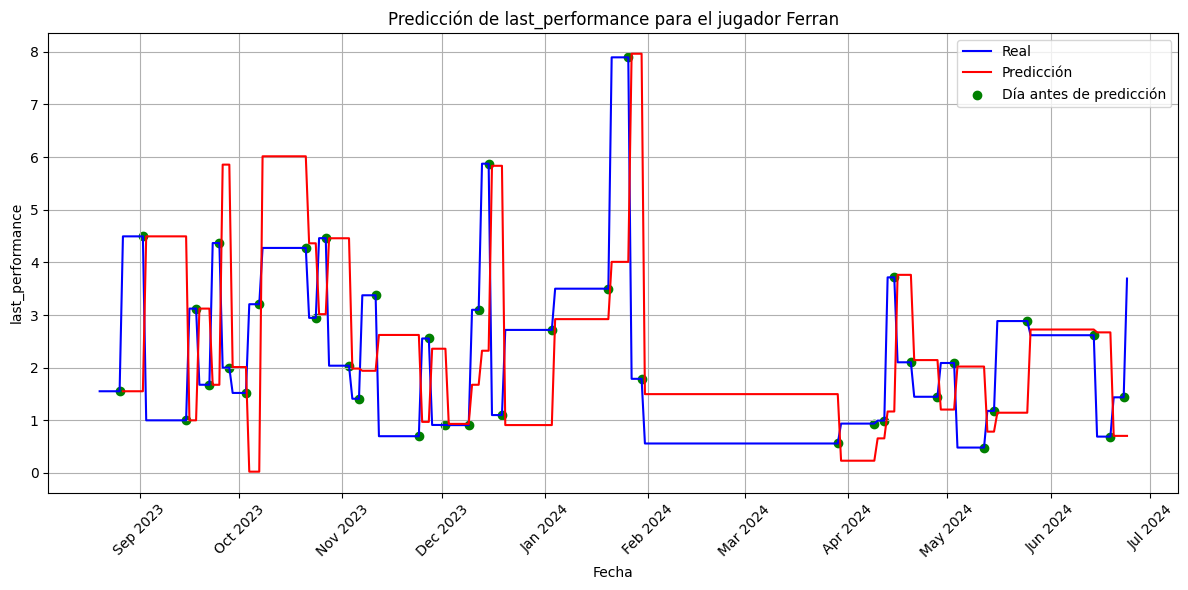

______Todos los días____________
Mean error todos: 1.545395386481119
Std error todos: 1.1660757366972256
Min error todos: 0.023176906486561677
Max error todos: 6.175475901872003
Median error todos: 1.4342376171981874

______Días de partido___________
Mean error dia partido: 1.8884540805832017
Std error dia partido: 1.3341601859495855
Min error dia partido: 0.023176906486561677
Max error dia partido: 6.175475901872003
Median error dia partido: 1.5842122771180922

______Días antes de partido_____
Mean error dia antes partido: 1.8595066984975288
Std error dia antes partido: 1.3394569735477881
Min error dia antes partido: 0.023176906486561677
Max error dia antes partido: 6.175475901872003
Median error dia antes partido: 1.5615365618175008


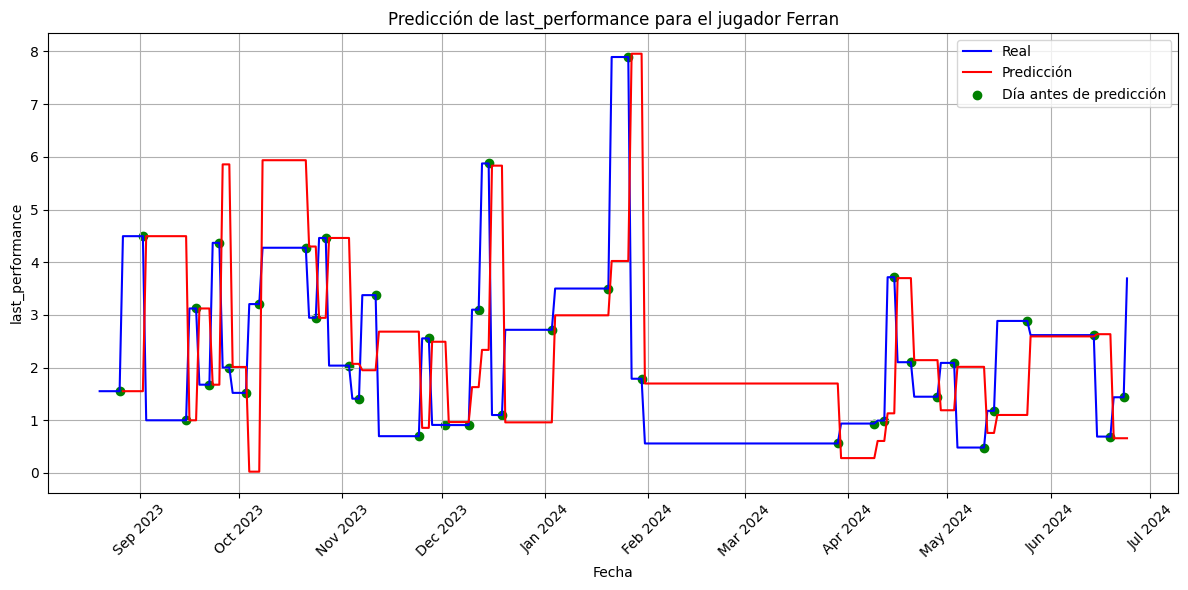

______Todos los días____________
Mean error todos: 1.57597108880039
Std error todos: 1.1567987380038343
Min error todos: 0.024460002484102183
Max error todos: 6.16913299370233
Median error todos: 1.425421691765224

______Días de partido___________
Mean error dia partido: 1.900071506583783
Std error dia partido: 1.3288264941233718
Min error dia partido: 0.024460002484102183
Max error dia partido: 6.16913299370233
Median error dia partido: 1.595903737428507

______Días antes de partido_____
Mean error dia antes partido: 1.8702372251231498
Std error dia antes partido: 1.3332420832887495
Min error dia antes partido: 0.024460002484102183
Max error dia antes partido: 6.16913299370233
Median error dia antes partido: 1.5873751199511843


In [23]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,15),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

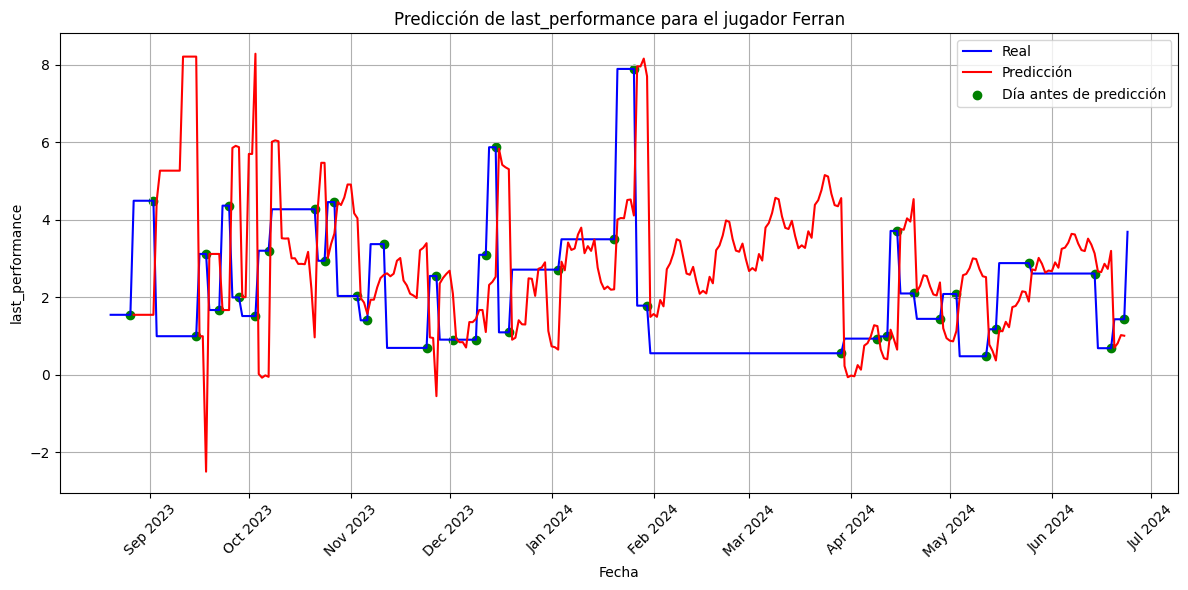

______Todos los días____________
Mean error todos: 2.03298941286404
Std error todos: 1.5011381119911764
Min error todos: 0.004834576944369839
Max error todos: 7.213144987710879
Median error todos: 1.7574675218551565

______Días de partido___________
Mean error dia partido: 1.8595066984975288
Std error dia partido: 1.3394569735477881
Min error dia partido: 0.023176906486561677
Max error dia partido: 6.175475901872003
Median error dia partido: 1.5615365618175008

______Días antes de partido_____
Mean error dia antes partido: 2.4508687319041758
Std error dia antes partido: 1.7782838734764577
Min error dia antes partido: 0.16564895100756694
Max error dia antes partido: 7.213144987710879
Median error dia antes partido: 2.248665762195638


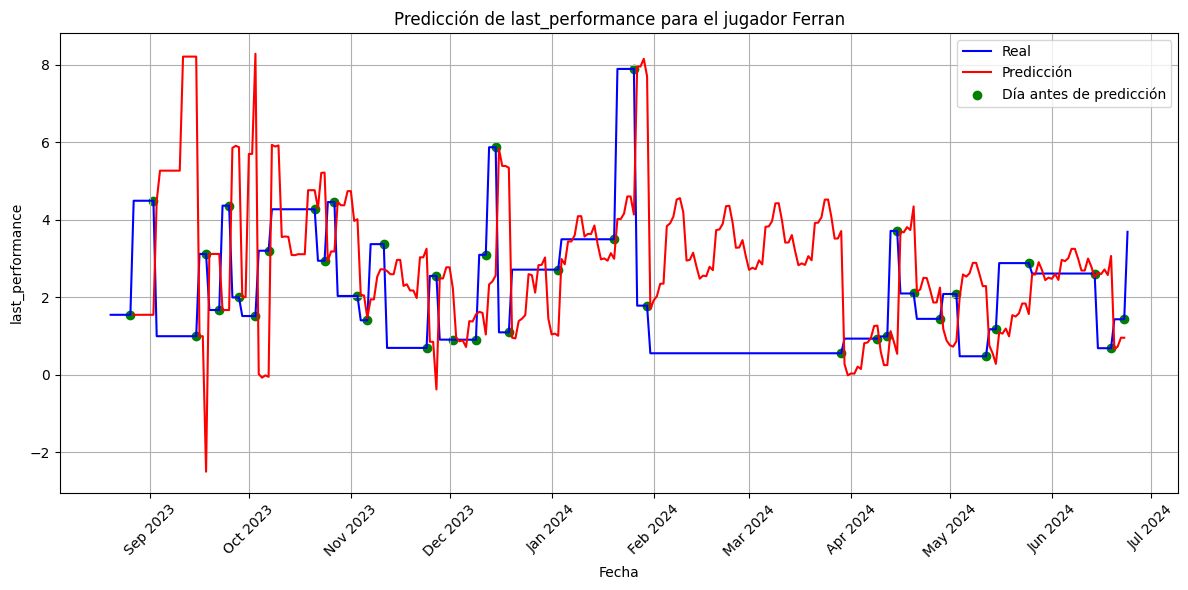

______Todos los días____________
Mean error todos: 1.984607821039131
Std error todos: 1.5164004654929168
Min error todos: 0.011270014753877122
Max error todos: 7.213144987710879
Median error todos: 1.7650893855787544

______Días de partido___________
Mean error dia partido: 1.8702372251231498
Std error dia partido: 1.3332420832887495
Min error dia partido: 0.024460002484102183
Max error dia partido: 6.16913299370233
Median error dia partido: 1.5873751199511843

______Días antes de partido_____
Mean error dia antes partido: 2.318991706597122
Std error dia antes partido: 1.7943220467387815
Min error dia antes partido: 0.06351635160855196
Max error dia antes partido: 7.213144987710879
Median error dia antes partido: 2.017104077931205


In [17]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,15),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

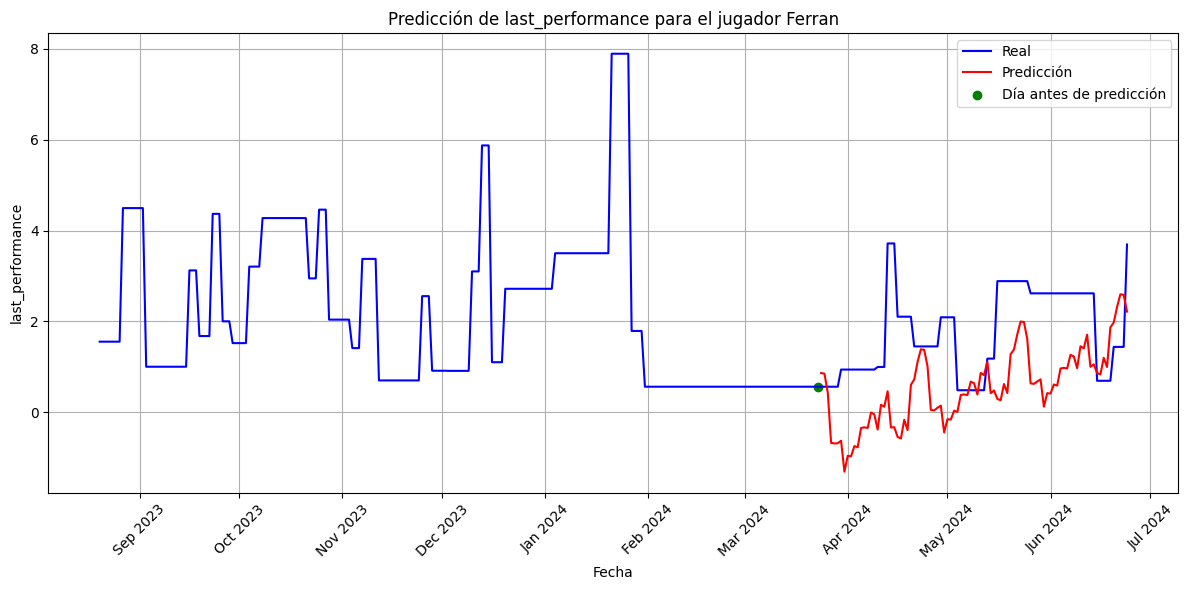

______Todos los días____________
Mean error todos: 1.3653958078409267
Std error todos: 0.8740513664181313
Min error todos: 0.06292283005466492
Max error todos: 4.054527025966183
Median error todos: 1.3508269307257916

______Días de partido___________
Mean error dia partido: 1.4483534625945609
Std error dia partido: 0.9768699867665006
Min error dia partido: 0.06735891978679542
Max error dia partido: 3.255539770589426
Median error dia partido: 1.4785170238624796

______Días antes de partido_____
Mean error dia antes partido: 1.4048679723695454
Std error dia antes partido: 0.8643094803417208
Min error dia antes partido: 0.3332989086726132
Max error dia antes partido: 4.048195972909087
Median error dia antes partido: 1.2443698055605643


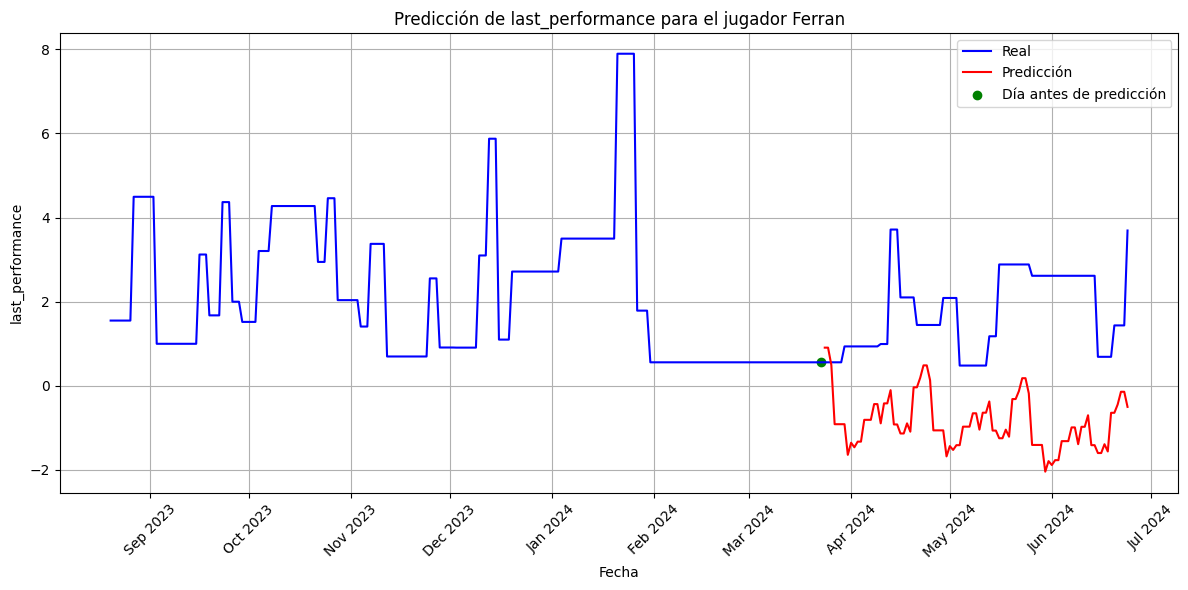

______Todos los días____________
Mean error todos: 2.6278592260833076
Std error todos: 1.1821396810718323
Min error todos: 0.06536239748603417
Max error todos: 4.656363758493715
Median error todos: 2.505413428994747

______Días de partido___________
Mean error dia partido: 2.7359168528963025
Std error dia partido: 1.0055494154683882
Min error dia partido: 1.4822456777240791
Max error dia partido: 4.192880469892027
Median error dia partido: 2.2873666638085077

______Días antes de partido_____
Mean error dia antes partido: 2.3376719290194248
Std error dia antes partido: 1.0986932539555965
Min error dia antes partido: 1.1203306860165465
Max error dia antes partido: 4.633186960899963
Median error dia antes partido: 2.1371999351606585


In [ ]:

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,15),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Gerard Moreno

In [24]:
jugador = 'Gerard Moreno'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

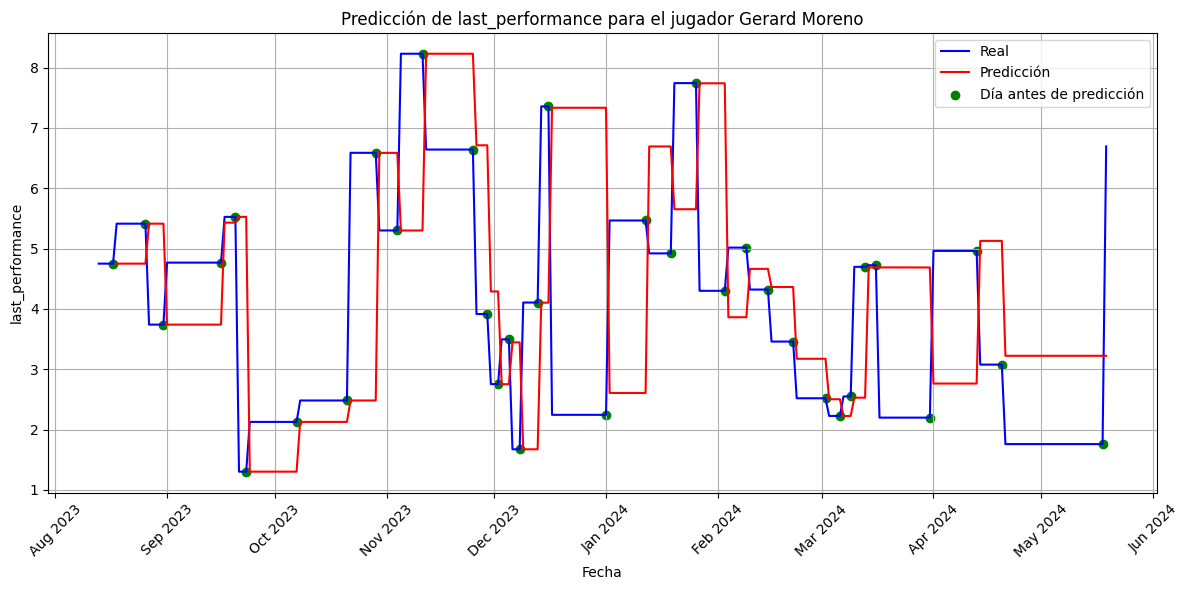

______Todos los días____________
Mean error todos: 1.859370001887687
Std error todos: 1.2672897708423898
Min error todos: 0.035419793417171164
Max error todos: 5.090243107113388
Median error todos: 1.5884598695105243

______Días de partido___________
Mean error dia partido: 1.8313650988626502
Std error dia partido: 1.265062740865093
Min error dia partido: 0.035419793417171164
Max error dia partido: 5.090243107113388
Median error dia partido: 1.6733421328114333

______Días antes de partido_____
Mean error dia antes partido: 1.7831426488844384
Std error dia antes partido: 1.2514250614436728
Min error dia antes partido: 0.035419793417171164
Max error dia antes partido: 5.090243107113388
Median error dia antes partido: 1.6309010011609788


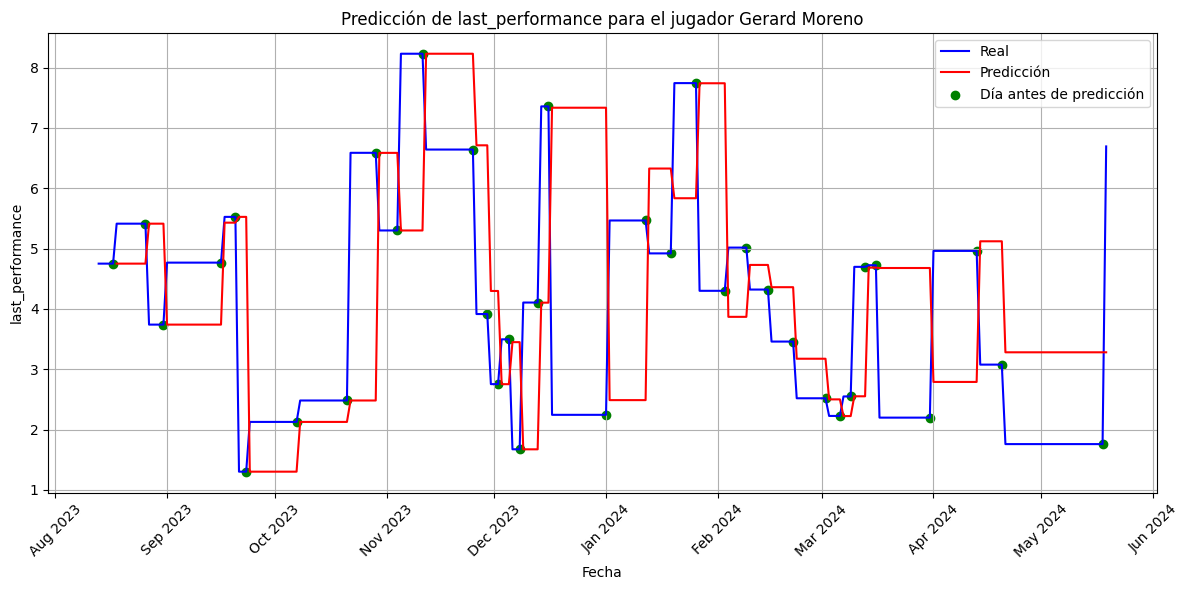

______Todos los días____________
Mean error todos: 1.855091996705217
Std error todos: 1.2685967054346408
Min error todos: 0.03939027048047539
Max error todos: 5.091046493884365
Median error todos: 1.5218255969301975

______Días de partido___________
Mean error dia partido: 1.8192956530080653
Std error dia partido: 1.264002922117018
Min error dia partido: 0.03939027048047539
Max error dia partido: 5.091046493884365
Median error dia partido: 1.5884384920012682

______Días antes de partido_____
Mean error dia antes partido: 1.7724260829362775
Std error dia antes partido: 1.2521214726443828
Min error dia antes partido: 0.03939027048047539
Max error dia antes partido: 5.091046493884365
Median error dia antes partido: 1.5661845159799743


In [33]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

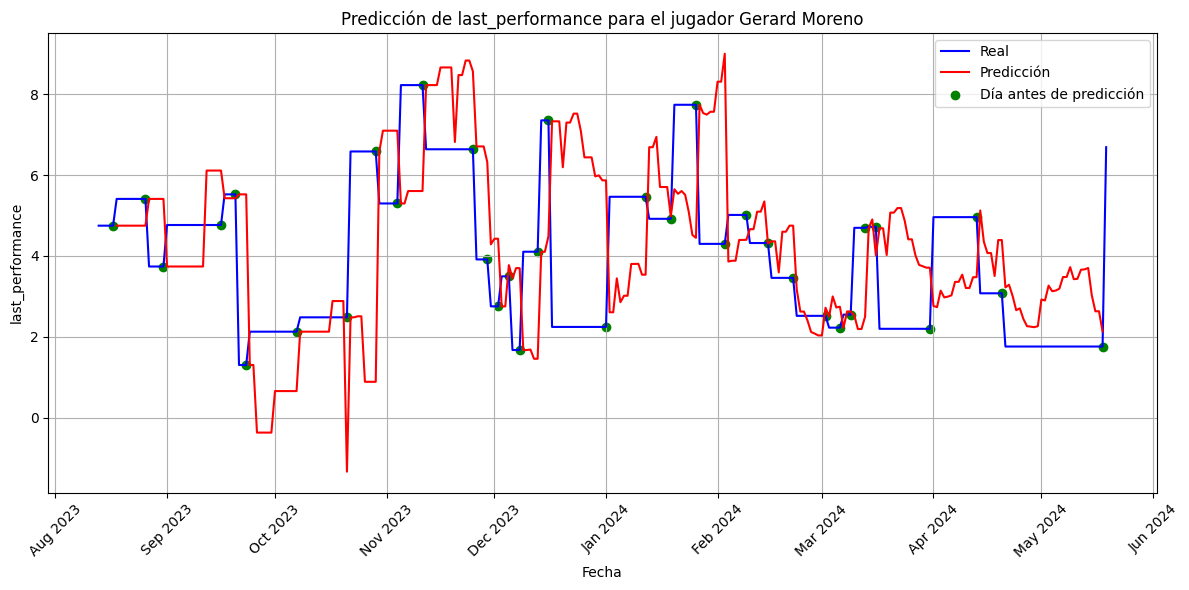

______Todos los días____________
Mean error todos: 1.8147967442624
Std error todos: 1.2821652557524286
Min error todos: 0.012693453411101174
Max error todos: 5.7017592702223405
Median error todos: 1.601962906217226

______Días de partido___________
Mean error dia partido: 1.7831426488844384
Std error dia partido: 1.2514250614436728
Min error dia partido: 0.035419793417171164
Max error dia partido: 5.090243107113388
Median error dia partido: 1.6309010011609788

______Días antes de partido_____
Mean error dia antes partido: 1.7998081189663901
Std error dia antes partido: 1.4129652918080107
Min error dia antes partido: 0.012693453411101174
Max error dia antes partido: 5.70175927022234
Median error dia antes partido: 1.5935315494780455


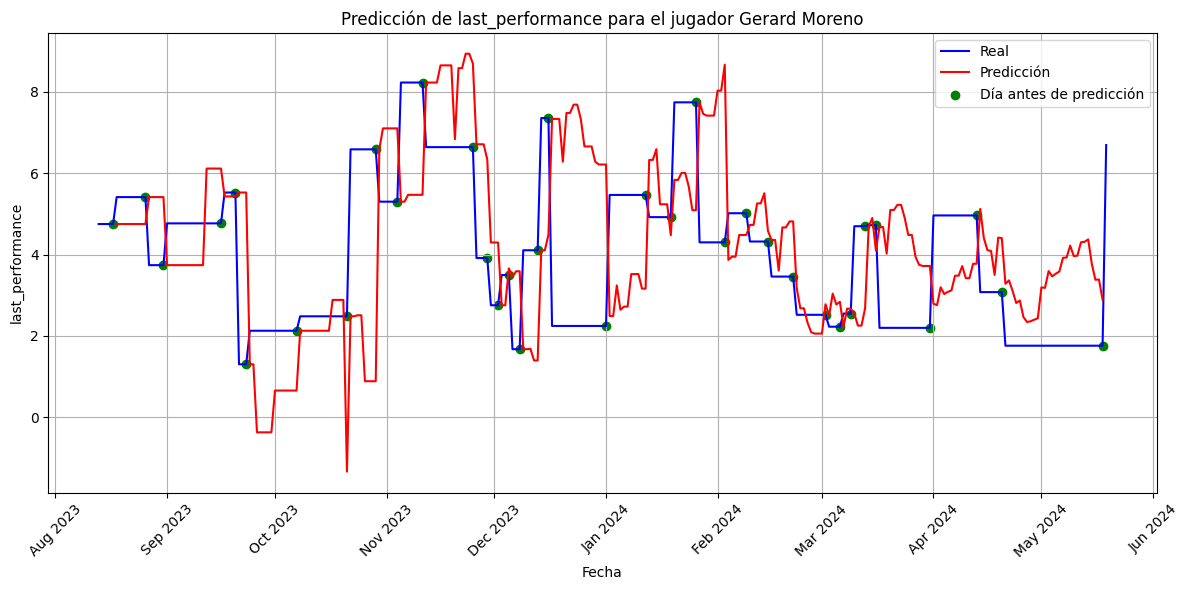

______Todos los días____________
Mean error todos: 1.8498647567171864
Std error todos: 1.290663848700336
Min error todos: 0.03939027048047539
Max error todos: 5.702140953966612
Median error todos: 1.6221796349616686

______Días de partido___________
Mean error dia partido: 1.7724260829362775
Std error dia partido: 1.2521214726443828
Min error dia partido: 0.03939027048047539
Max error dia partido: 5.091046493884365
Median error dia partido: 1.5661845159799743

______Días antes de partido_____
Mean error dia antes partido: 1.8217267049895238
Std error dia antes partido: 1.3640602712344794
Min error dia antes partido: 0.09602803485731037
Max error dia antes partido: 5.702140953901663
Median error dia antes partido: 1.5322398227656617


In [43]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

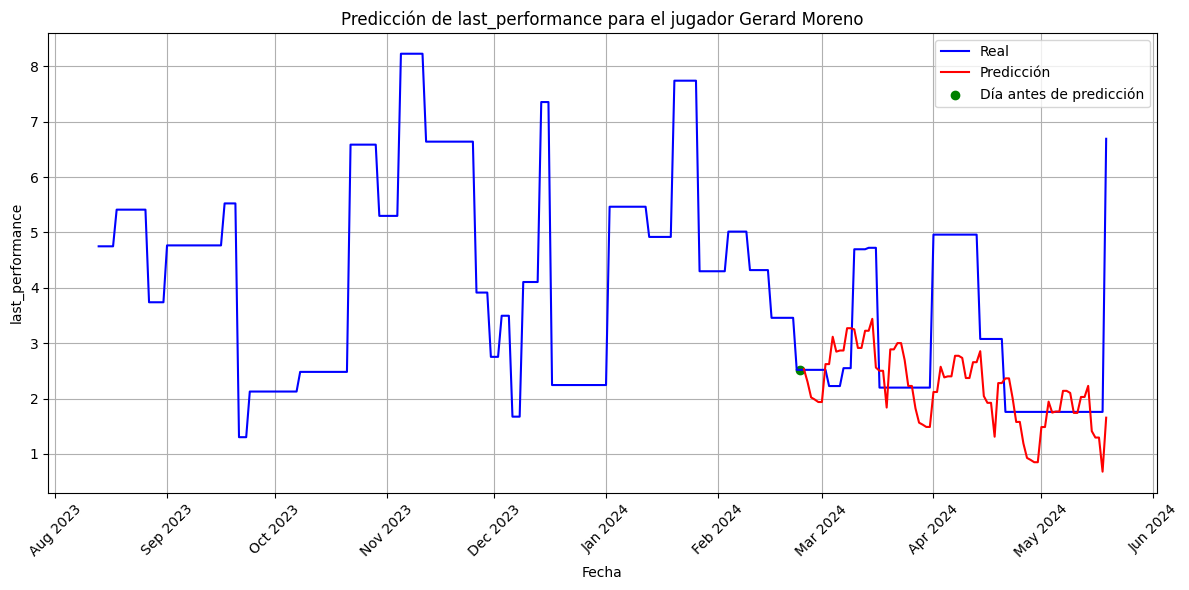

______Todos los días____________
Mean error todos: 0.9551486287068724
Std error todos: 0.9162950542425189
Min error todos: 0.006229634104673476
Max error todos: 5.039047261180068
Median error todos: 0.6421730079456696

______Días de partido___________
Mean error dia partido: 1.4082306018316777
Std error dia partido: 1.5178786145551812
Min error dia partido: 0.22055186719274333
Max error dia partido: 5.039047261180068
Median error dia partido: 0.605865599931255

______Días antes de partido_____
Mean error dia antes partido: 1.1106914070419913
Std error dia antes partido: 0.6919932146676726
Min error dia antes partido: 0.10373925111410376
Max error dia antes partido: 2.304827440521018
Median error dia antes partido: 0.79704687531266


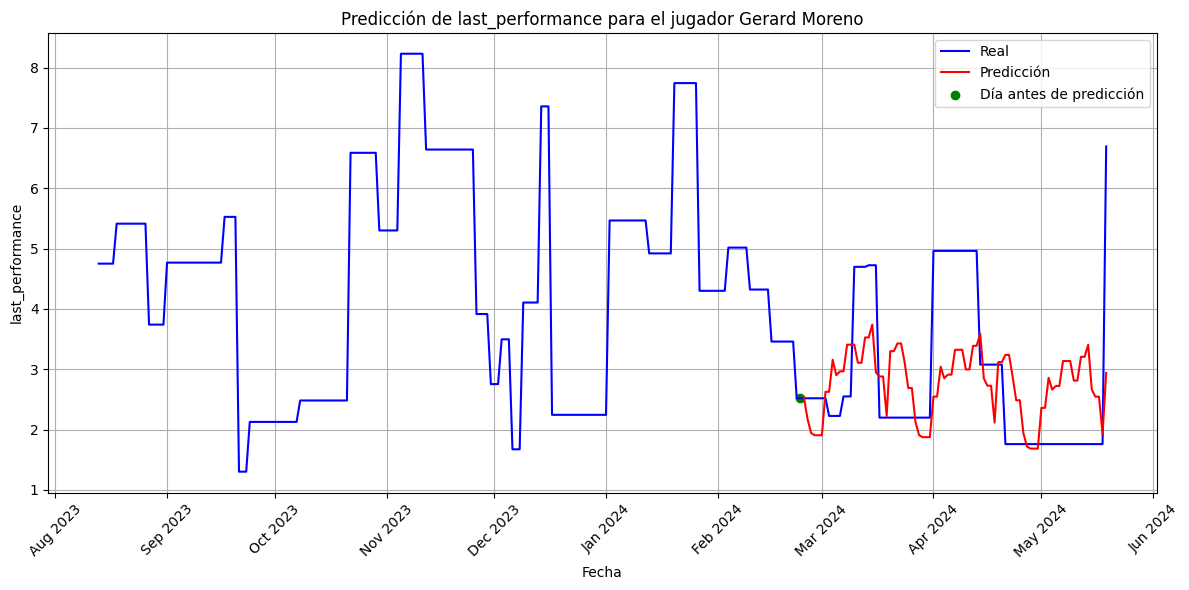

______Todos los días____________
Mean error todos: 0.9690047464837929
Std error todos: 0.6858198535058491
Min error todos: 0.014005111163217343
Max error todos: 3.7547252647169373
Median error todos: 0.9037073845177646

______Días de partido___________
Mean error dia partido: 1.3494335828536665
Std error dia partido: 1.0481283140910935
Min error dia partido: 0.3997482899934517
Max error dia partido: 3.7547252647169373
Median error dia partido: 1.1967027018727605

______Días antes de partido_____
Mean error dia antes partido: 0.7512771435088992
Std error dia antes partido: 0.610099411063262
Min error dia antes partido: 0.04191755955262266
Max error dia antes partido: 1.7761154751403576
Median error dia antes partido: 0.7392807724327595


In [46]:

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Griezmann

In [7]:
jugador = 'Griezmann'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

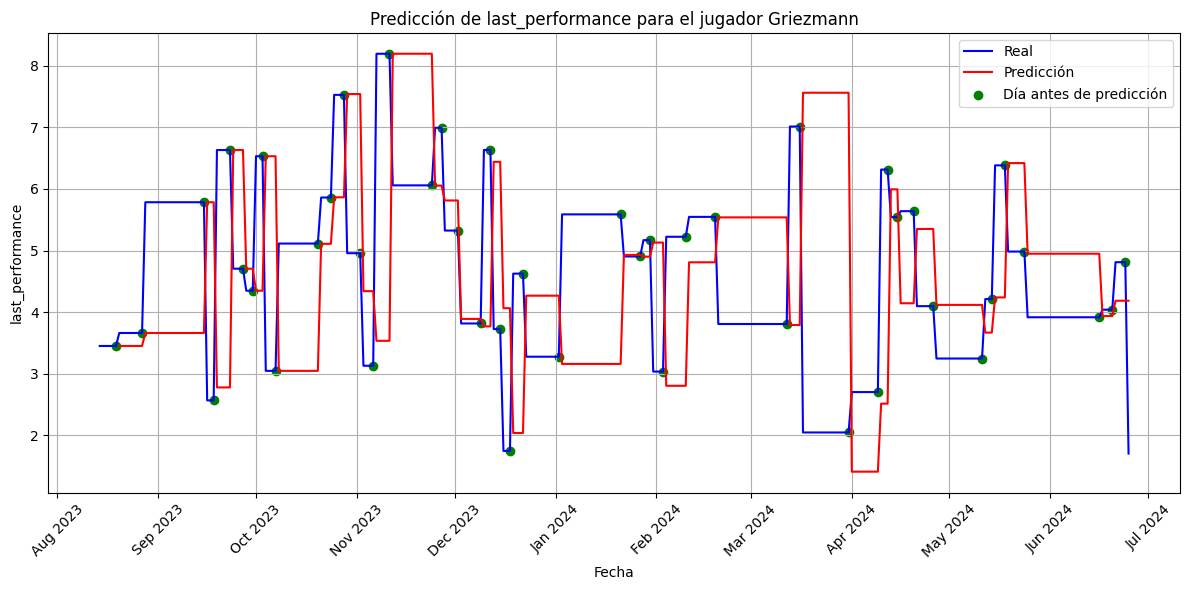

______Todos los días____________
Mean error todos: 1.8301348916270206
Std error todos: 1.2691515335152905
Min error todos: 0.02527467882166512
Max error todos: 5.51288543200918
Median error todos: 1.730402444038206

______Días de partido___________
Mean error dia partido: 1.8075974503402028
Std error dia partido: 1.2567057485465172
Min error dia partido: 0.02527467882166512
Max error dia partido: 5.51288543200918
Median error dia partido: 1.730402444038206

______Días antes de partido_____
Mean error dia antes partido: 1.7923115297162164
Std error dia antes partido: 1.2667628273933362
Min error dia antes partido: 0.02527467882166512
Max error dia antes partido: 5.51288543200918
Median error dia antes partido: 1.6963814717235635


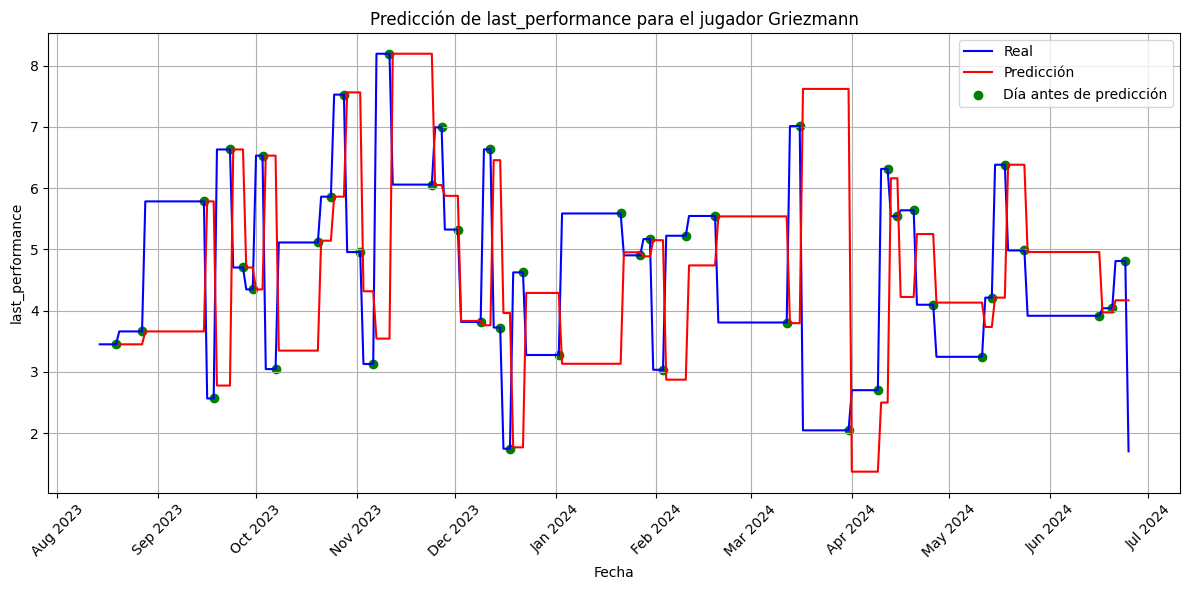

______Todos los días____________
Mean error todos: 1.8257106793064326
Std error todos: 1.2768576867512216
Min error todos: 0.01604338452255538
Max error todos: 5.571574530975555
Median error todos: 1.731588990421156

______Días de partido___________
Mean error dia partido: 1.80686720307017
Std error dia partido: 1.2618354592208298
Min error dia partido: 0.01604338452255538
Max error dia partido: 5.571574530975555
Median error dia partido: 1.731588990421156

______Días antes de partido_____
Mean error dia antes partido: 1.791919449915975
Std error dia antes partido: 1.2721482433483295
Min error dia antes partido: 0.01604338452255538
Max error dia antes partido: 5.571574530975555
Median error dia antes partido: 1.6984322670124454


In [8]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

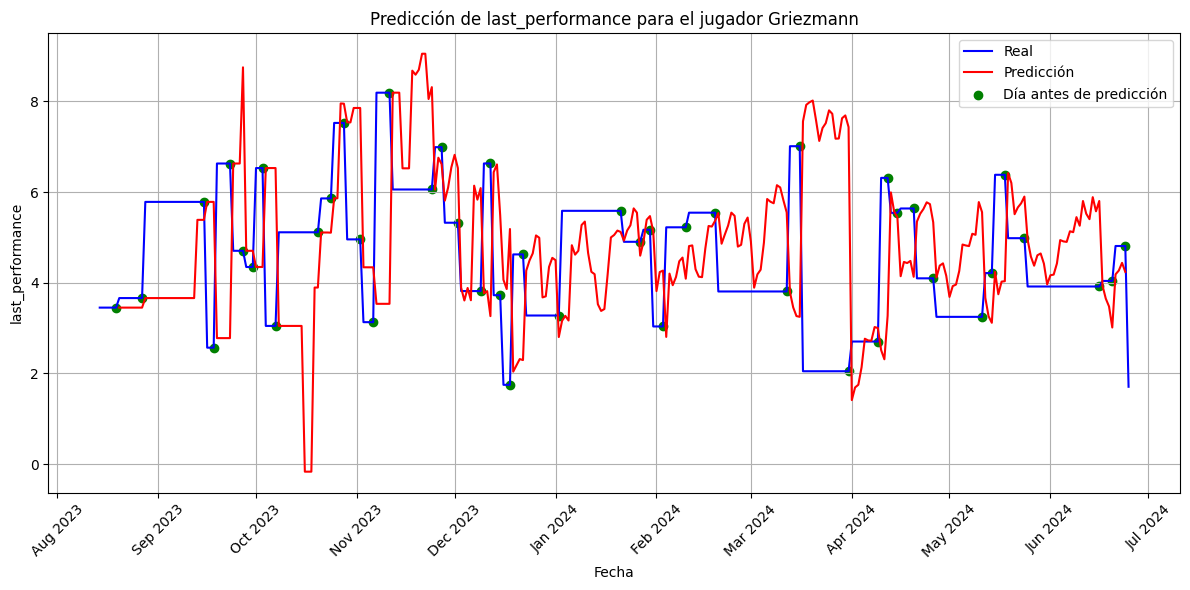

______Todos los días____________
Mean error todos: 1.7436084217516021
Std error todos: 1.3876754504359476
Min error todos: 0.017244266859548496
Max error todos: 5.971946112924374
Median error todos: 1.4232780592759404

______Días de partido___________
Mean error dia partido: 1.7923115297162164
Std error dia partido: 1.2667628273933362
Min error dia partido: 0.02527467882166512
Max error dia partido: 5.51288543200918
Median error dia partido: 1.6963814717235635

______Días antes de partido_____
Mean error dia antes partido: 1.7556102441713037
Std error dia antes partido: 1.3585139854930595
Min error dia antes partido: 0.09956889002800651
Max error dia antes partido: 5.386863776333231
Median error dia antes partido: 1.2347210317040502


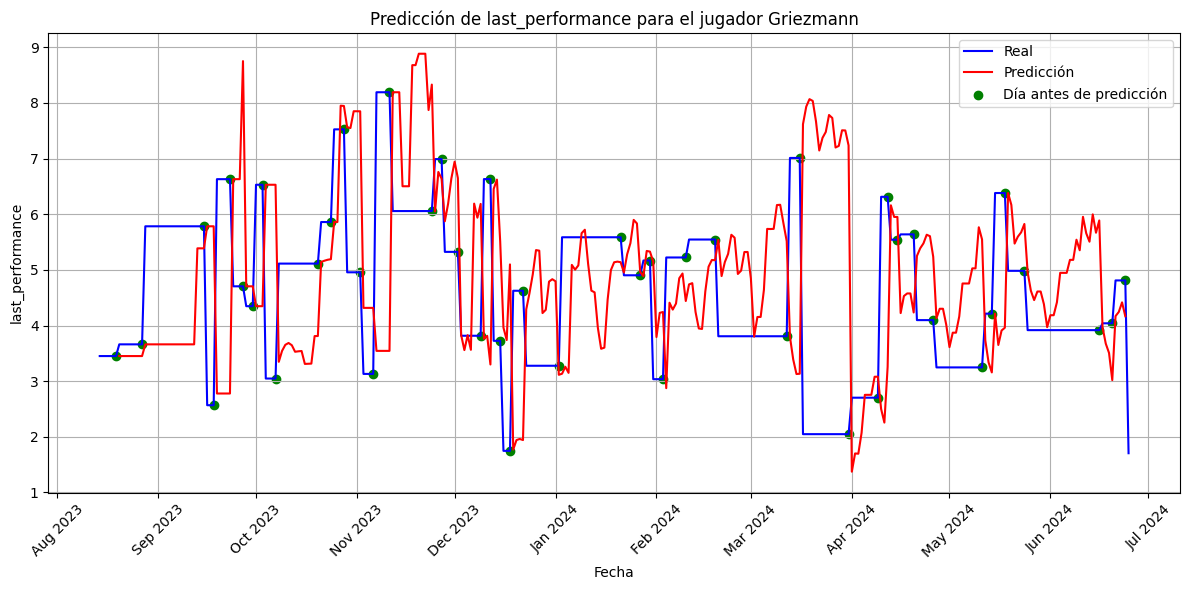

______Todos los días____________
Mean error todos: 1.6961595061832095
Std error todos: 1.3484627343494762
Min error todos: 0.00729874110747275
Max error todos: 6.0212886790866476
Median error todos: 1.4476871439327883

______Días de partido___________
Mean error dia partido: 1.791919449915975
Std error dia partido: 1.2721482433483295
Min error dia partido: 0.01604338452255538
Max error dia partido: 5.571574530975555
Median error dia partido: 1.6984322670124454

______Días antes de partido_____
Mean error dia antes partido: 1.7488969988457392
Std error dia antes partido: 1.3645114598898331
Min error dia antes partido: 0.06058903619997391
Max error dia antes partido: 5.1901955618904605
Median error dia antes partido: 1.31353154026611


In [9]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

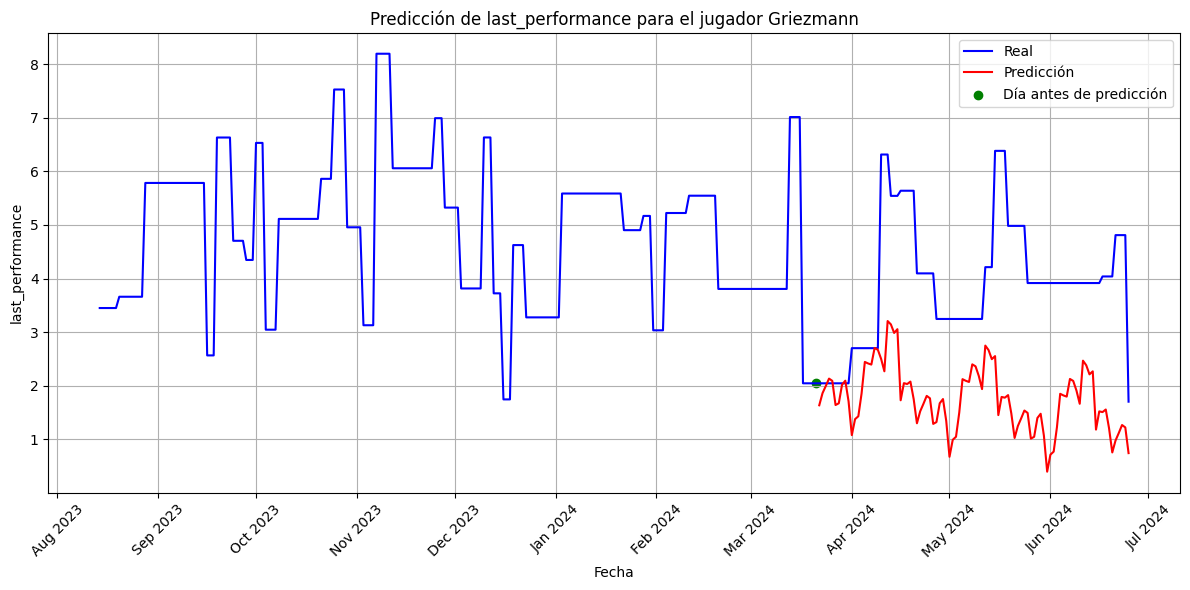

______Todos los días____________
Mean error todos: 2.168544448284283
Std error todos: 1.2431947018000629
Min error todos: 0.003496291805771712
Max error todos: 4.926890398704476
Median error todos: 2.2686100039891537

______Días de partido___________
Mean error dia partido: 2.6645274559915655
Std error dia partido: 0.9594071419243307
Min error dia partido: 0.9590013134985946
Max error dia partido: 3.9072074199649425
Median error dia partido: 2.5292807849165886

______Días antes de partido_____
Mean error dia antes partido: 2.5367468022786004
Std error dia antes partido: 1.3093442570686844
Min error dia antes partido: 0.031009616868644674
Max error dia antes partido: 4.602138000899796
Median error dia antes partido: 2.8063221566172643


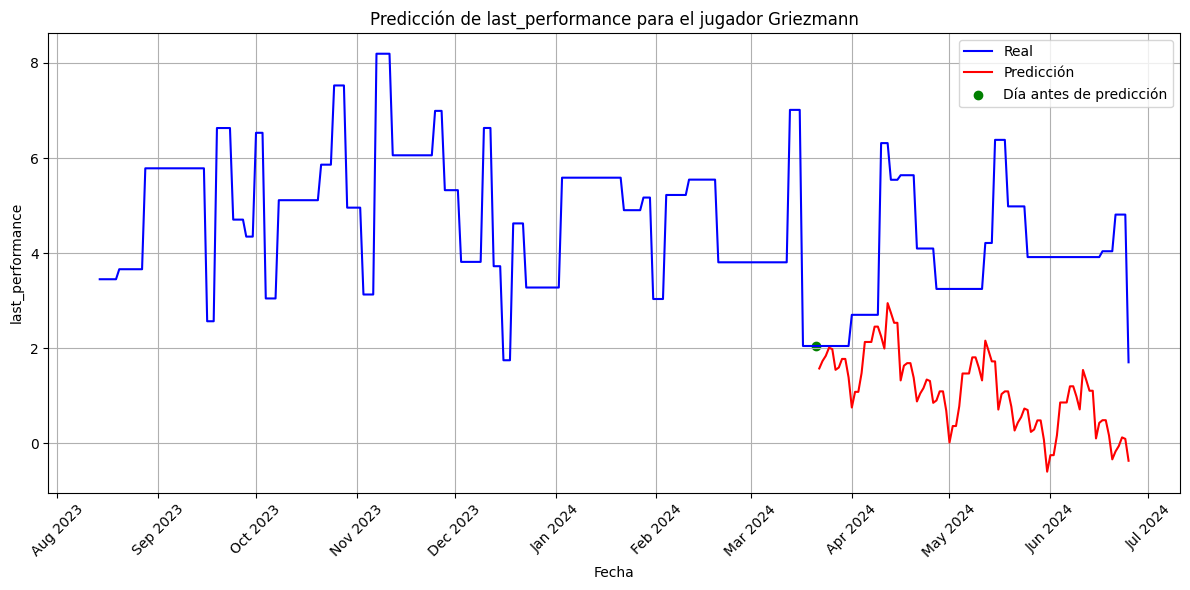

______Todos los días____________
Mean error todos: 2.8154125020926
Std error todos: 1.4208481992268402
Min error todos: 0.03609141162604157
Max error todos: 5.670751979458788
Median error todos: 2.971858308929396

______Días de partido___________
Mean error dia partido: 3.3154681791862126
Std error dia partido: 0.9907702379782648
Min error dia partido: 1.948616949463473
Max error dia partido: 4.980109298302895
Median error dia partido: 3.215889660126303

______Días antes de partido_____
Mean error dia antes partido: 3.1776815620403673
Std error dia antes partido: 1.4603239104786643
Min error dia antes partido: 0.247601326015086
Max error dia antes partido: 5.2885146775822
Median error dia antes partido: 3.3644580238363635


In [10]:
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config) 

# Koundé

In [11]:
jugador = 'Koundé'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

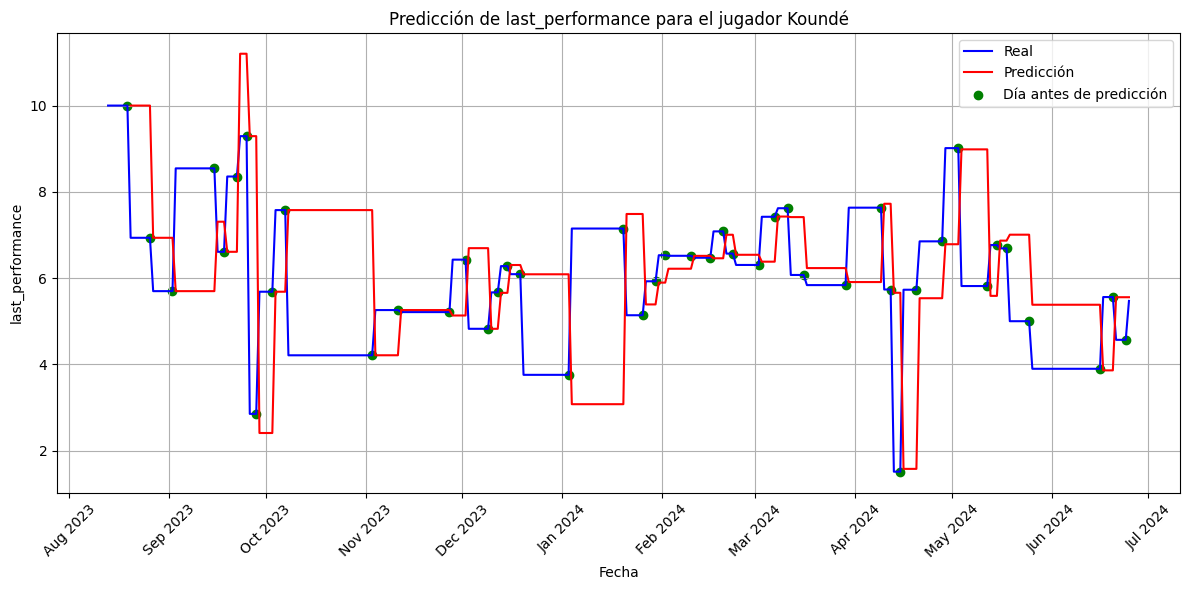

______Todos los días____________
Mean error todos: 1.8277675948862013
Std error todos: 1.3143727097203743
Min error todos: 0.043508153954408435
Max error todos: 6.438166311300639
Median error todos: 1.6997161980199262

______Días de partido___________
Mean error dia partido: 1.6286262353036407
Std error dia partido: 1.3580577726994976
Min error dia partido: 0.043508153954408435
Max error dia partido: 6.438166311300639
Median error dia partido: 1.3184295251308784

______Días antes de partido_____
Mean error dia antes partido: 1.6636812036060995
Std error dia antes partido: 1.3531219502607608
Min error dia antes partido: 0.043508153954408435
Max error dia antes partido: 6.438166311300639
Median error dia antes partido: 1.3298614007409761


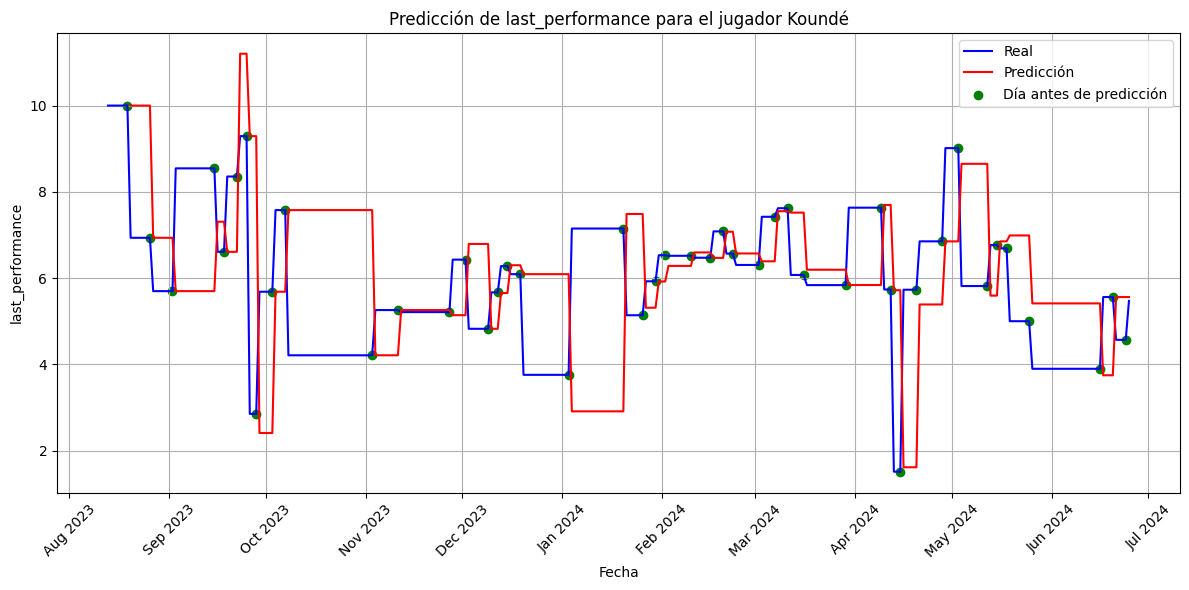

______Todos los días____________
Mean error todos: 1.8374854292718217
Std error todos: 1.3208675883822876
Min error todos: 0.04726345510186292
Max error todos: 6.438166311300577
Median error todos: 1.745557924662399

______Días de partido___________
Mean error dia partido: 1.6345071136519906
Std error dia partido: 1.3583020537263915
Min error dia partido: 0.04726345510186292
Max error dia partido: 6.438166311300577
Median error dia partido: 1.445200477472004

______Días antes de partido_____
Mean error dia antes partido: 1.669607097228829
Std error dia antes partido: 1.3533201898465157
Min error dia antes partido: 0.04726345510186292
Max error dia antes partido: 6.438166311300577
Median error dia antes partido: 1.4542650864372098


In [12]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

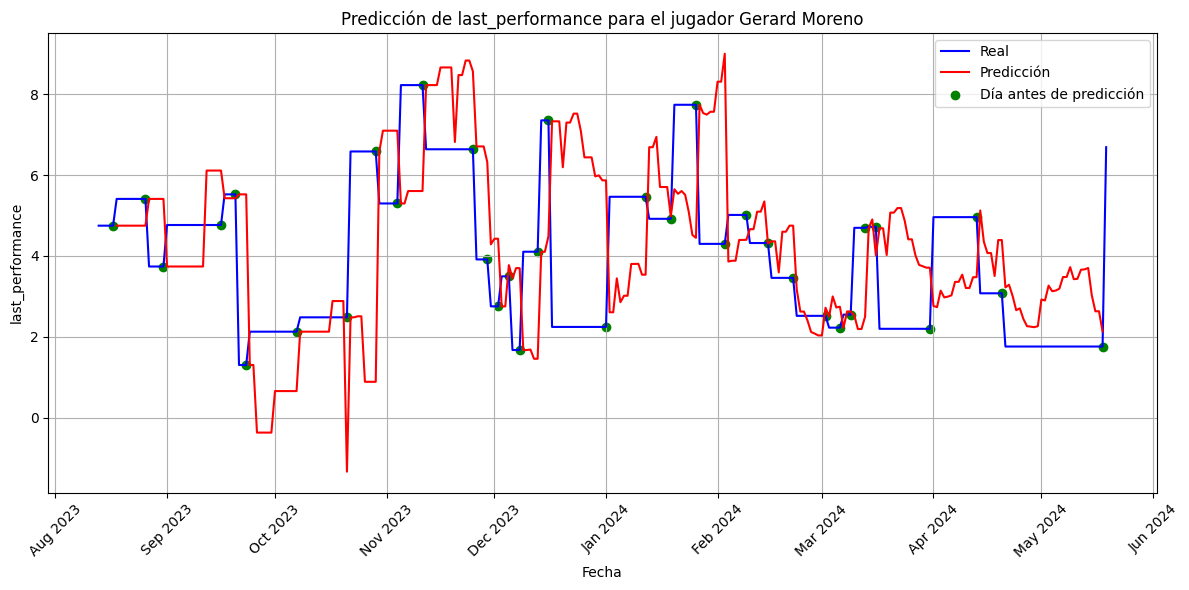

______Todos los días____________
Mean error todos: 1.8147967442624
Std error todos: 1.2821652557524286
Min error todos: 0.012693453411101174
Max error todos: 5.7017592702223405
Median error todos: 1.601962906217226

______Días de partido___________
Mean error dia partido: 1.7831426488844384
Std error dia partido: 1.2514250614436728
Min error dia partido: 0.035419793417171164
Max error dia partido: 5.090243107113388
Median error dia partido: 1.6309010011609788

______Días antes de partido_____
Mean error dia antes partido: 1.7998081189663901
Std error dia antes partido: 1.4129652918080107
Min error dia antes partido: 0.012693453411101174
Max error dia antes partido: 5.70175927022234
Median error dia antes partido: 1.5935315494780455


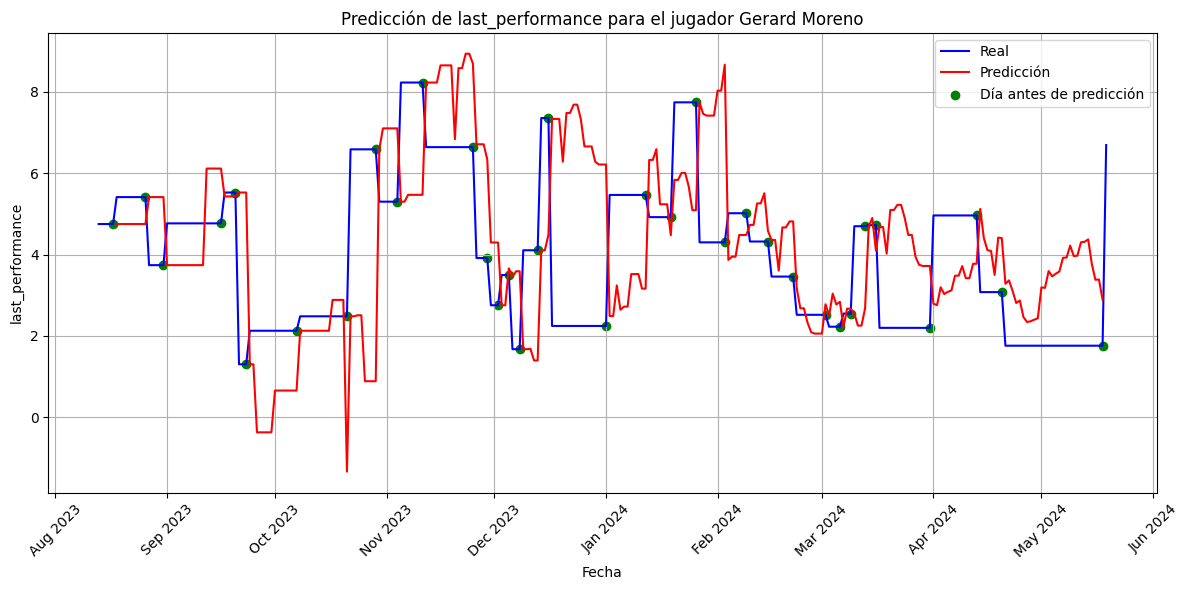

______Todos los días____________
Mean error todos: 1.8498647567171864
Std error todos: 1.290663848700336
Min error todos: 0.03939027048047539
Max error todos: 5.702140953966612
Median error todos: 1.6221796349616686

______Días de partido___________
Mean error dia partido: 1.7724260829362775
Std error dia partido: 1.2521214726443828
Min error dia partido: 0.03939027048047539
Max error dia partido: 5.091046493884365
Median error dia partido: 1.5661845159799743

______Días antes de partido_____
Mean error dia antes partido: 1.8217267049895238
Std error dia antes partido: 1.3640602712344794
Min error dia antes partido: 0.09602803485731037
Max error dia antes partido: 5.702140953901663
Median error dia antes partido: 1.5322398227656617


In [ ]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

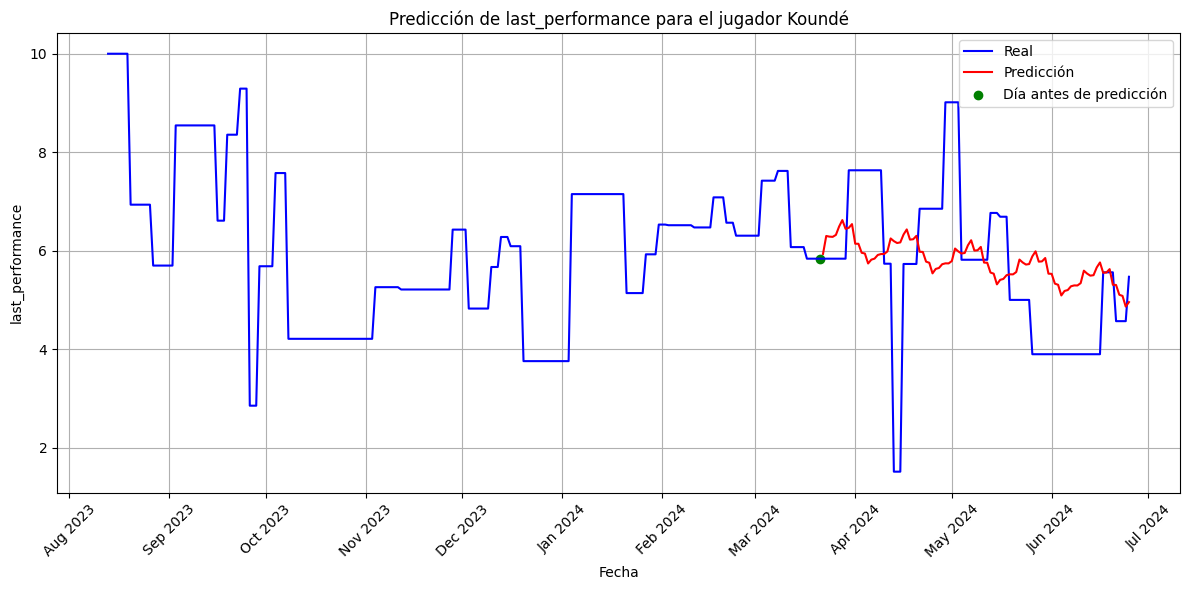

______Todos los días____________
Mean error todos: 1.2105749223963
Std error todos: 0.9699038179921046
Min error todos: 0.003422241562962114
Max error todos: 4.681354572333654
Median error todos: 1.17755881561067

______Días de partido___________
Mean error dia partido: 1.226667238968048
Std error dia partido: 1.2597775451829767
Min error dia partido: 0.009297530329475556
Max error dia partido: 4.681354572333654
Median error dia partido: 0.8041617053458157

______Días antes de partido_____
Mean error dia antes partido: 1.2885929315585776
Std error dia antes partido: 1.2067416371070292
Min error dia antes partido: 0.06143164893993536
Max error dia antes partido: 4.655732088120586
Median error dia antes partido: 0.9271379333605165


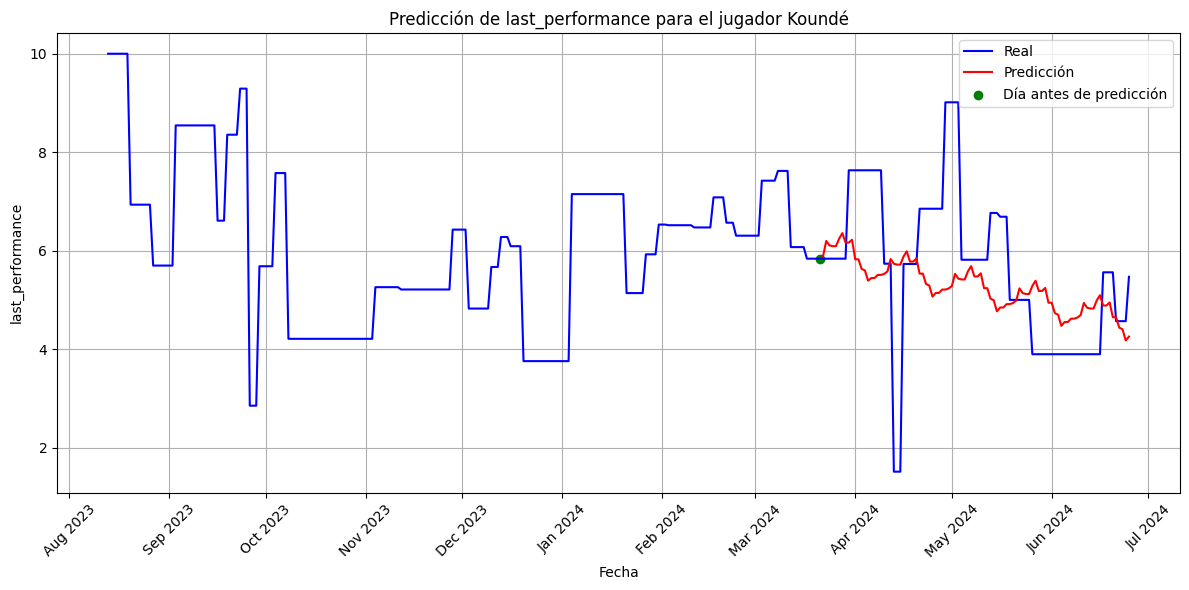

______Todos los días____________
Mean error todos: 1.144561749198821
Std error todos: 1.0529258424630055
Min error todos: 0.014154491484808851
Max error todos: 4.220999742746211
Median error todos: 0.8732879898664279

______Días de partido___________
Mean error dia partido: 1.3281307669447873
Std error dia partido: 1.2535706405934999
Min error dia partido: 0.07926977398116986
Max error dia partido: 4.220999742746211
Median error dia partido: 1.2665741276881737

______Días antes de partido_____
Mean error dia antes partido: 1.3608936125459132
Std error dia antes partido: 1.248129929265395
Min error dia antes partido: 0.09499196983531455
Max error dia antes partido: 4.20435450988648
Median error dia antes partido: 1.054936849056983


In [14]:

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Kubo

In [16]:
jugador = 'Kubo'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

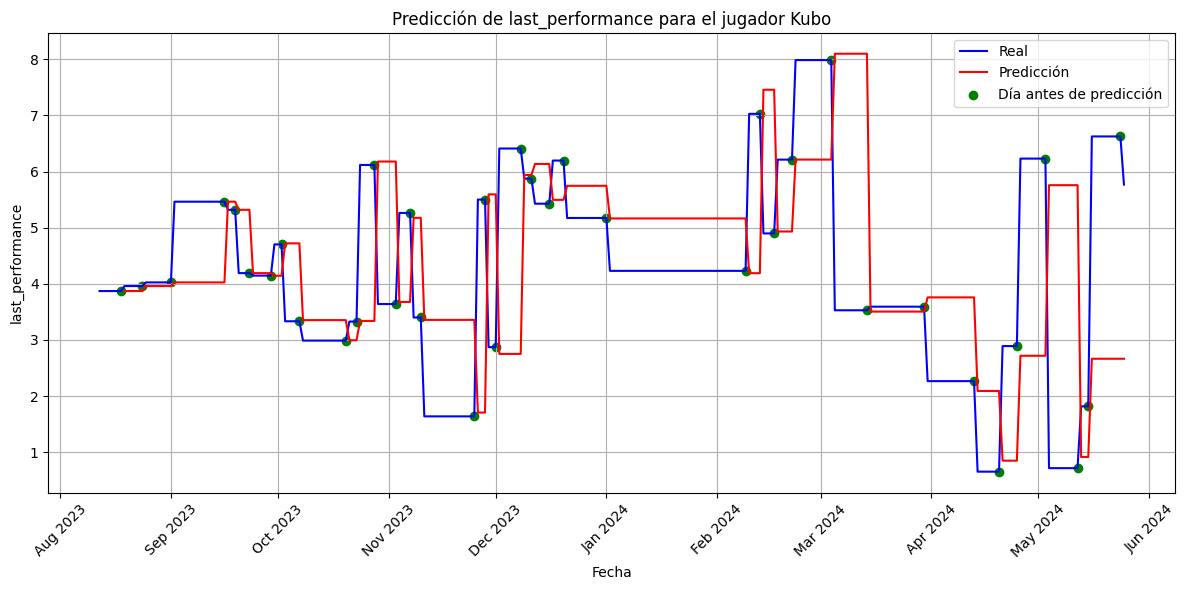

______Todos los días____________
Mean error todos: 1.6178615623569608
Std error todos: 1.352915879137075
Min error todos: 0.044283396736558345
Max error todos: 5.042971135341591
Median error todos: 1.4382595239178917

______Días de partido___________
Mean error dia partido: 1.7224578436048985
Std error dia partido: 1.3658389897585606
Min error dia partido: 0.044283396736558345
Max error dia partido: 5.042971135341591
Median error dia partido: 1.4383523693442828

______Días antes de partido_____
Mean error dia antes partido: 1.6840839770734735
Std error dia antes partido: 1.364863199915084
Min error dia antes partido: 0.044283396736558345
Max error dia antes partido: 5.042971135341591
Median error dia antes partido: 1.4383059466310872


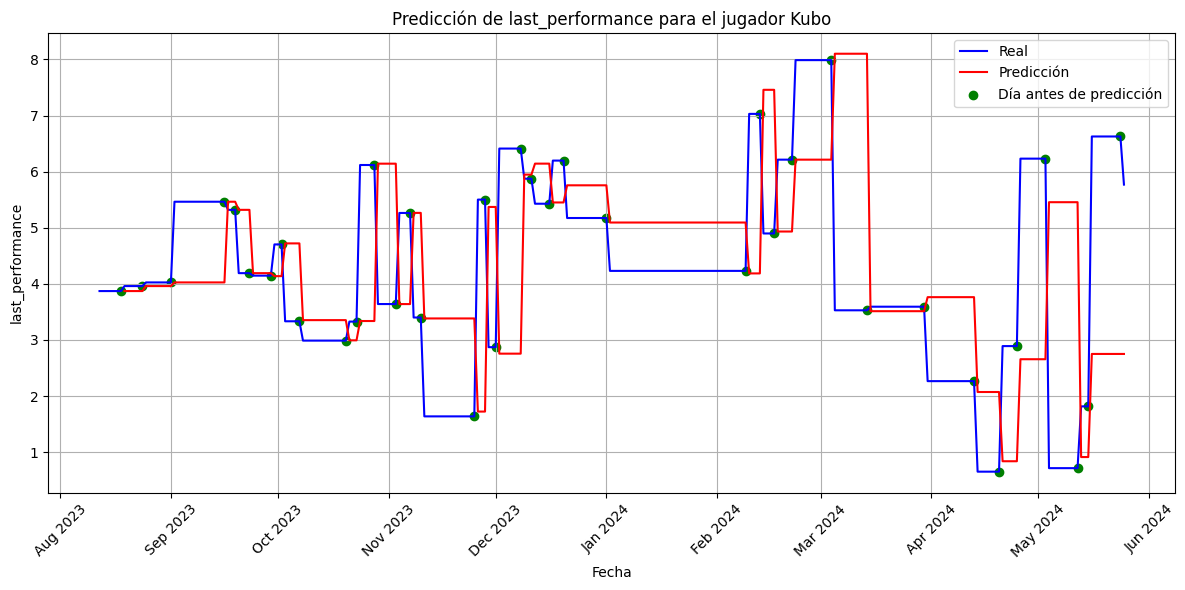

______Todos los días____________
Mean error todos: 1.597203891154331
Std error todos: 1.3291241289590527
Min error todos: 0.04421510253293803
Max error todos: 4.740294675627923
Median error todos: 1.419853446119268

______Días de partido___________
Mean error dia partido: 1.707724840322016
Std error dia partido: 1.3374007900706555
Min error dia partido: 0.04421510253293803
Max error dia partido: 4.740294675627923
Median error dia partido: 1.4382595239178917

______Días antes de partido_____
Mean error dia antes partido: 1.6713255245055483
Std error dia antes partido: 1.3376485580612434
Min error dia antes partido: 0.04421510253293803
Max error dia antes partido: 4.740294675627923
Median error dia antes partido: 1.4290564850185798


In [17]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

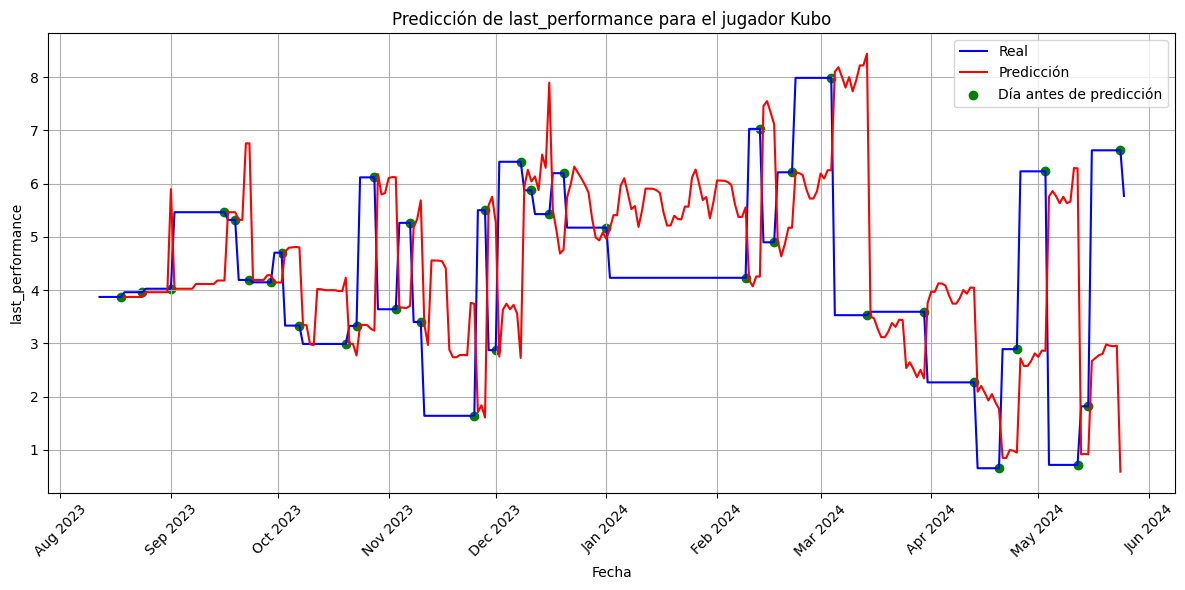

______Todos los días____________
Mean error todos: 1.7684482404090982
Std error todos: 1.2956640747782742
Min error todos: 0.008054457333353415
Max error todos: 6.038674029710545
Median error todos: 1.4655065303825925

______Días de partido___________
Mean error dia partido: 1.6840839770734735
Std error dia partido: 1.364863199915084
Min error dia partido: 0.044283396736558345
Max error dia partido: 5.042971135341591
Median error dia partido: 1.4383059466310872

______Días antes de partido_____
Mean error dia antes partido: 1.9858435874458769
Std error dia antes partido: 1.4486426659658034
Min error dia antes partido: 0.08898092940694502
Max error dia antes partido: 6.038674029710545
Median error dia antes partido: 1.7570732535748383


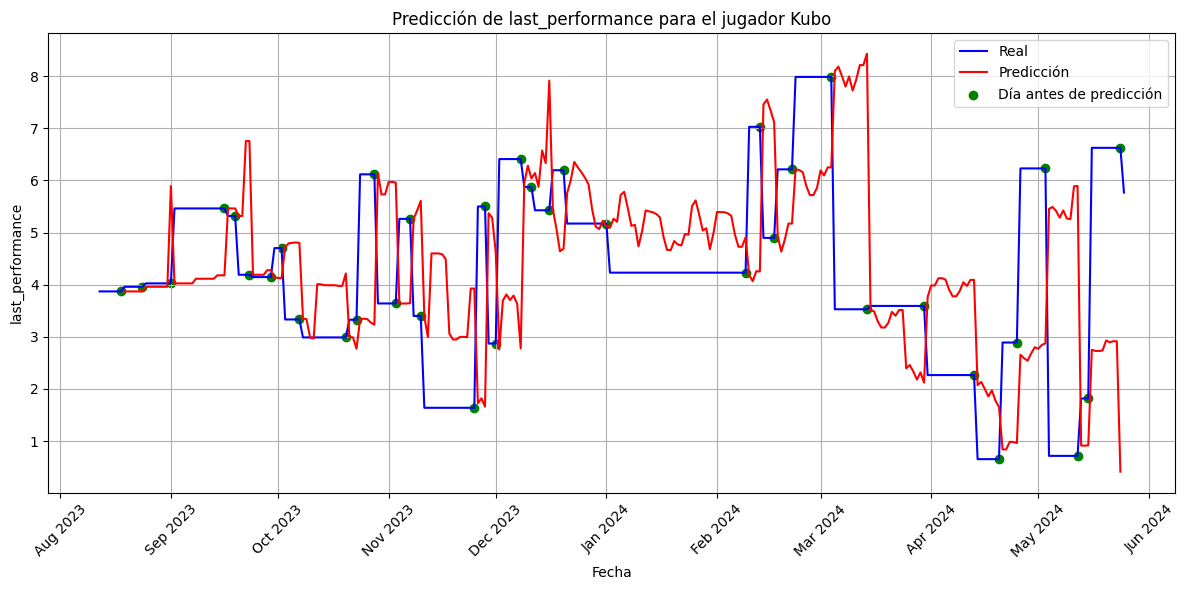

______Todos los días____________
Mean error todos: 1.6856704286748407
Std error todos: 1.2973936811591515
Min error todos: 0.0069620386206219464
Max error todos: 6.214684122235782
Median error todos: 1.360205657083697

______Días de partido___________
Mean error dia partido: 1.6713255245055483
Std error dia partido: 1.3376485580612434
Min error dia partido: 0.04421510253293803
Max error dia partido: 4.740294675627923
Median error dia partido: 1.4290564850185798

______Días antes de partido_____
Mean error dia antes partido: 1.9420796717880444
Std error dia antes partido: 1.4460515085337426
Min error dia antes partido: 0.0538559239966272
Max error dia antes partido: 6.214684122235782
Median error dia antes partido: 1.7440809170101204


In [22]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,20),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

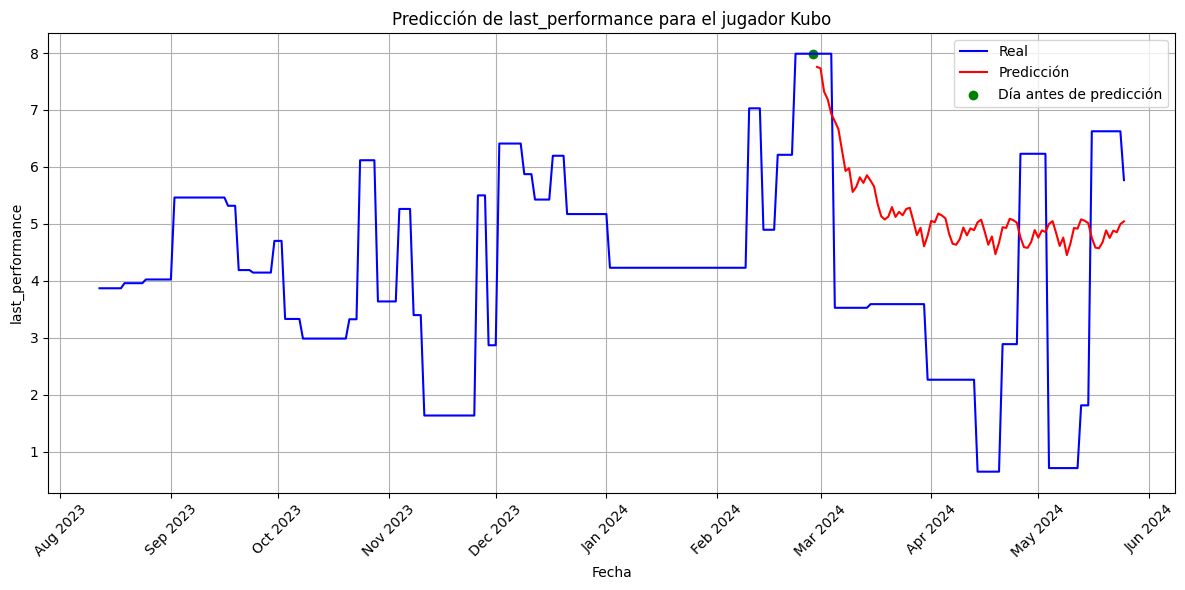

______Todos los días____________
Mean error todos: 2.3635054781603566
Std error todos: 1.0379120966284487
Min error todos: 0.23119308780563141
Max error todos: 4.42276475610191
Median error todos: 2.1684579042156025

______Días de partido___________
Mean error dia partido: 2.601382685951502
Std error dia partido: 1.1280389240522501
Min error dia partido: 0.7225268145959971
Max error dia partido: 4.377440141179862
Median error dia partido: 2.348596059673081

______Días antes de partido_____
Mean error dia antes partido: 2.35739161750121
Std error dia antes partido: 1.0952224739775756
Min error dia antes partido: 1.0154544381950195
Max error dia antes partido: 4.202641172420003
Median error dia antes partido: 2.229293403351858


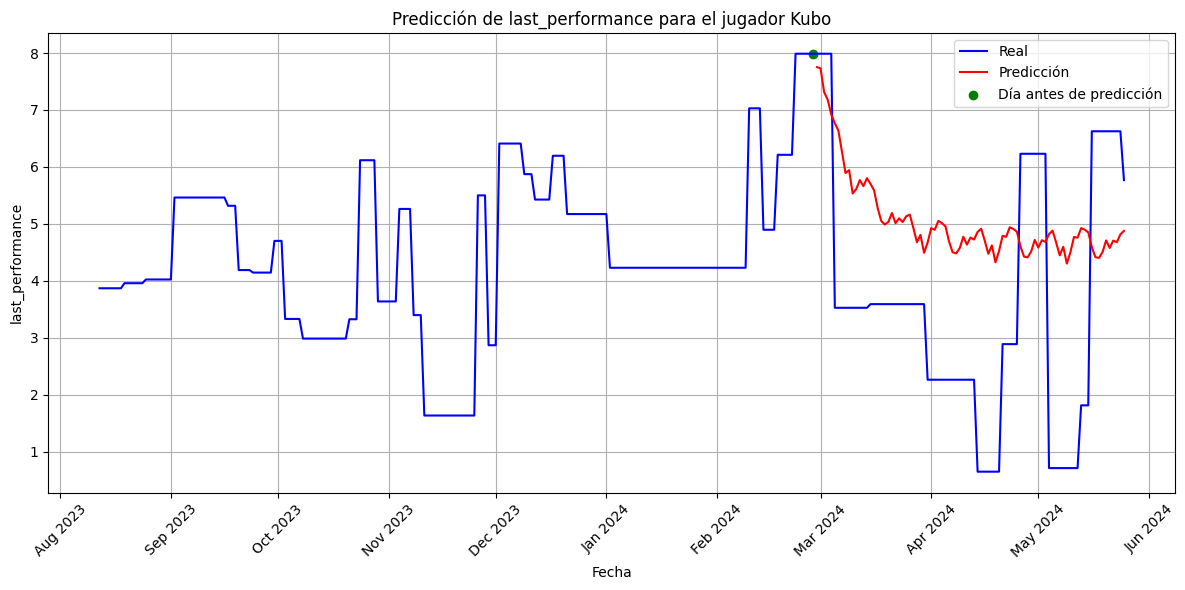

______Todos los días____________
Mean error todos: 2.3089494788026883
Std error todos: 0.9744306279696328
Min error todos: 0.23428875696891804
Max error todos: 4.264473309741495
Median error todos: 2.119994258629375

______Días de partido___________
Mean error dia partido: 2.563242180832843
Std error dia partido: 1.02331124102636
Min error dia partido: 0.8901523868402474
Max error dia partido: 4.207194173411909
Median error dia partido: 2.2592336895926364

______Días antes de partido_____
Mean error dia antes partido: 2.298674627606784
Std error dia antes partido: 1.0230436644129621
Min error dia antes partido: 0.9010859013160704
Max error dia antes partido: 4.042894433254485
Median error dia antes partido: 2.1250616816008705


In [28]:

config = {
    'order': (1,0,1),
    'seasonal_order': (1,1,1,20),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Lamine Yamal

In [30]:
jugador = 'Lamine Yamal'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

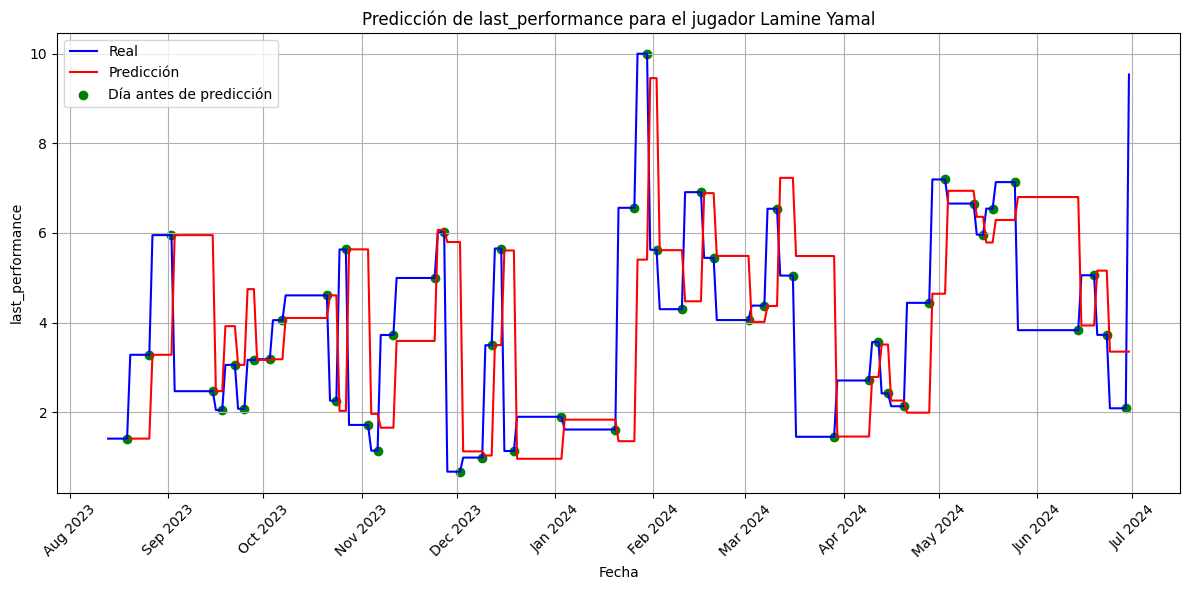

______Todos los días____________
Mean error todos: 1.8453872968085354
Std error todos: 1.403472125119413
Min error todos: 0.01433061939035607
Max error todos: 6.185120156506028
Median error todos: 1.4045694148271988

______Días de partido___________
Mean error dia partido: 1.9099827905037388
Std error dia partido: 1.512896427121944
Min error dia partido: 0.01433061939035607
Max error dia partido: 6.185120156506028
Median error dia partido: 1.4321462084804726

______Días antes de partido_____
Mean error dia antes partido: 1.822735089156753
Std error dia antes partido: 1.39819843671807
Min error dia antes partido: 0.01433061939035607
Max error dia antes partido: 5.2085545802440185
Median error dia antes partido: 1.431191243674843


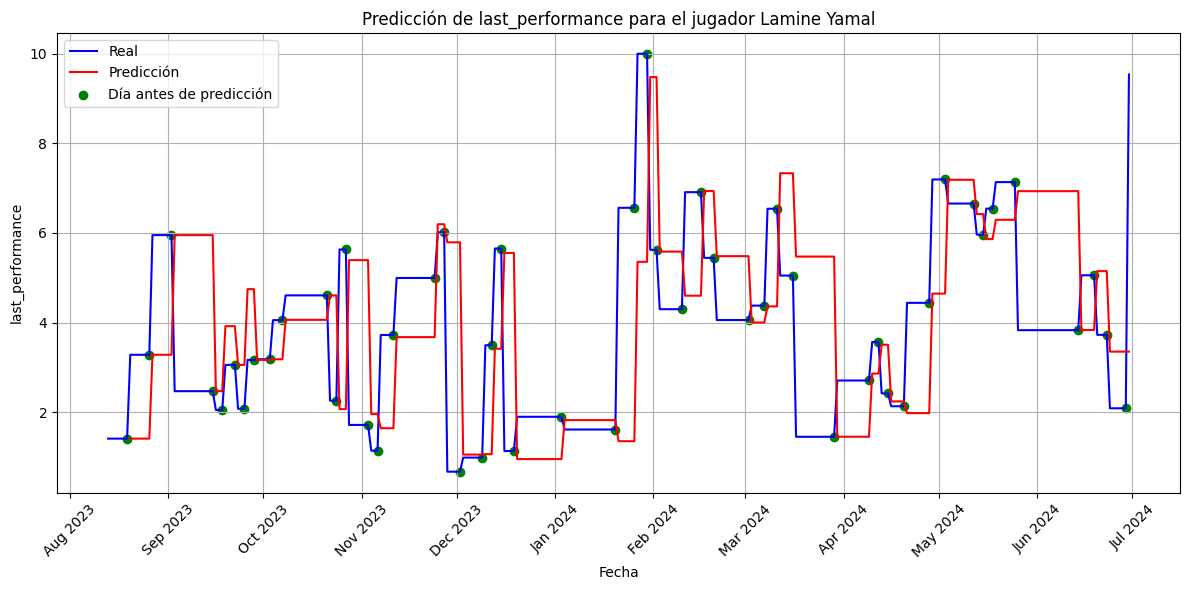

______Todos los días____________
Mean error todos: 1.8526591059429343
Std error todos: 1.395021377513018
Min error todos: 0.01433061939035607
Max error todos: 6.1843993553933565
Median error todos: 1.3201679196085716

______Días de partido___________
Mean error dia partido: 1.913139670441812
Std error dia partido: 1.5019950655751886
Min error dia partido: 0.01433061939035607
Max error dia partido: 6.1843993553933565
Median error dia partido: 1.4238987229385114

______Días antes de partido_____
Mean error dia antes partido: 1.825971105442801
Std error dia antes partido: 1.3864024798961168
Min error dia antes partido: 0.01433061939035607
Max error dia antes partido: 5.208539806151569
Median error dia antes partido: 1.4222653404512537


In [36]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

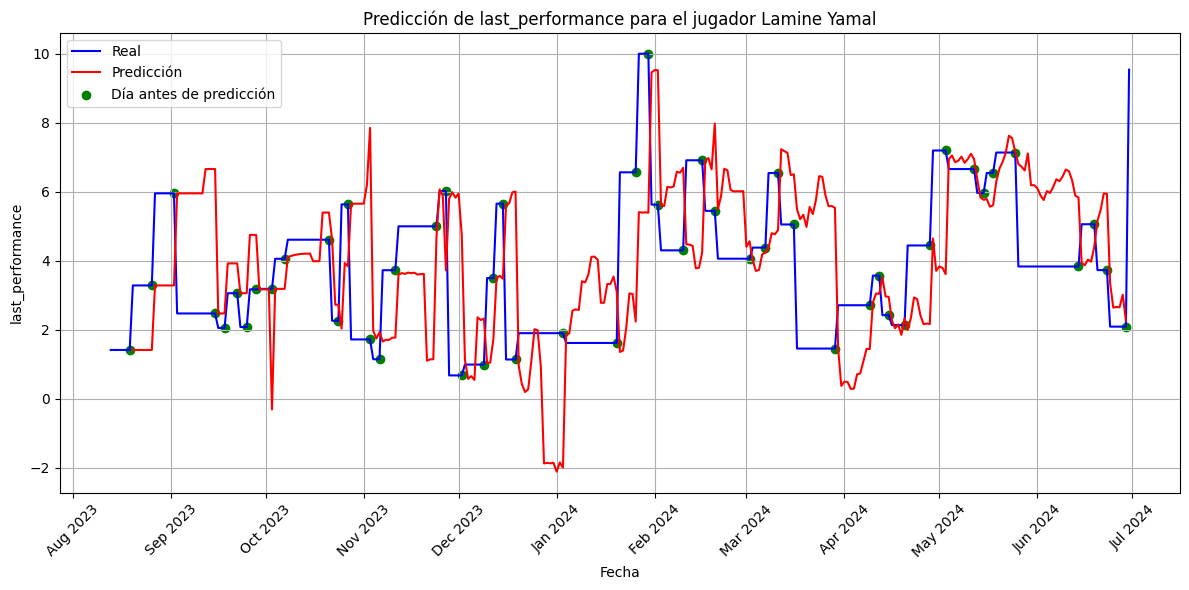

______Todos los días____________
Mean error todos: 1.993988869130046
Std error todos: 1.39230384012263
Min error todos: 0.009897583456620396
Max error todos: 6.133122787214593
Median error todos: 1.8708544606369886

______Días de partido___________
Mean error dia partido: 1.822735089156753
Std error dia partido: 1.39819843671807
Min error dia partido: 0.01433061939035607
Max error dia partido: 5.2085545802440185
Median error dia partido: 1.431191243674843

______Días antes de partido_____
Mean error dia antes partido: 1.9228386258514205
Std error dia antes partido: 1.4981136657903504
Min error dia antes partido: 0.0219475850374371
Max error dia antes partido: 6.133122787214593
Median error dia antes partido: 1.6551752384056497


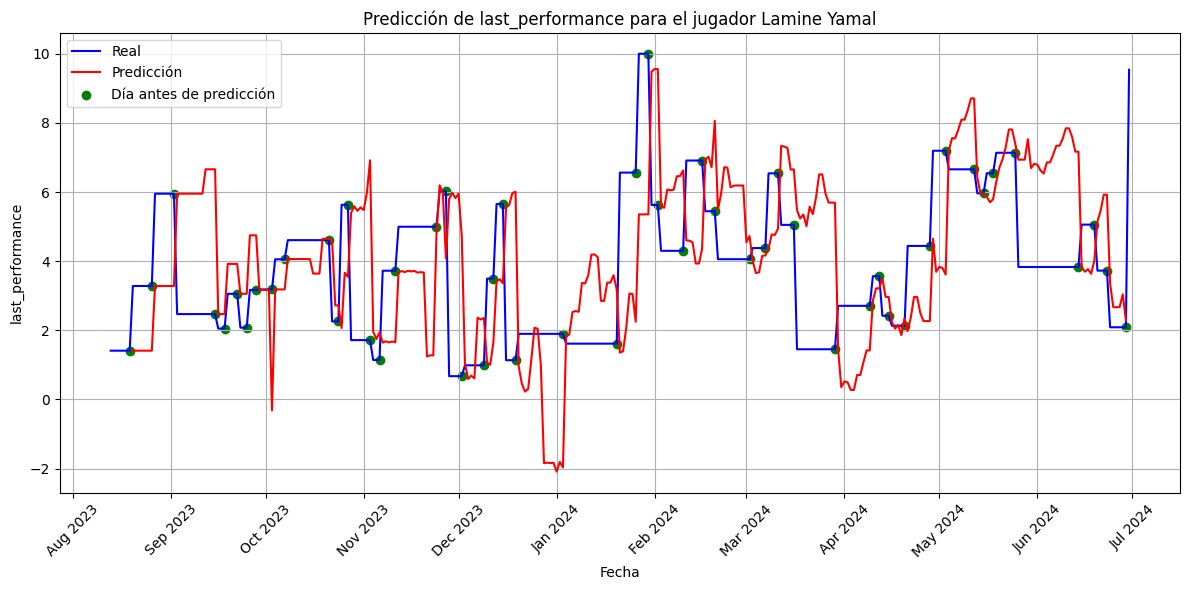

______Todos los días____________
Mean error todos: 2.076399975660003
Std error todos: 1.3892230556996852
Min error todos: 0.008185632732209847
Max error todos: 5.30803859086423
Median error todos: 1.8708544606369886

______Días de partido___________
Mean error dia partido: 1.825971105442801
Std error dia partido: 1.3864024798961168
Min error dia partido: 0.01433061939035607
Max error dia partido: 5.208539806151569
Median error dia partido: 1.4222653404512537

______Días antes de partido_____
Mean error dia antes partido: 1.9662724267769656
Std error dia antes partido: 1.4580993705271692
Min error dia antes partido: 0.008818933474133317
Max error dia antes partido: 5.199912282369766
Median error dia antes partido: 1.8499595121261636


In [37]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

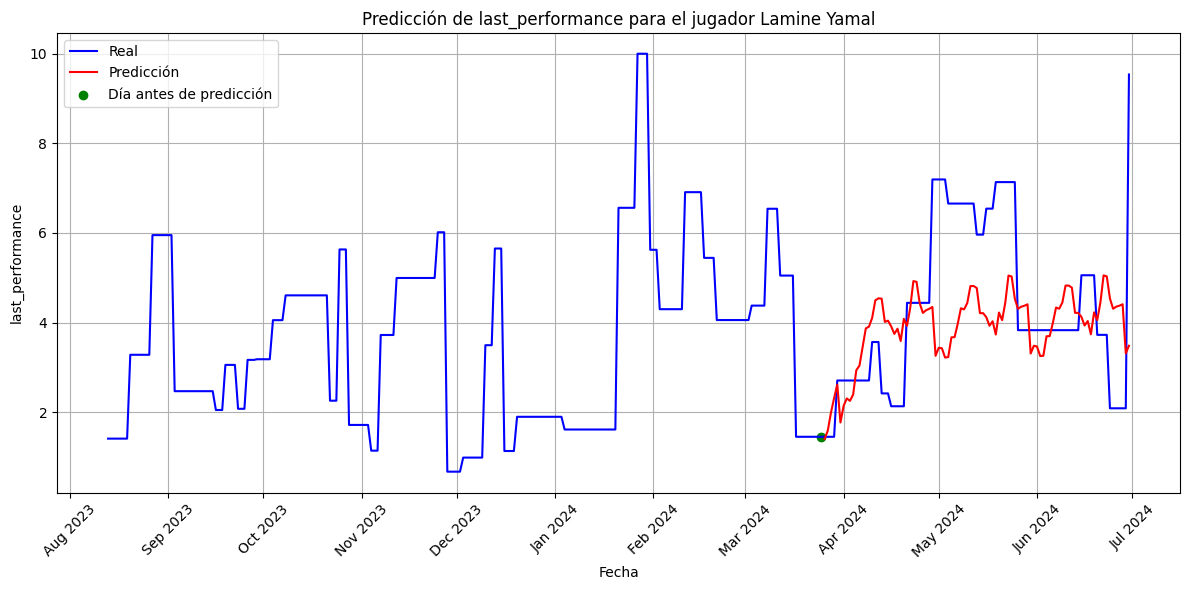

______Todos los días____________
Mean error todos: 1.4071229871745183
Std error todos: 1.1506758180147572
Min error todos: 0.00913003089042963
Max error todos: 6.05324181804718
Median error todos: 1.0221887019390072

______Días de partido___________
Mean error dia partido: 1.904076124088075
Std error dia partido: 1.5565811881148253
Min error dia partido: 0.09285674717675008
Max error dia partido: 6.05324181804718
Median error dia partido: 1.7816791018094116

______Días antes de partido_____
Mean error dia antes partido: 1.544611627339284
Std error dia antes partido: 0.9369827489155687
Min error dia antes partido: 0.1332525904186408
Max error dia antes partido: 3.9737060450369297
Median error dia antes partido: 1.3046737646637854


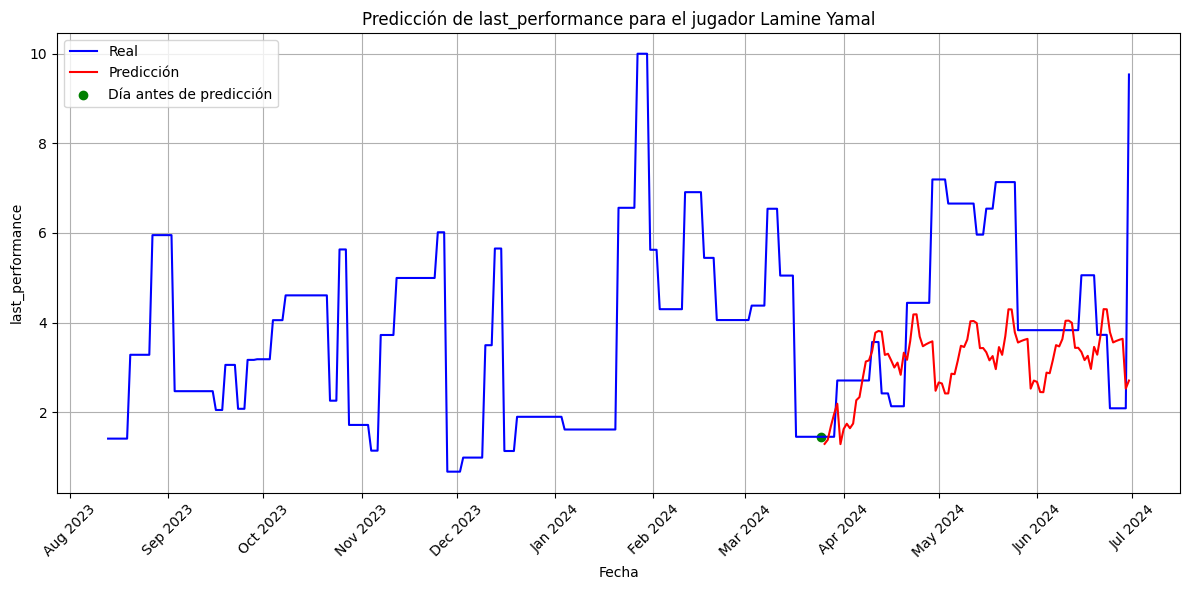

______Todos los días____________
Mean error todos: 1.5933328983167288
Std error todos: 1.432095544728566
Min error todos: 0.024995950350775953
Max error todos: 6.829522757794187
Median error todos: 1.0646855229260441

______Días de partido___________
Mean error dia partido: 2.170200249107256
Std error dia partido: 1.8174614182492512
Min error dia partido: 0.20176453577351827
Max error dia partido: 6.829522757794187
Median error dia partido: 1.6981114336612149

______Días antes de partido_____
Mean error dia antes partido: 1.5829902770096882
Std error dia antes partido: 1.3491854339743816
Min error dia antes partido: 0.24698840209511452
Max error dia antes partido: 4.775553383099901
Median error dia antes partido: 0.888295556526403


In [35]:

config = {
    'order': (1,0,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Lewandowski

In [38]:
jugador = 'Lewandowski'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

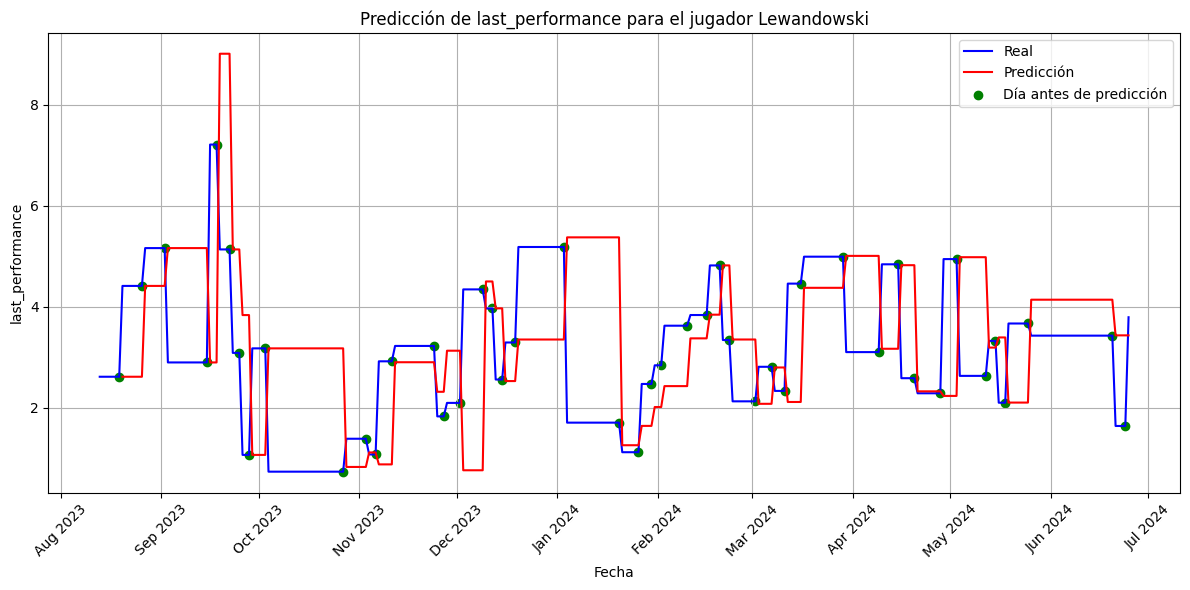

______Todos los días____________
Mean error todos: 1.574022526524069
Std error todos: 1.0501392871329978
Min error todos: 0.03846441773701059
Max error todos: 4.318874880524326
Median error todos: 1.5675247116412132

______Días de partido___________
Mean error dia partido: 1.4837868097072073
Std error dia partido: 1.0651100308232082
Min error dia partido: 0.03846441773701059
Max error dia partido: 4.318874880524326
Median error dia partido: 1.293858821773198

______Días antes de partido_____
Mean error dia antes partido: 1.5093464151764044
Std error dia antes partido: 1.0634116517173575
Min error dia antes partido: 0.03846441773701059
Max error dia antes partido: 4.318874880524326
Median error dia antes partido: 1.3524487499626556


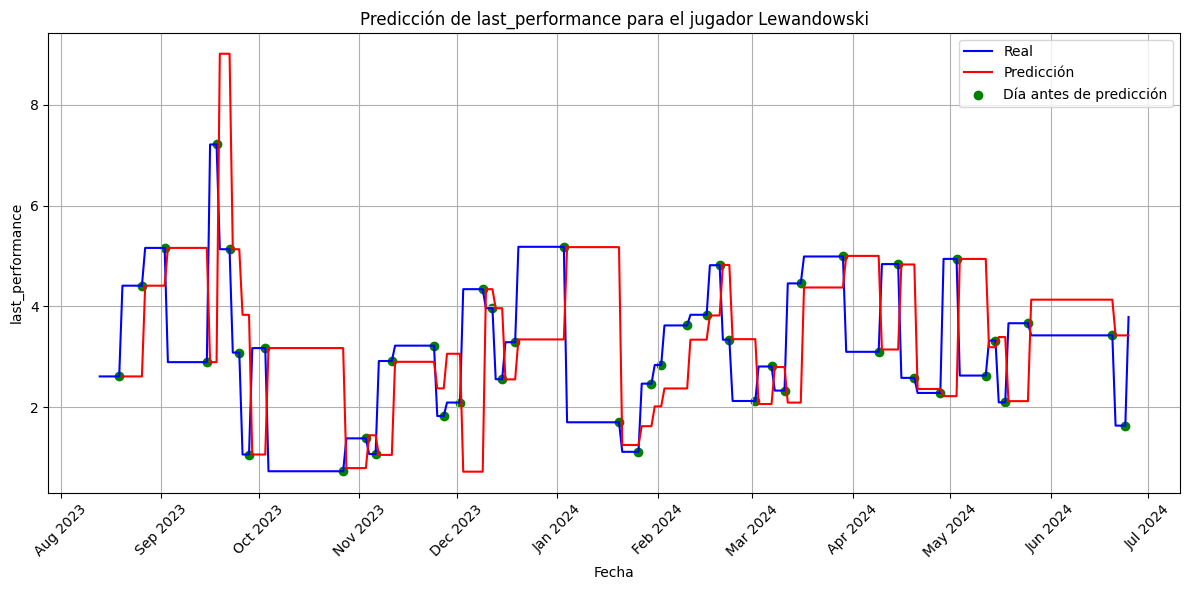

______Todos los días____________
Mean error todos: 1.5651844305982803
Std error todos: 1.024045962076121
Min error todos: 0.0787633184254024
Max error todos: 4.318874880524326
Median error todos: 1.5458420356795126

______Días de partido___________
Mean error dia partido: 1.483581878530547
Std error dia partido: 1.047495575791188
Min error dia partido: 0.0787633184254024
Max error dia partido: 4.318874880524326
Median error dia partido: 1.2961484234457998

______Días antes de partido_____
Mean error dia antes partido: 1.5090034840782307
Std error dia antes partido: 1.0455155672716456
Min error dia antes partido: 0.0787633184254024
Max error dia antes partido: 4.318874880524326
Median error dia antes partido: 1.3521004510566406


In [42]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

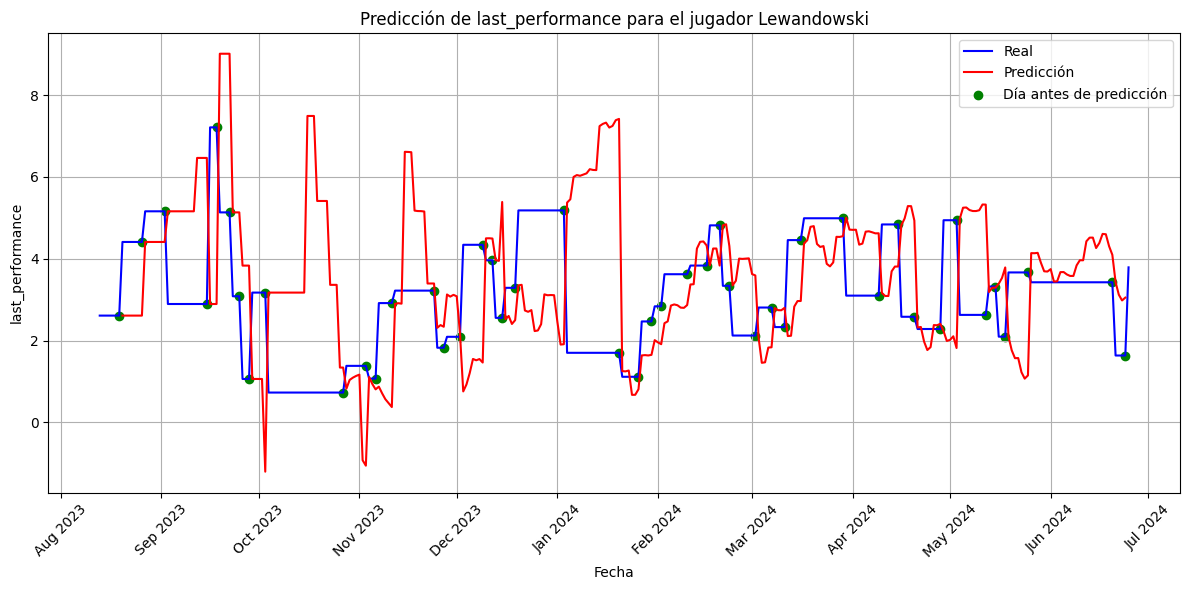

______Todos los días____________
Mean error todos: 1.8078912710909274
Std error todos: 1.391243926941667
Min error todos: 0.017666754195039935
Max error todos: 6.762979429975866
Median error todos: 1.5905530244245991

______Días de partido___________
Mean error dia partido: 1.5093464151764044
Std error dia partido: 1.0634116517173575
Min error dia partido: 0.03846441773701059
Max error dia partido: 4.318874880524326
Median error dia partido: 1.3524487499626556

______Días antes de partido_____
Mean error dia antes partido: 1.6689453716446203
Std error dia antes partido: 1.3505113416369736
Min error dia antes partido: 0.02793063955455466
Max error dia antes partido: 5.718905660833418
Median error dia antes partido: 1.22236312146726


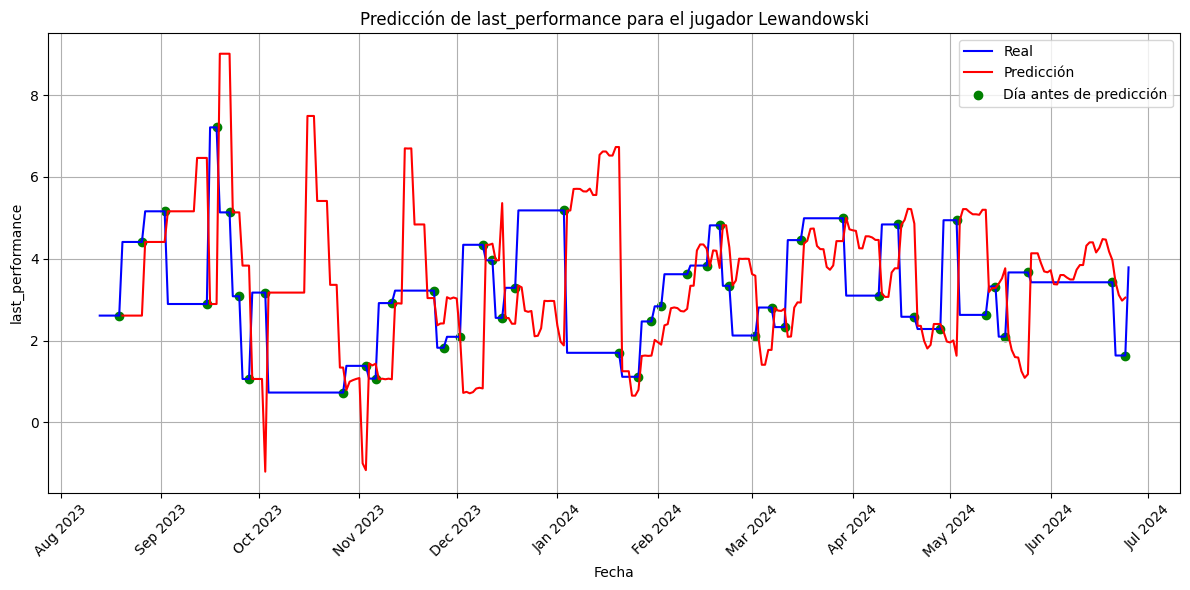

______Todos los días____________
Mean error todos: 1.7809061914601476
Std error todos: 1.3418723901007972
Min error todos: 0.03137252693250314
Max error todos: 6.762973233337886
Median error todos: 1.5645235372163764

______Días de partido___________
Mean error dia partido: 1.5090034840782307
Std error dia partido: 1.0455155672716456
Min error dia partido: 0.0787633184254024
Max error dia partido: 4.318874880524326
Median error dia partido: 1.3521004510566406

______Días antes de partido_____
Mean error dia antes partido: 1.6565938587912266
Std error dia antes partido: 1.3182180367388576
Min error dia antes partido: 0.03137252693250314
Max error dia antes partido: 5.031349921225494
Median error dia antes partido: 1.2170601461986896


In [43]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

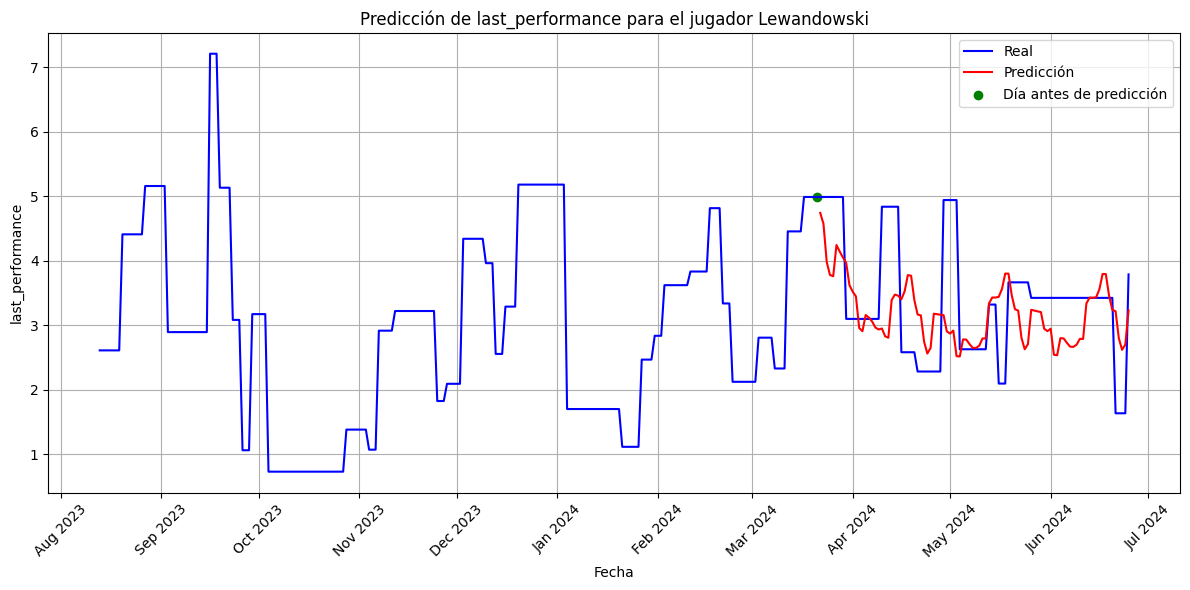

______Todos los días____________
Mean error todos: 0.6907371560083176
Std error todos: 0.5918318178116512
Min error todos: 0.002001286444252237
Max error todos: 2.4221109503776272
Median error todos: 0.5908176776488181

______Días de partido___________
Mean error dia partido: 0.8488373184675
Std error dia partido: 0.6464395541567572
Min error dia partido: 0.018469183498492914
Max error dia partido: 1.8892571560394567
Median error dia partido: 0.8454556608134054

______Días antes de partido_____
Mean error dia antes partido: 0.8988442940077882
Std error dia antes partido: 0.6740717107841603
Min error dia antes partido: 0.10870839778817931
Max error dia antes partido: 2.4221109503776272
Median error dia antes partido: 0.9100386072208972


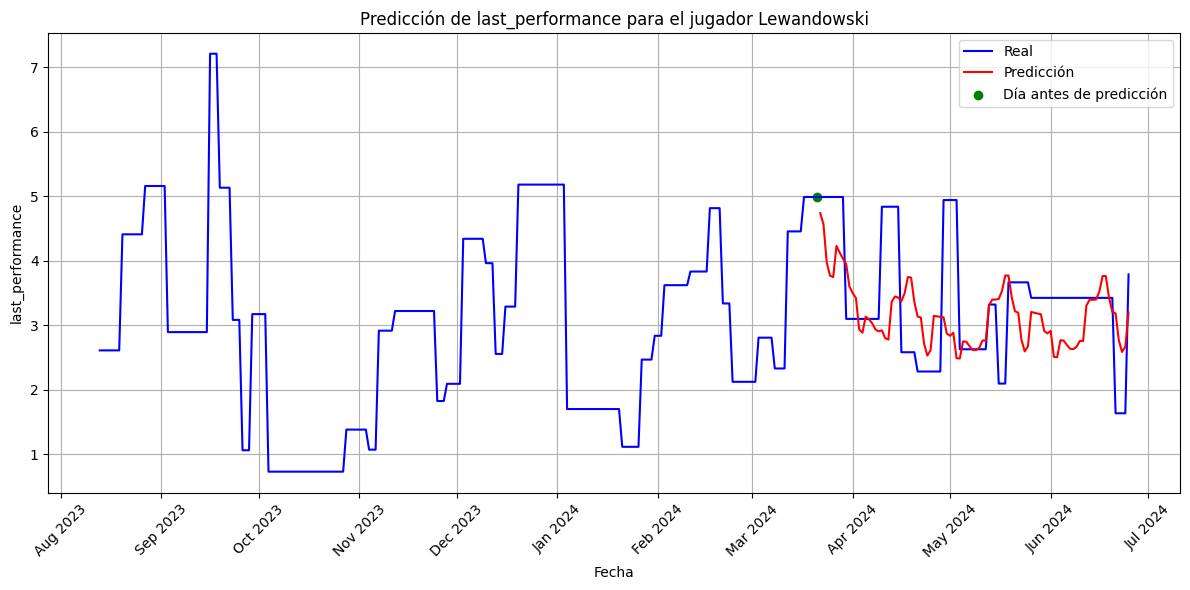

______Todos los días____________
Mean error todos: 0.6940922603715073
Std error todos: 0.5969391058547928
Min error todos: 0.000194408571672966
Max error todos: 2.4542962702114823
Median error todos: 0.6239177348182381

______Días de partido___________
Mean error dia partido: 0.8472077022039449
Std error dia partido: 0.646007931159469
Min error dia partido: 0.0139063909509618
Max error dia partido: 1.9182996510185437
Median error dia partido: 0.8206875105715754

______Días antes de partido_____
Mean error dia antes partido: 0.8974051012583376
Std error dia antes partido: 0.6801132340112579
Min error dia antes partido: 0.0767877586524639
Max error dia antes partido: 2.4542962702114823
Median error dia antes partido: 0.9023189286067825


In [ ]:

config = {
    'order': (1,0,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Miguel Gutiérrez

In [48]:
jugador = 'Miguel Gutiérrez'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

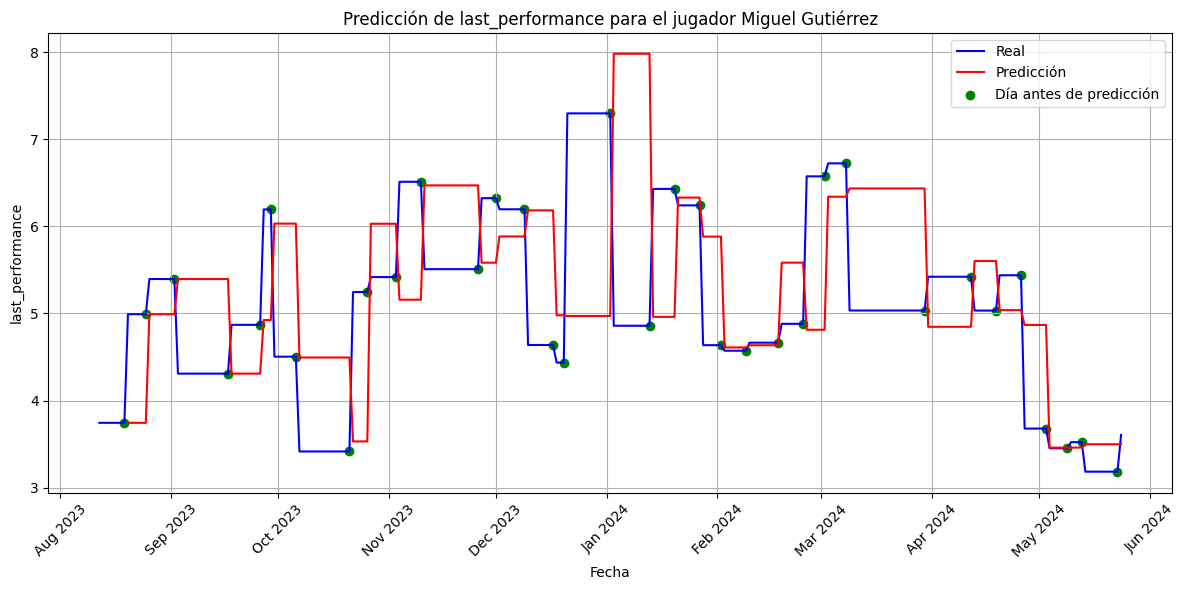

______Todos los días____________
Mean error todos: 1.0017903233194858
Std error todos: 0.7221423570628109
Min error todos: 0.007399454855493648
Max error todos: 3.122759545113433
Median error todos: 0.9615473710623572

______Días de partido___________
Mean error dia partido: 0.904408862185901
Std error dia partido: 0.7039374812780596
Min error dia partido: 0.007399454855493648
Max error dia partido: 3.122759545113433
Median error dia partido: 0.7216199613361884

______Días antes de partido_____
Mean error dia antes partido: 0.928580851309327
Std error dia antes partido: 0.7004843216586042
Min error dia antes partido: 0.007399454855493648
Max error dia antes partido: 3.122759545113433
Median error dia antes partido: 0.7410000789950999


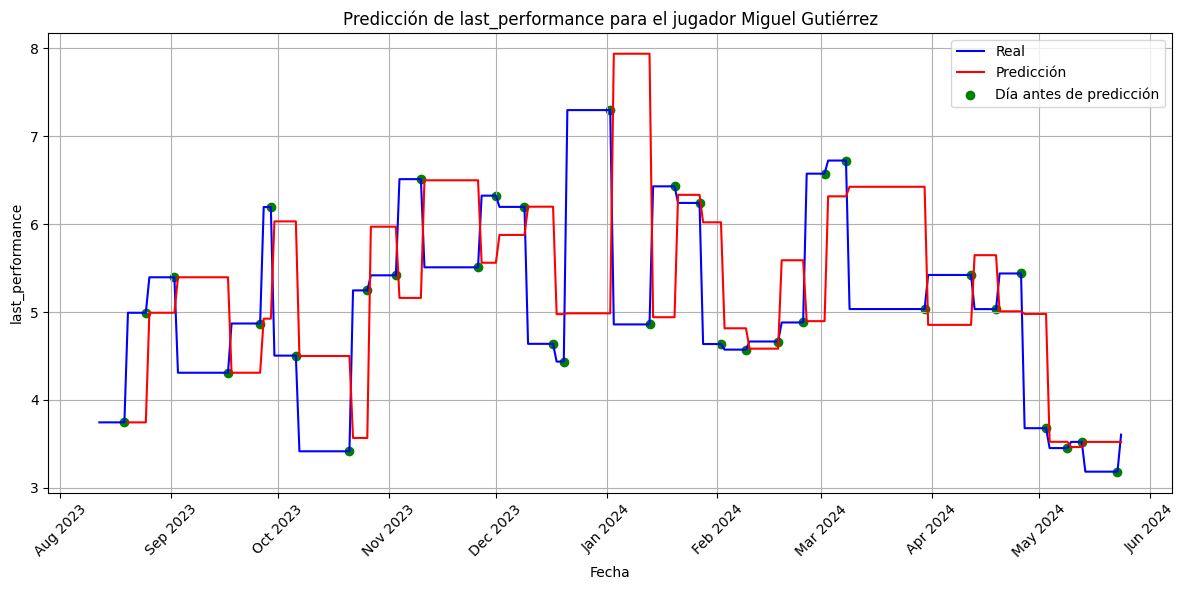

______Todos los días____________
Mean error todos: 1.0147205933626269
Std error todos: 0.7037844935326607
Min error todos: 0.05859586634560987
Max error todos: 3.0793900299931085
Median error todos: 0.990072937668173

______Días de partido___________
Mean error dia partido: 0.9194461046436103
Std error dia partido: 0.6878074506621514
Min error dia partido: 0.05859586634560987
Max error dia partido: 3.0793900299931085
Median error dia partido: 0.735526367182989

______Días antes de partido_____
Mean error dia antes partido: 0.9447936904845027
Std error dia antes partido: 0.6823267659201304
Min error dia antes partido: 0.05859586634560987
Max error dia antes partido: 3.0793900299931085
Median error dia antes partido: 0.7631856653339781


In [52]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

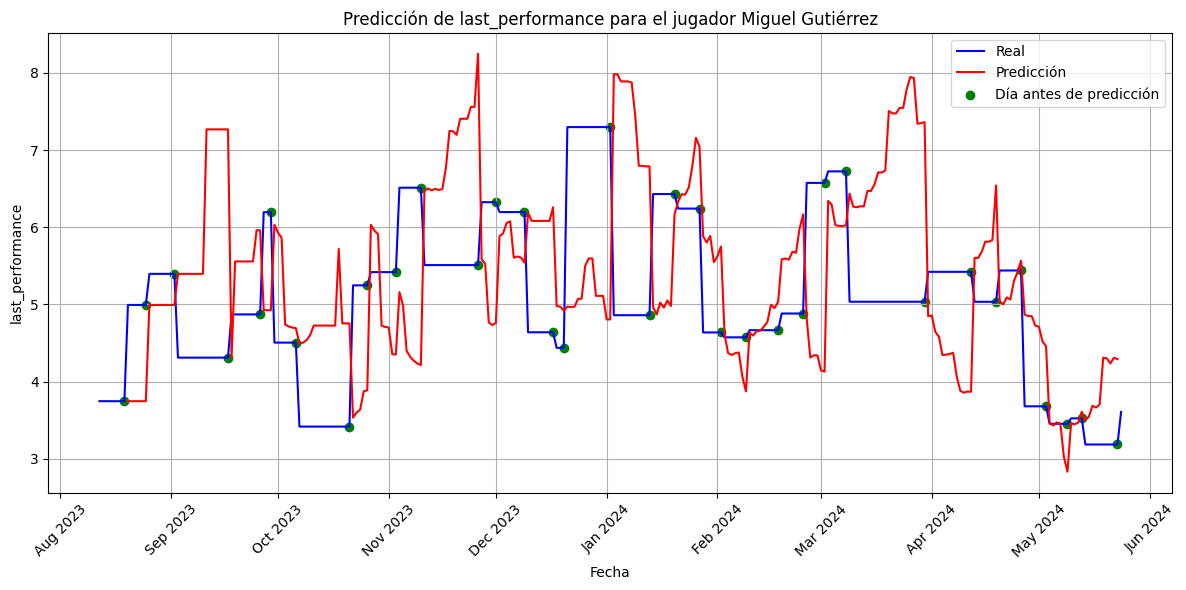

______Todos los días____________
Mean error todos: 1.205876392709368
Std error todos: 0.7895200938864768
Min error todos: 0.001910530423277379
Max error todos: 3.122759545113433
Median error todos: 1.1155487680840117

______Días de partido___________
Mean error dia partido: 0.928580851309327
Std error dia partido: 0.7004843216586042
Min error dia partido: 0.007399454855493648
Max error dia partido: 3.122759545113433
Median error dia partido: 0.7410000789950999

______Días antes de partido_____
Mean error dia antes partido: 1.2269030855371865
Std error dia antes partido: 0.7767943118766225
Min error dia antes partido: 0.08601795502133935
Max error dia antes partido: 2.958423111051414
Median error dia antes partido: 1.1131896346262549


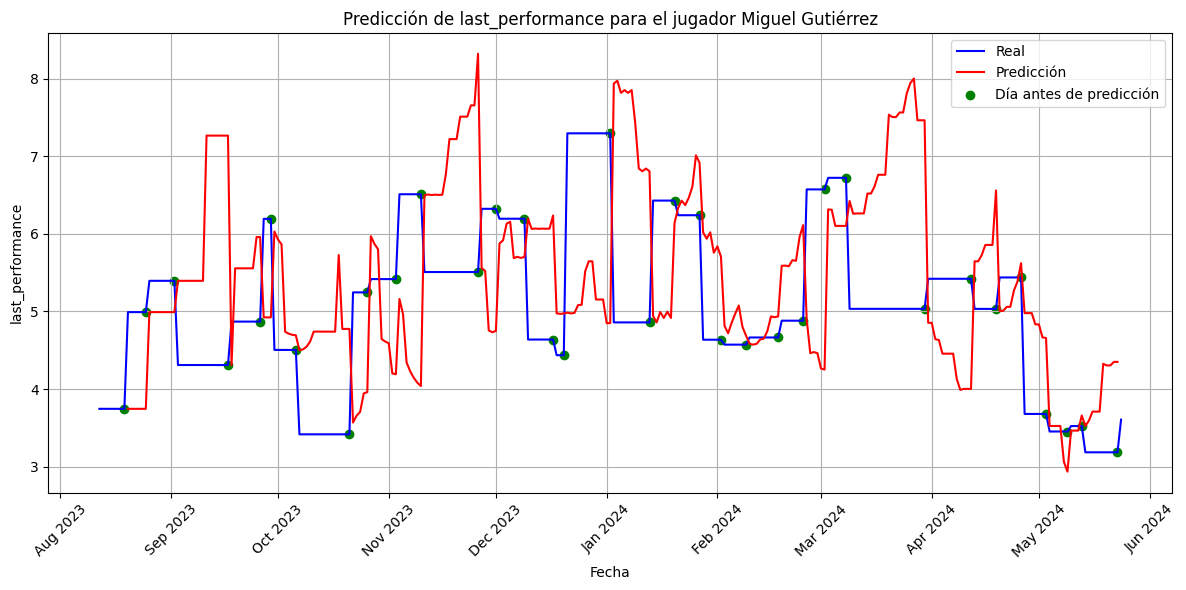

______Todos los días____________
Mean error todos: 1.2101996515507887
Std error todos: 0.7927681639606308
Min error todos: 0.01493365069146968
Max error todos: 3.115693948763643
Median error todos: 1.1661154935341131

______Días de partido___________
Mean error dia partido: 0.9447936904845027
Std error dia partido: 0.6823267659201304
Min error dia partido: 0.05859586634560987
Max error dia partido: 3.0793900299931085
Median error dia partido: 0.7631856653339781

______Días antes de partido_____
Mean error dia antes partido: 1.208583566500201
Std error dia antes partido: 0.807059626527669
Min error dia antes partido: 0.11722272826277003
Max error dia antes partido: 2.958423111051414
Median error dia antes partido: 1.2271023353124688


In [53]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

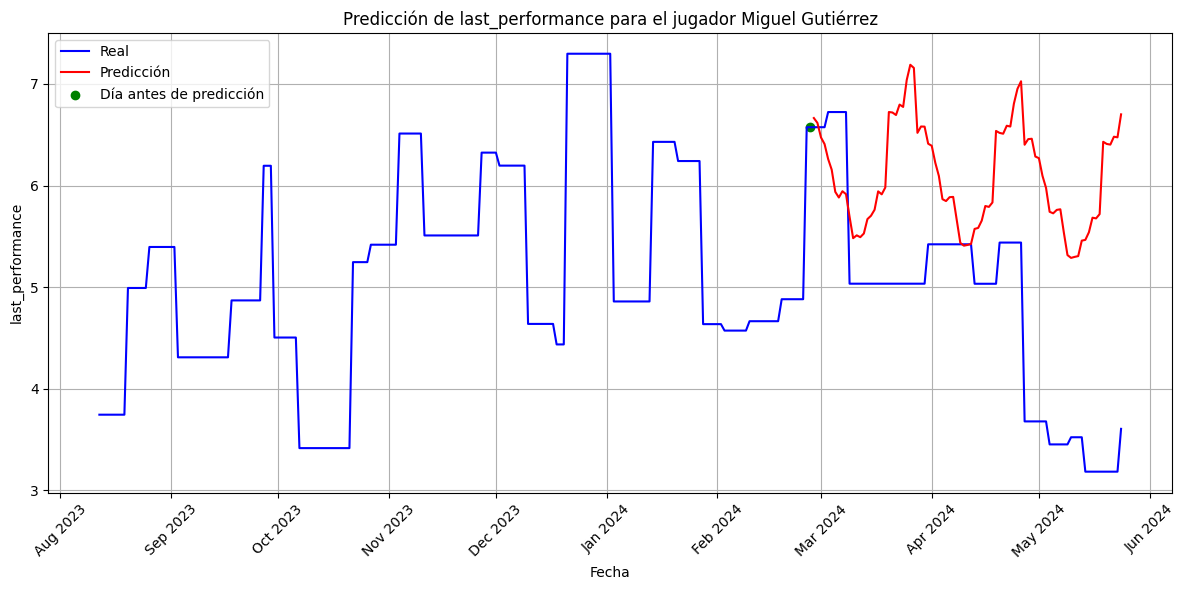

______Todos los días____________
Mean error todos: 1.3956743331463108
Std error todos: 0.9346059818435795
Min error todos: 0.0036020336998277003
Max error todos: 3.296714177538743
Median error todos: 1.149711005241759

______Días de partido___________
Mean error dia partido: 1.588387559794303
Std error dia partido: 0.9171010286536622
Min error dia partido: 0.4622170794808369
Max error dia partido: 3.0952053262856154
Median error dia partido: 1.4222835979226771

______Días antes de partido_____
Mean error dia antes partido: 1.500165456297578
Std error dia antes partido: 0.9311939614388035
Min error dia antes partido: 0.0036020336998277003
Max error dia antes partido: 3.2905634811740003
Median error dia antes partido: 1.5666975166500237


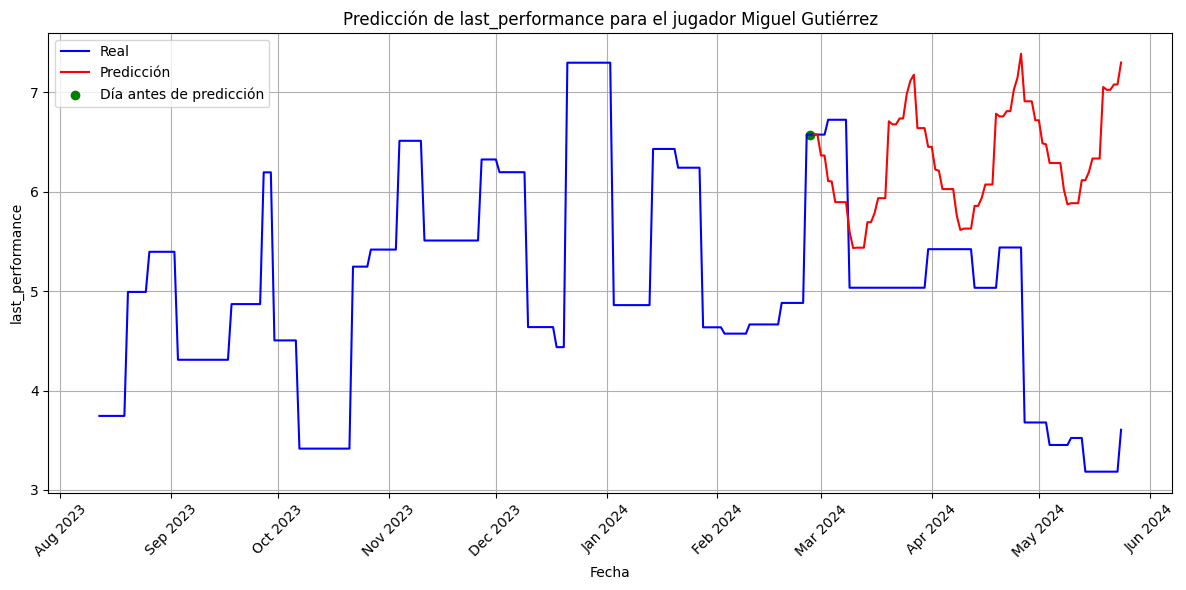

______Todos los días____________
Mean error todos: 1.6361965719058034
Std error todos: 1.1219327935665038
Min error todos: 0.0014160284336535156
Max error todos: 3.8945099014583477
Median error todos: 1.371120459508247

______Días de partido___________
Mean error dia partido: 1.9404127566810108
Std error dia partido: 1.1319690766354158
Min error dia partido: 0.5629391526964698
Max error dia partido: 3.6933526767787503
Median error dia partido: 1.839996442575685

______Días antes de partido_____
Mean error dia antes partido: 1.8256659002428743
Std error dia antes partido: 1.116234951081041
Min error dia antes partido: 0.20706145646210672
Max error dia antes partido: 3.894509901441807
Median error dia antes partido: 1.8500134607520855


In [50]:

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Mikel Merino

In [60]:
jugador = 'Mikel Merino'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

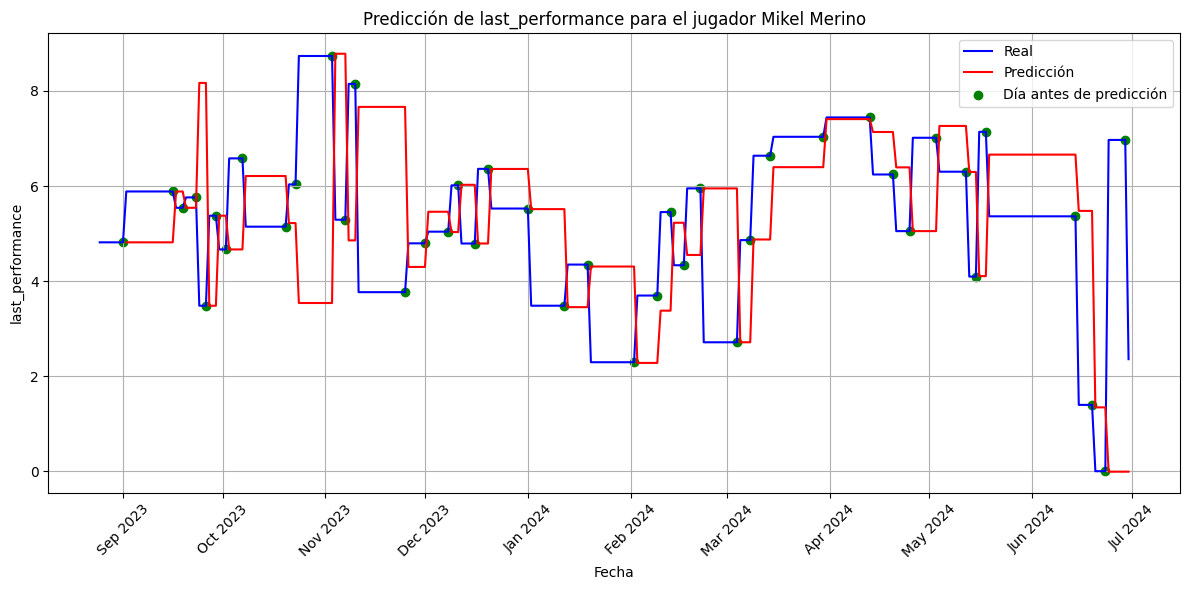

______Todos los días____________
Mean error todos: 1.8005167561498514
Std error todos: 1.4376835835903312
Min error todos: 0.03522673316821656
Max error todos: 6.976910928689424
Median error todos: 1.2977645760803709

______Días de partido___________
Mean error dia partido: 1.8840212790976212
Std error dia partido: 1.4434120997648632
Min error dia partido: 0.03522673316821656
Max error dia partido: 6.976910928689424
Median error dia partido: 1.408857338277143

______Días antes de partido_____
Mean error dia antes partido: 1.8722858766437773
Std error dia antes partido: 1.4589276323713352
Min error dia antes partido: 0.03522673316821656
Max error dia antes partido: 6.976910928689424
Median error dia antes partido: 1.4005338729607635


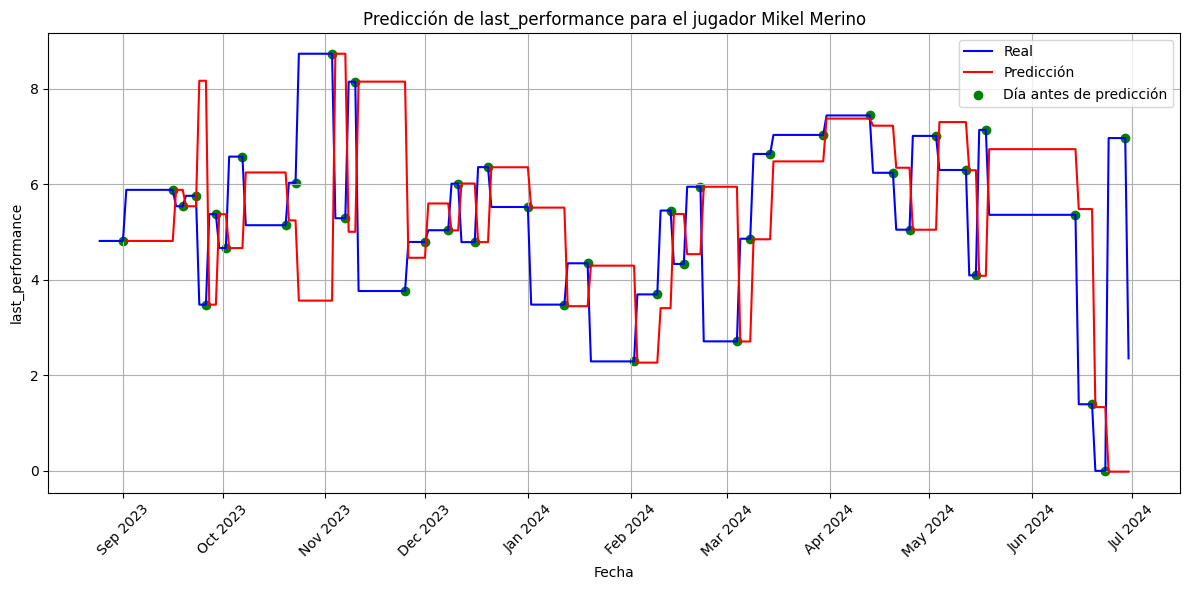

______Todos los días____________
Mean error todos: 1.8316988837529702
Std error todos: 1.4688537821978844
Min error todos: 0.0652342918349742
Max error todos: 6.9836092181943
Median error todos: 1.3746281631769808

______Días de partido___________
Mean error dia partido: 1.8970185536569548
Std error dia partido: 1.4534507743502514
Min error dia partido: 0.0652342918349742
Max error dia partido: 6.9836092181943
Median error dia partido: 1.4197644723378677

______Días antes de partido_____
Mean error dia antes partido: 1.885436784984927
Std error dia antes partido: 1.4691528992949487
Min error dia antes partido: 0.0652342918349742
Max error dia antes partido: 6.9836092181943
Median error dia antes partido: 1.4112764812303222


In [55]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

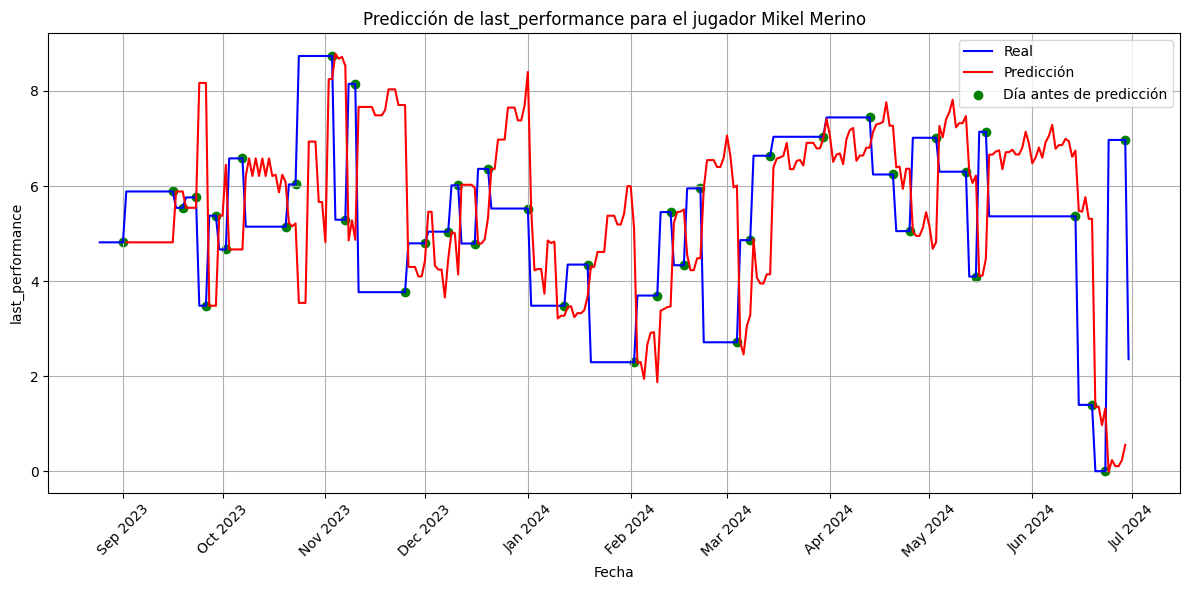

______Todos los días____________
Mean error todos: 1.8150737473923144
Std error todos: 1.3551145566324492
Min error todos: 0.03522673316821656
Max error todos: 6.976910928689424
Median error todos: 1.3870516386155827

______Días de partido___________
Mean error dia partido: 1.8722858766437773
Std error dia partido: 1.4589276323713352
Min error dia partido: 0.03522673316821656
Max error dia partido: 6.976910928689424
Median error dia partido: 1.4005338729607635

______Días antes de partido_____
Mean error dia antes partido: 1.810081669432822
Std error dia antes partido: 1.3289453500073198
Min error dia antes partido: 0.04454492249714015
Max error dia antes partido: 6.412392021966933
Median error dia antes partido: 1.4685421494030226


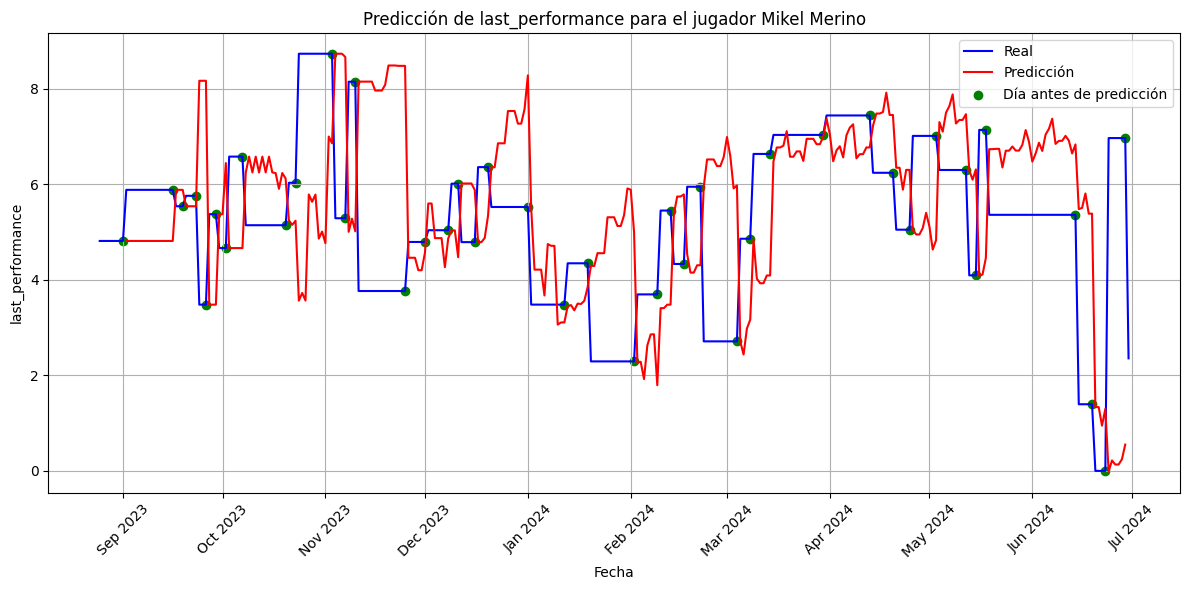

______Todos los días____________
Mean error todos: 1.8539203805712412
Std error todos: 1.4150823074677101
Min error todos: 0.03814142182389446
Max error todos: 6.9836092181943
Median error todos: 1.411354540208781

______Días de partido___________
Mean error dia partido: 1.885436784984927
Std error dia partido: 1.4691528992949487
Min error dia partido: 0.0652342918349742
Max error dia partido: 6.9836092181943
Median error dia partido: 1.4112764812303222

______Días antes de partido_____
Mean error dia antes partido: 1.8593839459693327
Std error dia antes partido: 1.3566281110675902
Min error dia antes partido: 0.03814142182389446
Max error dia antes partido: 6.416853391077316
Median error dia antes partido: 1.6439475615803865


In [56]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

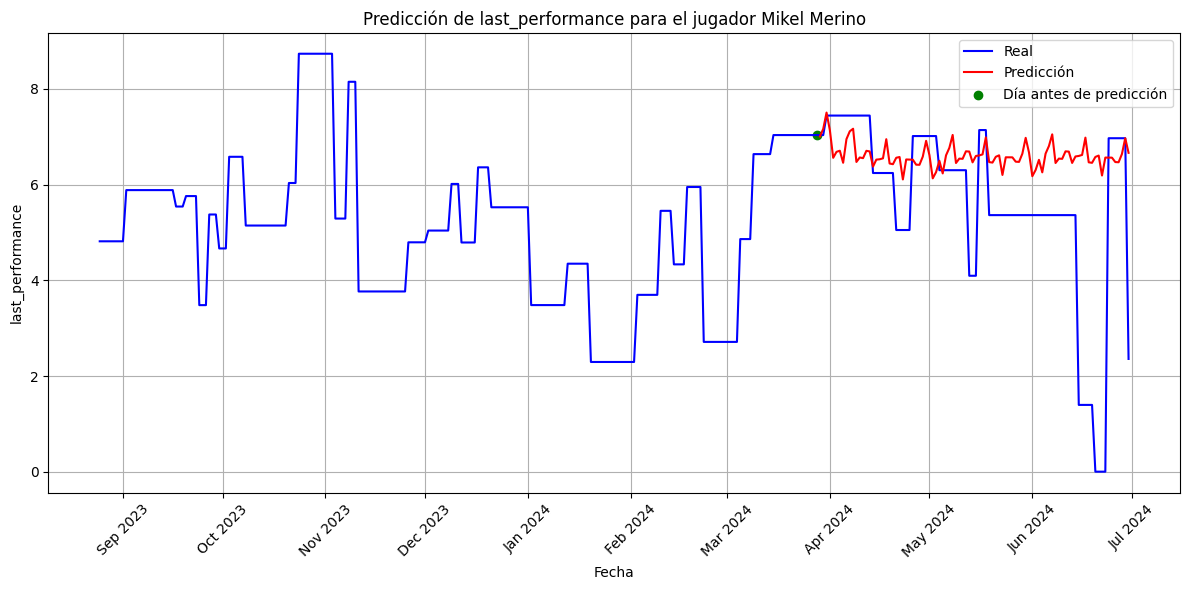

______Todos los días____________
Mean error todos: 1.3275672889075236
Std error todos: 1.5954625618622358
Min error todos: 0.0005213753238582086
Max error todos: 6.604936205951362
Median error todos: 0.8832062421809468

______Días de partido___________
Mean error dia partido: 1.9266847761755266
Std error dia partido: 2.1466910168394095
Min error dia partido: 0.06269663729819719
Max error dia partido: 6.576032163854023
Median error dia partido: 0.8190219365219513

______Días antes de partido_____
Mean error dia antes partido: 1.5988271720205578
Std error dia antes partido: 2.0264106244036197
Min error dia antes partido: 0.0005213753238582086
Max error dia antes partido: 6.56277720041294
Median error dia antes partido: 0.7513971506254671


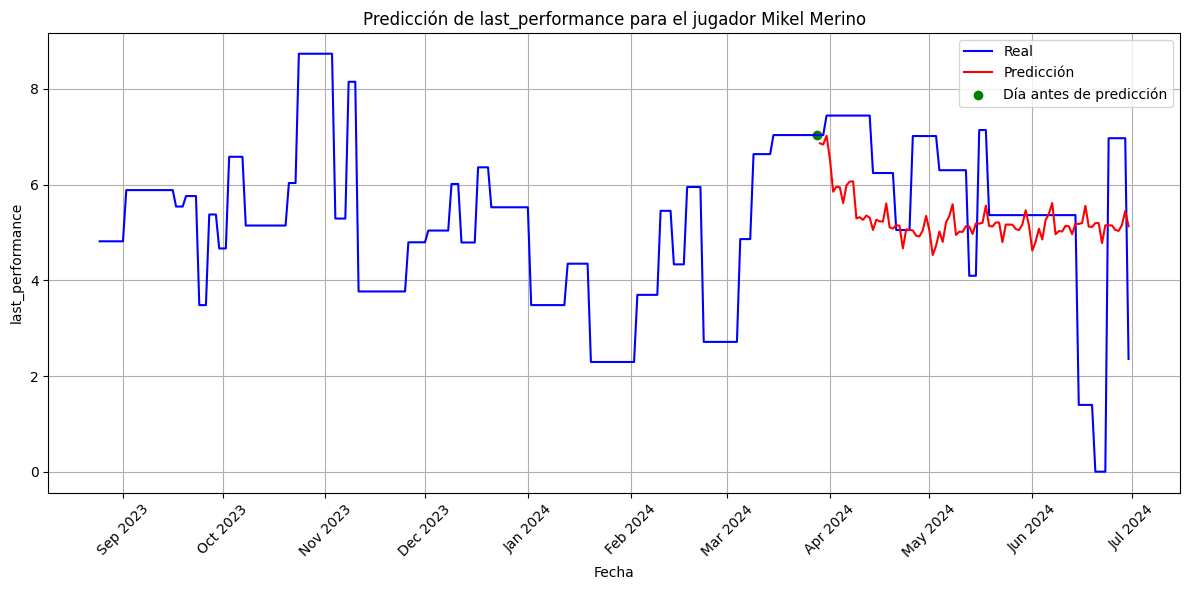

______Todos los días____________
Mean error todos: 1.3518774356068388
Std error todos: 1.2370595775299003
Min error todos: 0.001772805057250082
Max error todos: 5.1951626038306316
Median error todos: 1.148853596042351

______Días de partido___________
Mean error dia partido: 1.8128645251138613
Std error dia partido: 1.4414016657653101
Min error dia partido: 0.10406412761491168
Max error dia partido: 5.1951626038306316
Median error dia partido: 1.5509266370808032

______Días antes de partido_____
Mean error dia antes partido: 1.682851300989802
Std error dia antes partido: 1.4416554459934052
Min error dia antes partido: 0.001772805057250082
Max error dia antes partido: 5.148506334812412
Median error dia antes partido: 1.3448564369967198


In [66]:

config = {
    'order': (1,0,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Morata

In [67]:
jugador = 'Morata'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

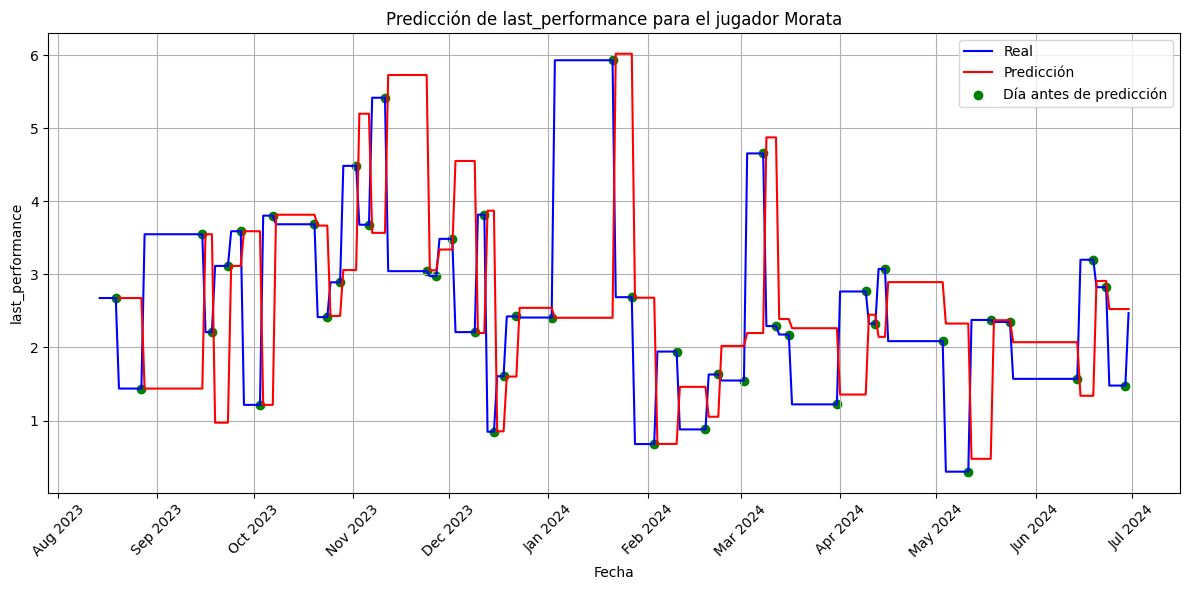

______Todos los días____________
Mean error todos: 1.4072286734800894
Std error todos: 1.0123307645926352
Min error todos: 0.023471581976939326
Max error todos: 3.5235806825239573
Median error todos: 1.2520343795977316

______Días de partido___________
Mean error dia partido: 1.318408710419522
Std error dia partido: 0.9653498844369153
Min error dia partido: 0.023471581976939326
Max error dia partido: 3.5235806825239573
Median error dia partido: 1.2520343795977316

______Días antes de partido_____
Mean error dia antes partido: 1.3471128555510397
Std error dia antes partido: 0.9570805589217021
Min error dia antes partido: 0.023471581976939326
Max error dia antes partido: 3.5235806825239573
Median error dia antes partido: 1.2577901657264277


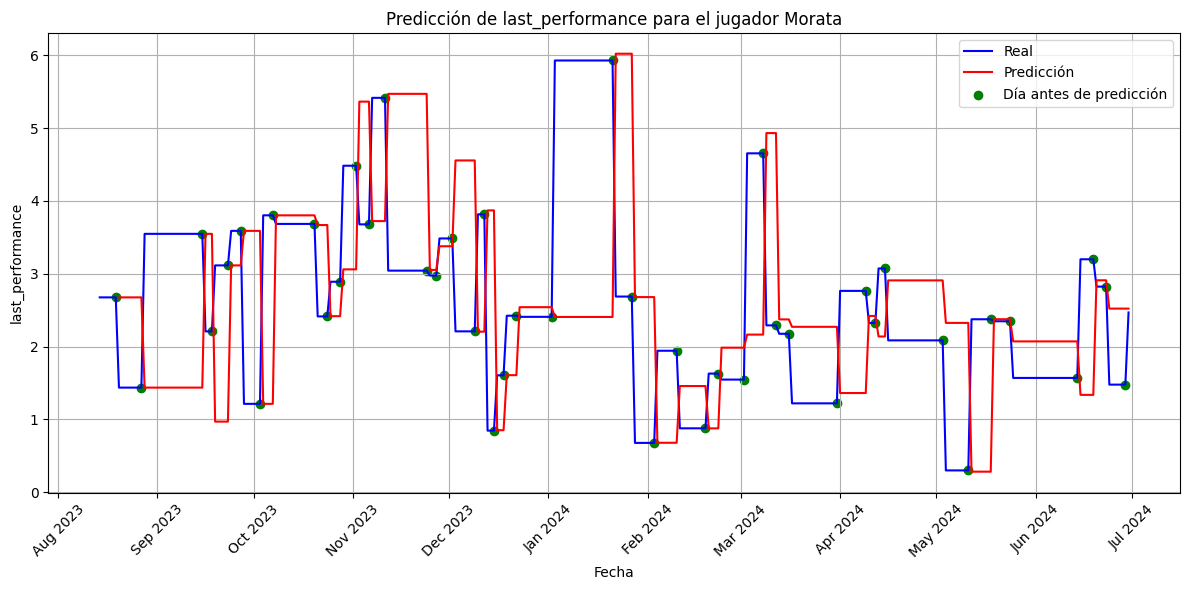

______Todos los días____________
Mean error todos: 1.402927389247251
Std error todos: 1.0041788780977579
Min error todos: 0.027944326362915106
Max error todos: 3.5217382836969575
Median error todos: 1.2547271481189504

______Días de partido___________
Mean error dia partido: 1.3208375583433245
Std error dia partido: 0.9633886430460412
Min error dia partido: 0.027944326362915106
Max error dia partido: 3.5217382836969575
Median error dia partido: 1.2547271481189504

______Días antes de partido_____
Mean error dia antes partido: 1.3496596501015916
Std error dia antes partido: 0.9548974695386349
Min error dia antes partido: 0.027944326362915106
Max error dia antes partido: 3.5217382836969575
Median error dia antes partido: 1.2591354224320148


In [69]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

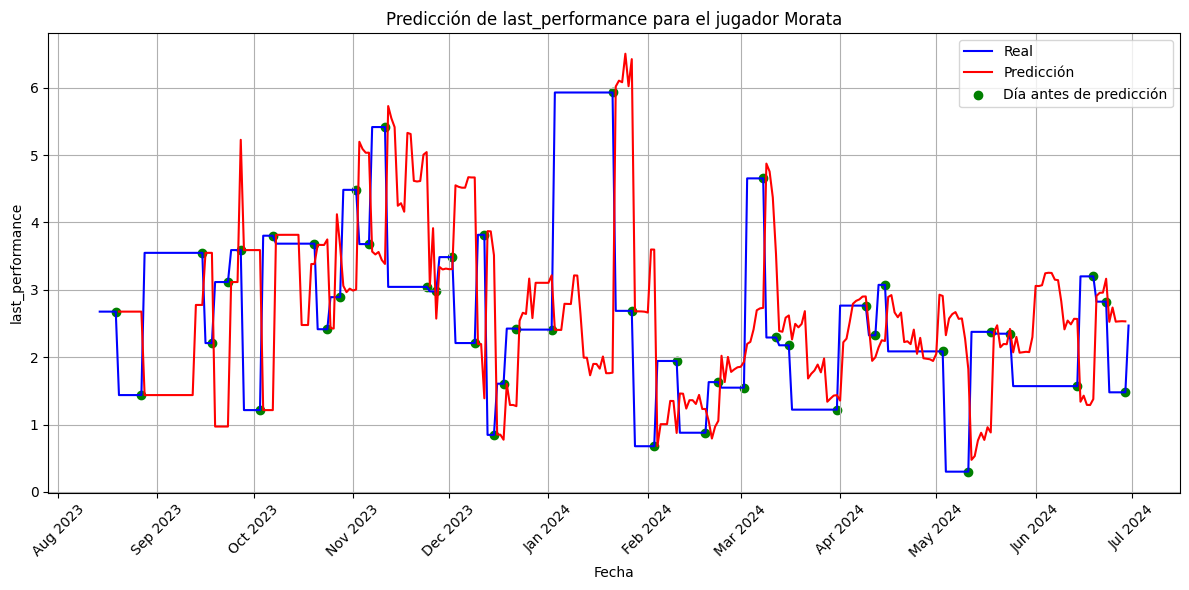

______Todos los días____________
Mean error todos: 1.3671096672837602
Std error todos: 1.025504640463882
Min error todos: 0.023471581976939326
Max error todos: 4.197992979257894
Median error todos: 1.2389058304128162

______Días de partido___________
Mean error dia partido: 1.3471128555510397
Std error dia partido: 0.9570805589217021
Min error dia partido: 0.023471581976939326
Max error dia partido: 3.5235806825239573
Median error dia partido: 1.2577901657264277

______Días antes de partido_____
Mean error dia antes partido: 1.334508355964983
Std error dia antes partido: 0.9571120514878791
Min error dia antes partido: 0.07138517921651788
Max error dia antes partido: 4.159022840798467
Median error dia antes partido: 1.1951956278337303


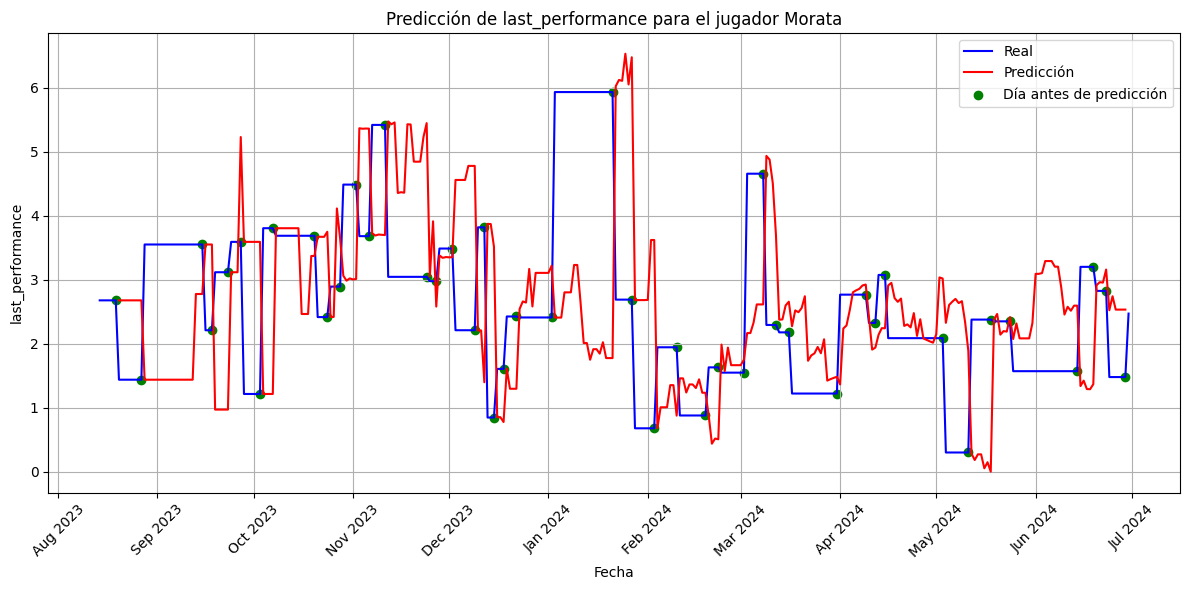

______Todos los días____________
Mean error todos: 1.3975978953216321
Std error todos: 1.0354374148386887
Min error todos: 0.004959628950217176
Max error todos: 4.180347526699483
Median error todos: 1.2389058304128162

______Días de partido___________
Mean error dia partido: 1.3496596501015916
Std error dia partido: 0.9548974695386349
Min error dia partido: 0.027944326362915106
Max error dia partido: 3.5217382836969575
Median error dia partido: 1.2591354224320148

______Días antes de partido_____
Mean error dia antes partido: 1.3889099648417707
Std error dia antes partido: 0.9760796705286381
Min error dia antes partido: 0.06652114762621597
Max error dia antes partido: 4.1544511857380995
Median error dia antes partido: 1.1838854072543112


In [70]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

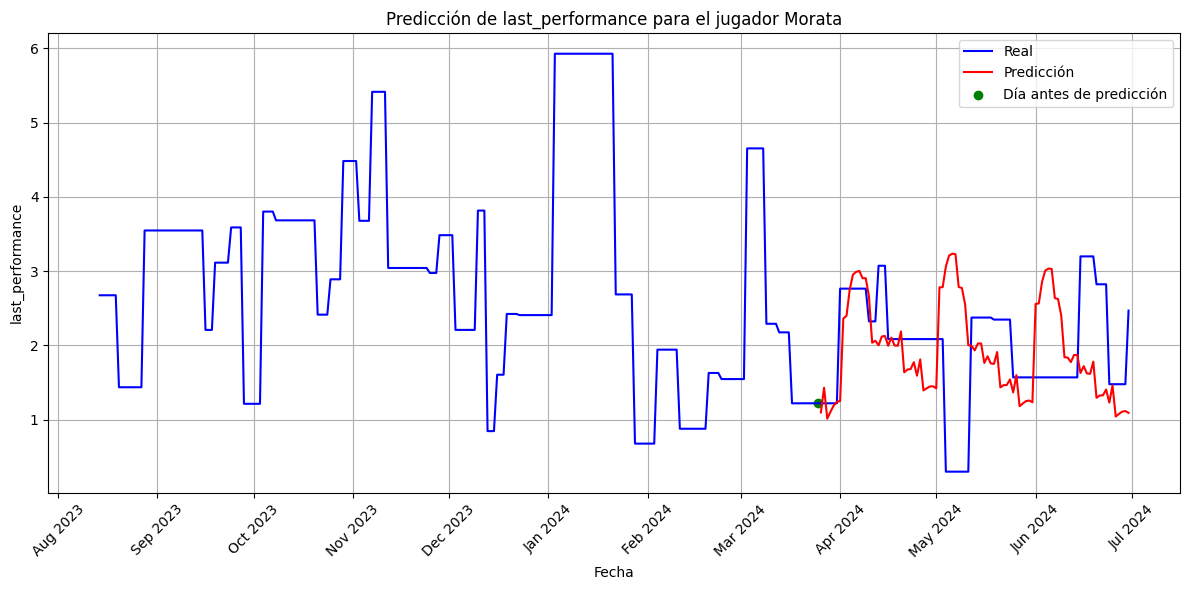

______Todos los días____________
Mean error todos: 0.7639470837316376
Std error todos: 0.7133896706971262
Min error todos: 0.013368824766410548
Max error todos: 2.935405055697038
Median error todos: 0.44163210162213584

______Días de partido___________
Mean error dia partido: 0.9734986303583142
Std error dia partido: 0.7707336632403877
Min error dia partido: 0.09026582423315377
Max error dia partido: 2.762691443067307
Median error dia partido: 0.8345249597653803

______Días antes de partido_____
Mean error dia antes partido: 0.7244433457778631
Std error dia antes partido: 0.5282457813452563
Min error dia antes partido: 0.02040011182257495
Max error dia antes partido: 1.7034718629395313
Median error dia antes partido: 0.6584725983851538


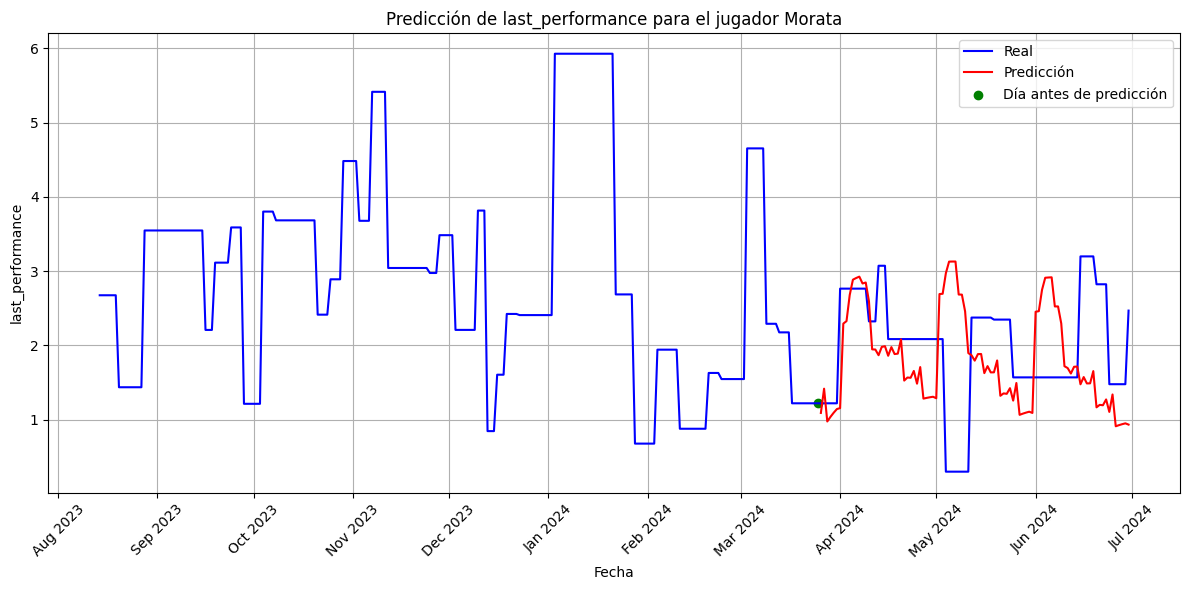

______Todos los días____________
Mean error todos: 0.8103259012426733
Std error todos: 0.691927424048285
Min error todos: 0.0032247077817562086
Max error todos: 2.8301392852891847
Median error todos: 0.566531195738288

______Días de partido___________
Mean error dia partido: 1.0668629626049277
Std error dia partido: 0.7484364327120205
Min error dia partido: 0.2245780914248927
Max error dia partido: 2.6730388746243987
Median error dia partido: 0.9575854337371809

______Días antes de partido_____
Mean error dia antes partido: 0.771727667256957
Std error dia antes partido: 0.547441221531791
Min error dia antes partido: 0.07763879003521112
Max error dia antes partido: 1.5968730028089755
Median error dia antes partido: 0.6743578591045806


In [77]:

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Nico Williams

In [78]:
jugador = 'Nico Williams'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

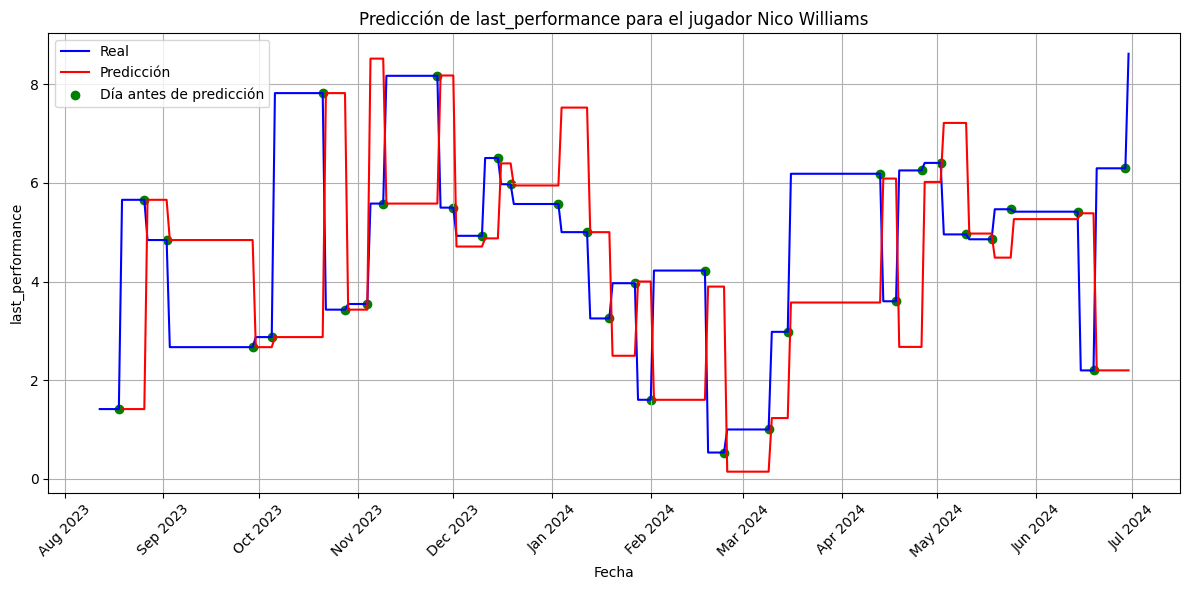

______Todos los días____________
Mean error todos: 2.069998783606161
Std error todos: 1.411359410903516
Min error todos: 0.11446907286877694
Max error todos: 6.420301078323626
Median error todos: 2.2605090254454216

______Días de partido___________
Mean error dia partido: 2.143890591494521
Std error dia partido: 1.5630179981631087
Min error dia partido: 0.11446907286877694
Max error dia partido: 6.420301078323626
Median error dia partido: 2.2605090254454216

______Días antes de partido_____
Mean error dia antes partido: 2.0102527637811116
Std error dia antes partido: 1.389251786095972
Min error dia antes partido: 0.11446907286877694
Max error dia antes partido: 4.946975558691005
Median error dia antes partido: 2.2161176960097717


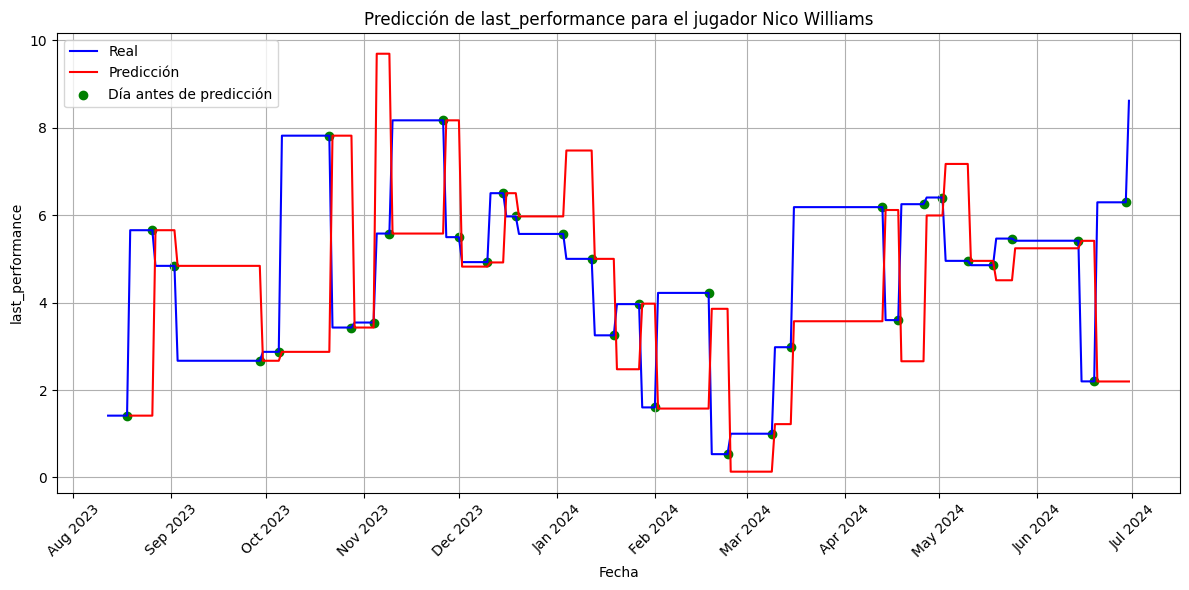

______Todos los días____________
Mean error todos: 2.0888115237092397
Std error todos: 1.430038821775232
Min error todos: 0.09896565900368426
Max error todos: 6.42341121491638
Median error todos: 2.218067312644923

______Días de partido___________
Mean error dia partido: 2.1788220705651495
Std error dia partido: 1.5936901596361552
Min error dia partido: 0.09896565900368426
Max error dia partido: 6.42341121491638
Median error dia partido: 2.218067312644923

______Días antes de partido_____
Mean error dia antes partido: 2.0461786598041733
Std error dia antes partido: 1.4277981402393105
Min error dia antes partido: 0.09896565900368426
Max error dia antes partido: 4.946975558691005
Median error dia antes partido: 2.1948968396095223


In [79]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

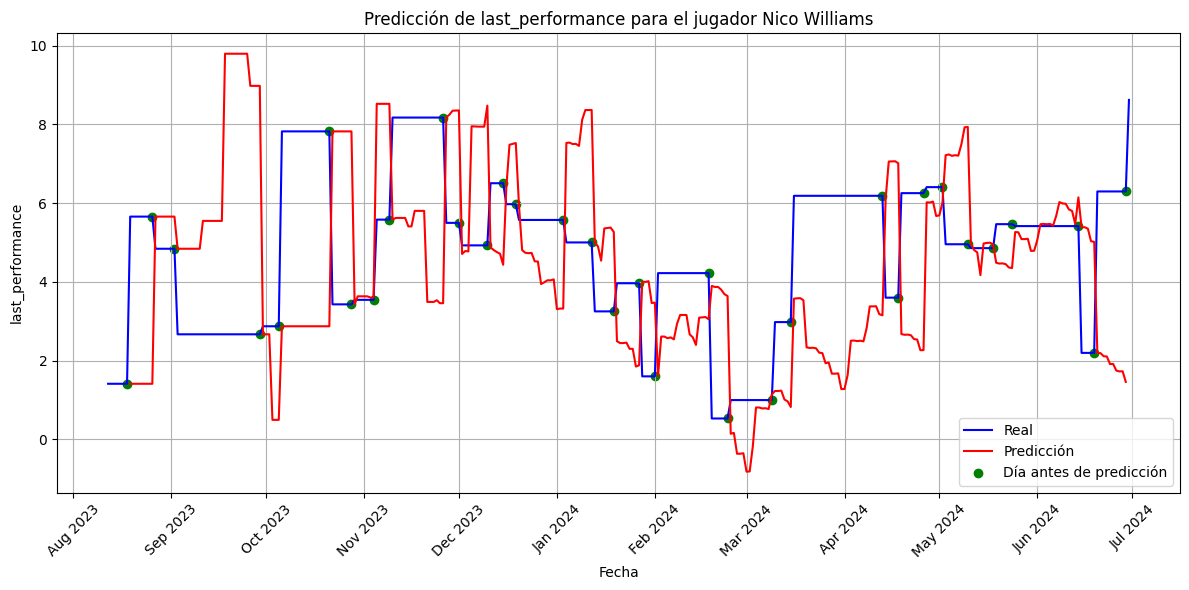

______Todos los días____________
Mean error todos: 2.515690067345025
Std error todos: 1.6960892543252726
Min error todos: 0.012963849647535497
Max error todos: 7.121888296618095
Median error todos: 2.3868020633834925

______Días de partido___________
Mean error dia partido: 2.0102527637811116
Std error dia partido: 1.389251786095972
Min error dia partido: 0.11446907286877694
Max error dia partido: 4.946975558691005
Median error dia partido: 2.2161176960097717

______Días antes de partido_____
Mean error dia antes partido: 2.573790243363594
Std error dia antes partido: 1.5505719953621757
Min error dia antes partido: 0.05851527263261591
Max error dia antes partido: 6.3060401331298594
Median error dia antes partido: 2.597205466198999


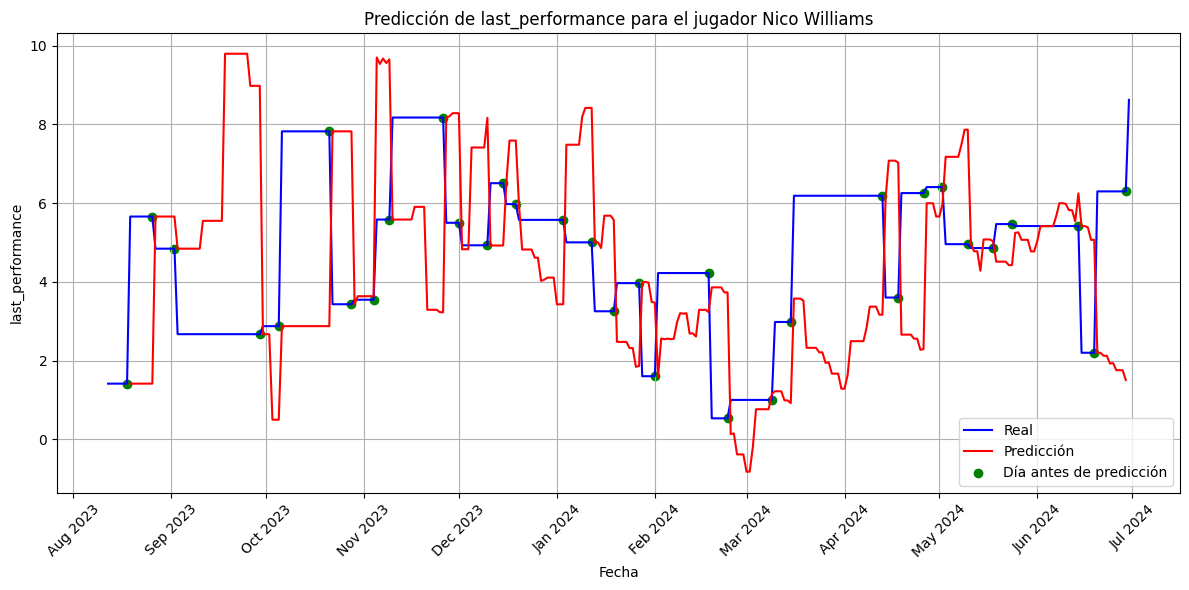

______Todos los días____________
Mean error todos: 2.522653018727269
Std error todos: 1.7124897327940891
Min error todos: 0.00466162276494142
Max error todos: 7.121888296618095
Median error todos: 2.411528498388053

______Días de partido___________
Mean error dia partido: 2.0461786598041733
Std error dia partido: 1.4277981402393105
Min error dia partido: 0.09896565900368426
Max error dia partido: 4.946975558691005
Median error dia partido: 2.1948968396095223

______Días antes de partido_____
Mean error dia antes partido: 2.5971133886336855
Std error dia antes partido: 1.576472588629897
Min error dia antes partido: 0.0894325243303018
Max error dia antes partido: 6.3060401331298594
Median error dia antes partido: 2.5793181174522677


In [80]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

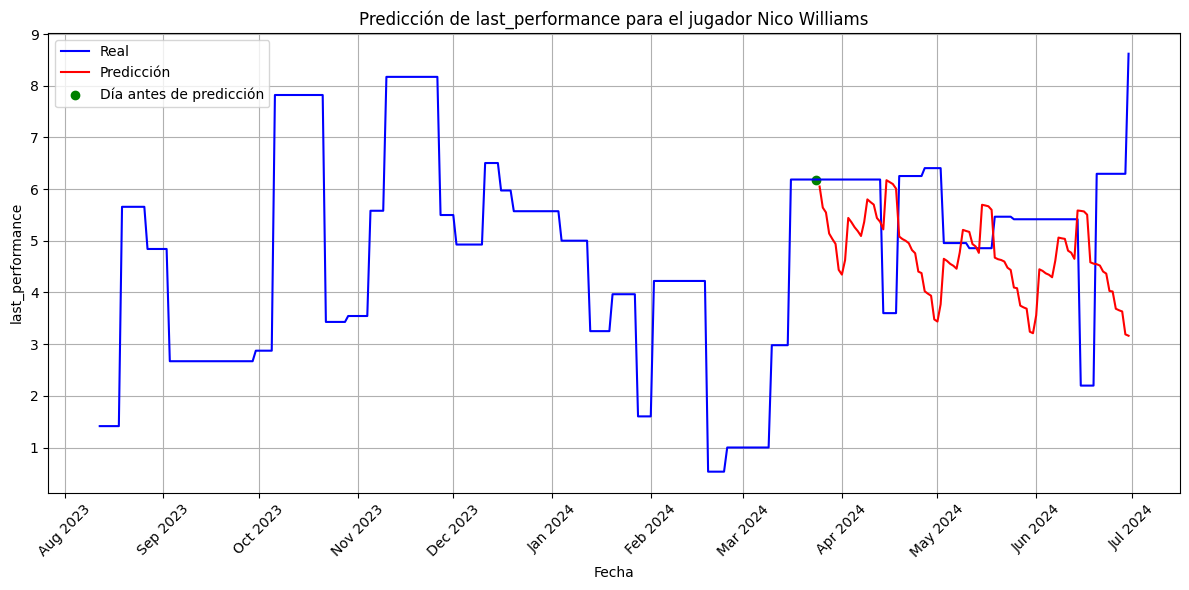

______Todos los días____________
Mean error todos: 1.3818163352850992
Std error todos: 0.9633941683107075
Min error todos: 0.033435005011297925
Max error todos: 5.456553438902913
Median error todos: 1.107377287406143

______Días de partido___________
Mean error dia partido: 1.849126713819367
Std error dia partido: 1.4934027068073996
Min error dia partido: 0.30428705249001897
Max error dia partido: 5.456553438902913
Median error dia partido: 1.4708311906122944

______Días antes de partido_____
Mean error dia antes partido: 1.538180673286893
Std error dia antes partido: 1.0096278229437678
Min error dia antes partido: 0.16945621875291295
Max error dia antes partido: 3.106344243241426
Median error dia antes partido: 1.4546186983203082


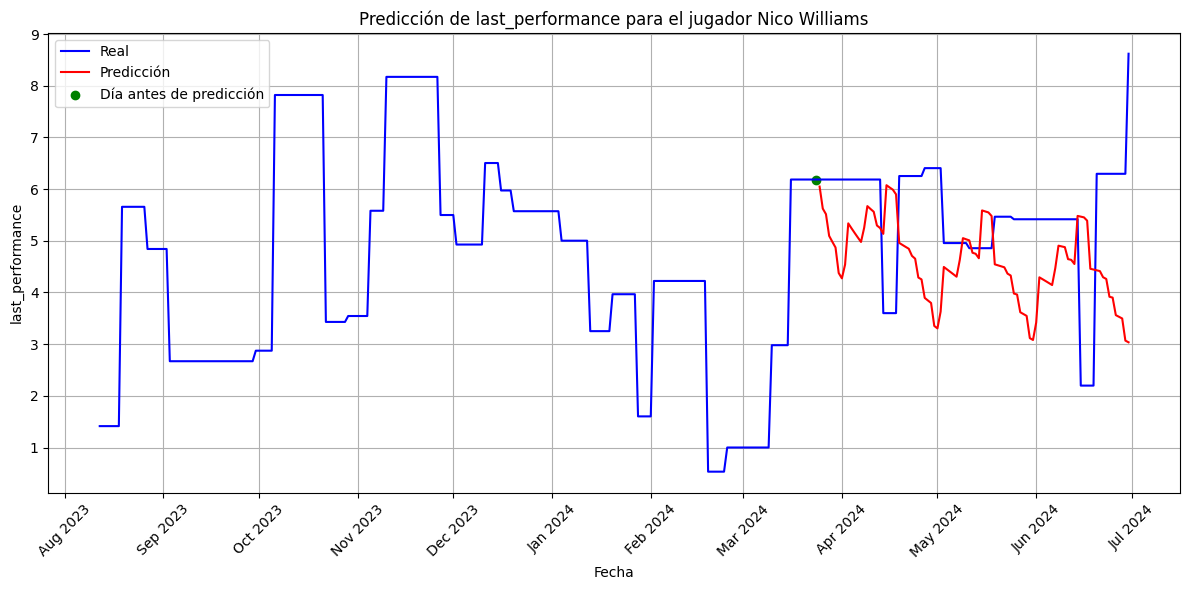

______Todos los días____________
Mean error todos: 1.456616866863648
Std error todos: 0.9582757090079158
Min error todos: 0.06467222070422896
Max error todos: 5.583497497527471
Median error todos: 1.2213907247347562

______Días de partido___________
Mean error dia partido: 1.902939181033376
Std error dia partido: 1.5038928649008014
Min error dia partido: 0.15077634642703241
Max error dia partido: 5.583497497527471
Median error dia partido: 1.4856755291677672

______Días antes de partido_____
Mean error dia antes partido: 1.5384224948425467
Std error dia antes partido: 1.0654134148993053
Min error dia antes partido: 0.06467222070422896
Max error dia antes partido: 3.2273362069715246
Median error dia antes partido: 1.5690026100454473


In [87]:

config = {
    'order': (1,0,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  

# Vinicius JR

In [88]:
jugador = 'Vinicius'
df_jugador = df[df['Player'] == jugador]
df_jugador['Fecha'] = pd.to_datetime(df_jugador['Fecha'])

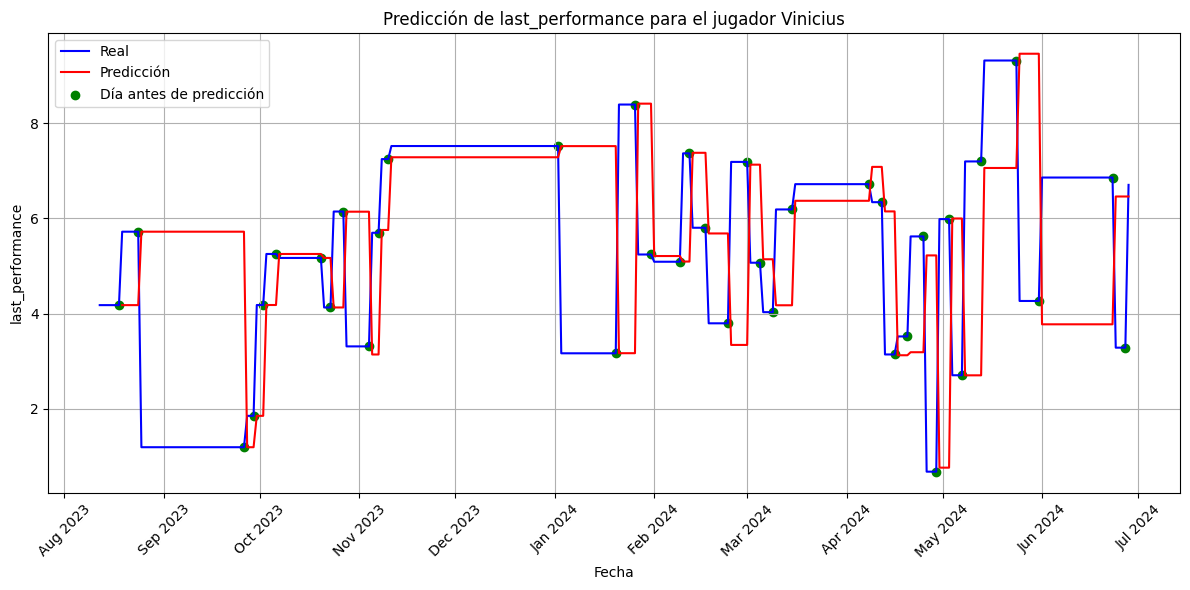

______Todos los días____________
Mean error todos: 2.2101421056826784
Std error todos: 1.7531646582058933
Min error todos: 0.08329161166992893
Max error todos: 5.2307343717221215
Median error todos: 2.0627325561986343

______Días de partido___________
Mean error dia partido: 2.339332035585136
Std error dia partido: 1.5456872727406377
Min error dia partido: 0.08329161166992893
Max error dia partido: 5.2307343717221215
Median error dia partido: 2.2607013485701772

______Días antes de partido_____
Mean error dia antes partido: 2.39751863228978
Std error dia antes partido: 1.5265137529052073
Min error dia antes partido: 0.08329161166992893
Max error dia antes partido: 5.2307343717221215
Median error dia antes partido: 2.2683396608996804


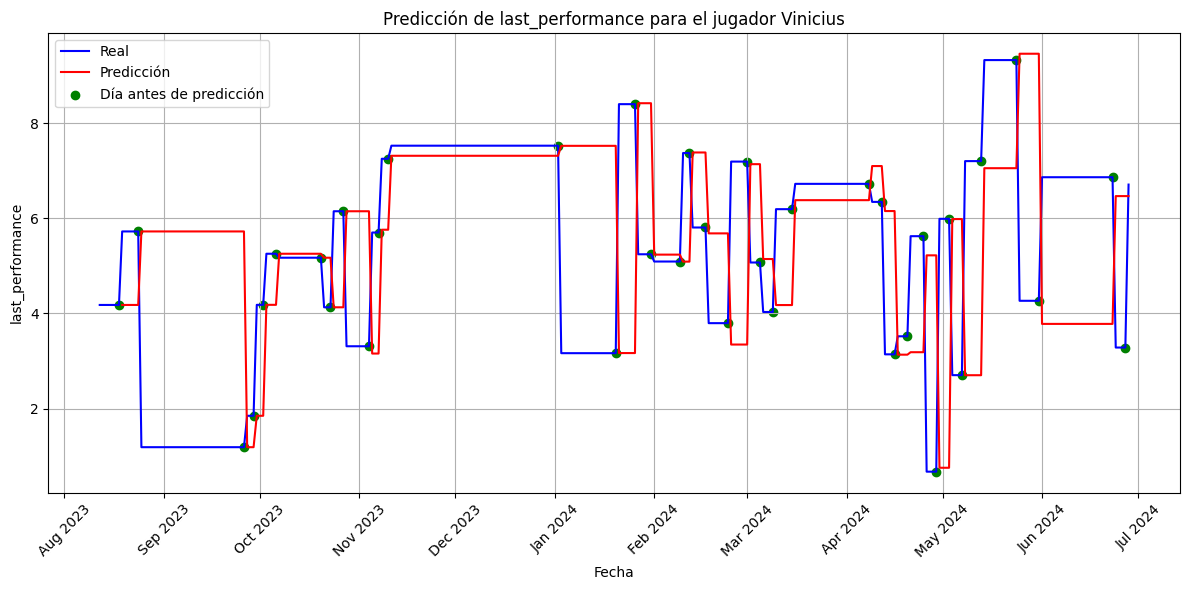

______Todos los días____________
Mean error todos: 2.205628193718
Std error todos: 1.756752896418376
Min error todos: 0.08329161166992893
Max error todos: 5.231175507700531
Median error todos: 2.0664080190114484

______Días de partido___________
Mean error dia partido: 2.3383120047690036
Std error dia partido: 1.5449890823312824
Min error dia partido: 0.08329161166992893
Max error dia partido: 5.231175507700531
Median error dia partido: 2.2718791434259398

______Días antes de partido_____
Mean error dia antes partido: 2.3965339427330714
Std error dia antes partido: 1.525737263487877
Min error dia antes partido: 0.08329161166992893
Max error dia antes partido: 5.231175507700531
Median error dia antes partido: 2.2770379634092475


In [89]:
# Predecir el rendimiento del día de partido desde el día anterior (solo días de partido)
config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_day'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

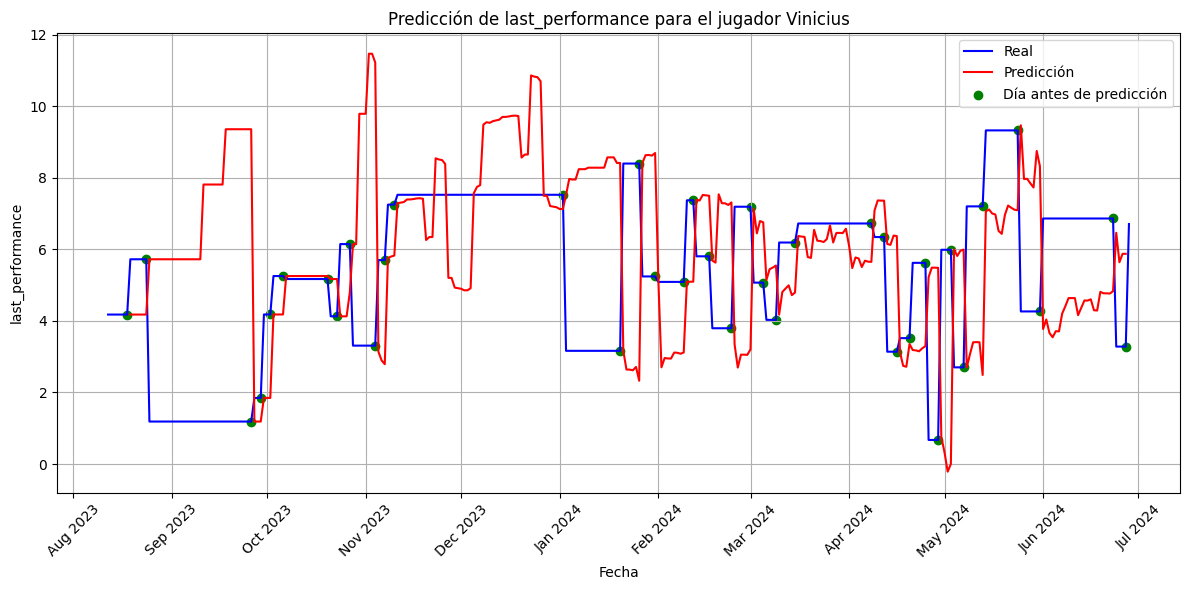

______Todos los días____________
Mean error todos: 2.7260931588954938
Std error todos: 2.0368923748872008
Min error todos: 0.02853370353801754
Max error todos: 8.166902869349986
Median error todos: 2.2830931565339707

______Días de partido___________
Mean error dia partido: 2.39751863228978
Std error dia partido: 1.5265137529052073
Min error dia partido: 0.08329161166992893
Max error dia partido: 5.2307343717221215
Median error dia partido: 2.2683396608996804

______Días antes de partido_____
Mean error dia antes partido: 2.7561940515976073
Std error dia antes partido: 2.0046129978435627
Min error dia antes partido: 0.08329975963511238
Max error dia antes partido: 8.166902869349986
Median error dia antes partido: 2.2531569138481338


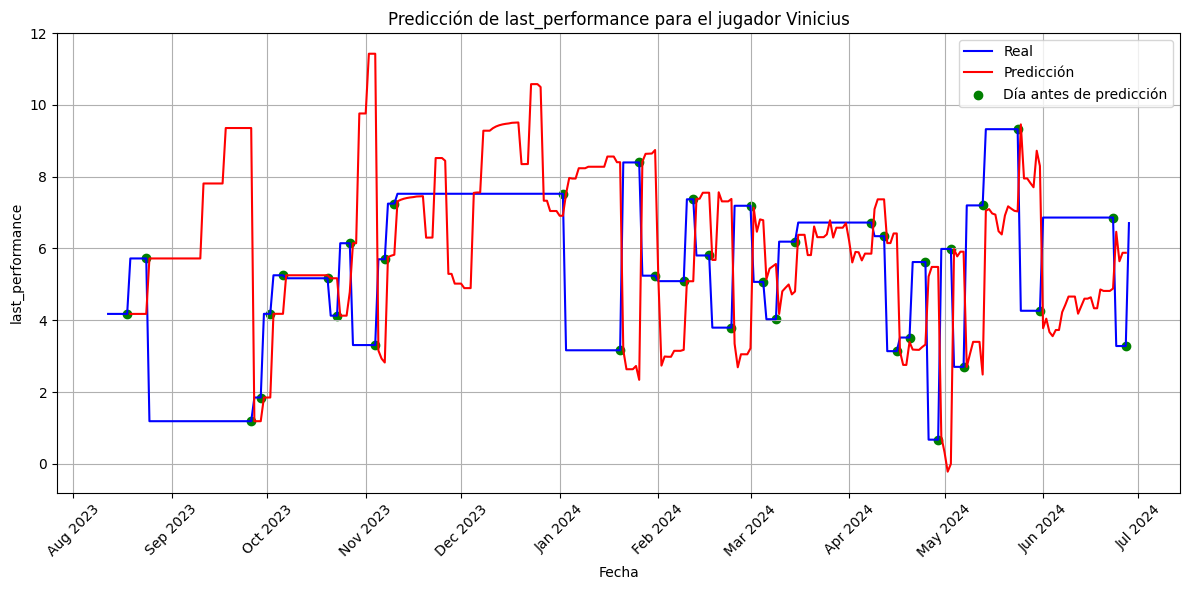

______Todos los días____________
Mean error todos: 2.7027493878247895
Std error todos: 2.0482620821162474
Min error todos: 0.01718590749867488
Max error todos: 8.166902869349986
Median error todos: 2.278407791727898

______Días de partido___________
Mean error dia partido: 2.3965339427330714
Std error dia partido: 1.525737263487877
Min error dia partido: 0.08329161166992893
Max error dia partido: 5.231175507700531
Median error dia partido: 2.2770379634092475

______Días antes de partido_____
Mean error dia antes partido: 2.7623370618743857
Std error dia antes partido: 2.0180633844436793
Min error dia antes partido: 0.08329947177883934
Max error dia antes partido: 8.166902869349986
Median error dia antes partido: 2.287204250328878


In [90]:
# Predecir rendimiento de todos los días desde un partido hasta el siguiente

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'matches',
    'step_options': 'next_match'
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)

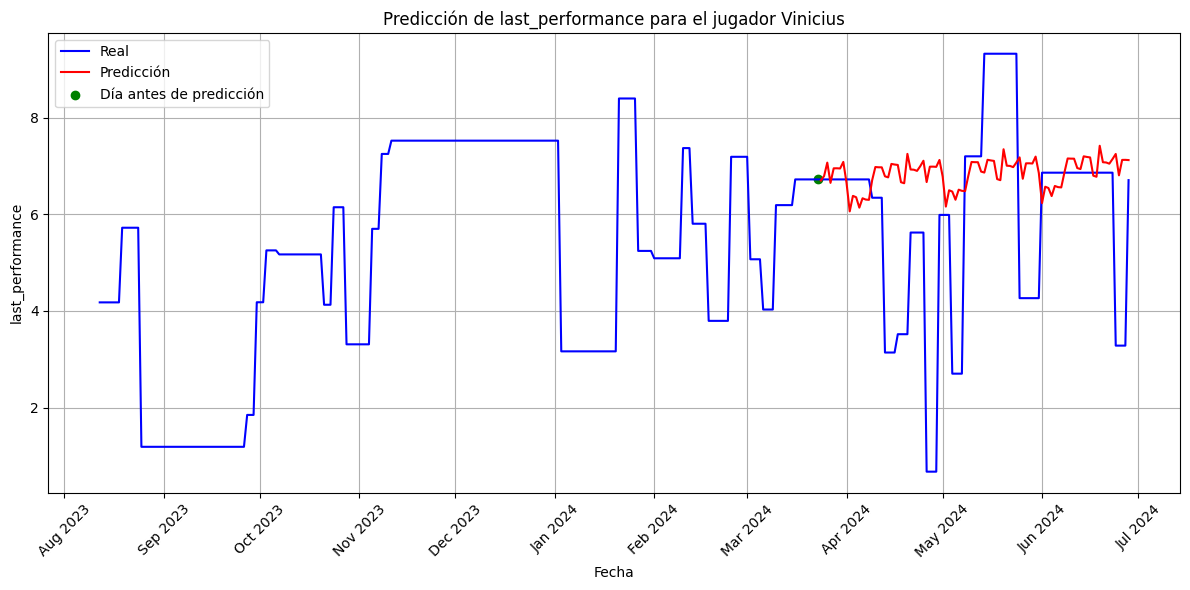

______Todos los días____________
Mean error todos: 1.5801477343192667
Std error todos: 1.6371763187429442
Min error todos: 0.006653755780484438
Max error todos: 6.312452356435237
Median error todos: 0.6300522687397141

______Días de partido___________
Mean error dia partido: 2.370605786540896
Std error dia partido: 1.6893037077476487
Min error dia partido: 0.36305992954530275
Max error dia partido: 5.992848472492091
Median error dia partido: 2.459112839219797

______Días antes de partido_____
Mean error dia antes partido: 2.3112289499225587
Std error dia antes partido: 1.8293073974286036
Min error dia antes partido: 0.28262045556060666
Max error dia antes partido: 6.307932650714387
Median error dia antes partido: 2.2505176081683445


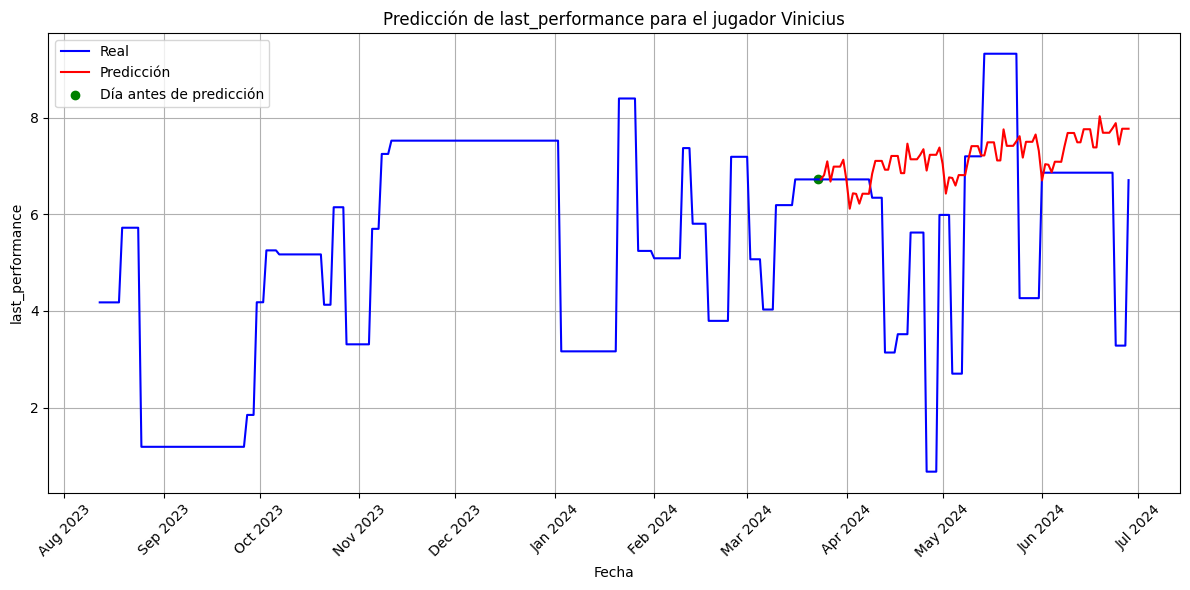

______Todos los días____________
Mean error todos: 1.7310665701340886
Std error todos: 1.6960006066630882
Min error todos: 0.0015590521315589356
Max error todos: 6.55731965501338
Median error todos: 0.8992327688747555

______Días de partido___________
Mean error dia partido: 2.525679215506414
Std error dia partido: 1.8160079828287485
Min error dia partido: 0.15979860833332005
Max error dia partido: 6.230632598013023
Median error dia partido: 2.1048149317359073

______Días antes de partido_____
Mean error dia antes partido: 2.502066763088048
Std error dia antes partido: 1.9298397928085262
Min error dia antes partido: 0.018210875389082837
Max error dia antes partido: 6.55731965501338
Median error dia antes partido: 1.8132903528460105


In [97]:

config = {
    'order': (1,1,1),
    'seasonal_order': (1,1,1,30),
    'y': 'last_performance',
    'exog': 'Sentimientos_acumulado',
    'exog_options': 'no_future',
    'pred_options': 'one',
    'train_size': 0.7
}

evaluate_model(df_jugador, config)
evaluate_model_no_exog(df_jugador, config)  